## Description

In this notebook, we use the results of lipid quantification in Notebook 4 to segment the images.   

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (600, 1000)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [9]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 207 formulas for cerebellum
Loaded 180 formulas for bladder


In [10]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

Load the quantification results from Notebook 5:

In [11]:
masserstein_estimation = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
[masserstein_estimation[n].shape for n in image_names]

[(21, 81, 207), (134, 260, 180)]

In [12]:
single_peak_intensities = {n : np.load(n+'_single_peak_images.dmp', allow_pickle=True) for n in image_names}
[single_peak_intensities[n].shape for n in image_names]

[(21, 81, 207), (134, 260, 180)]

<IPython.core.display.Javascript object>


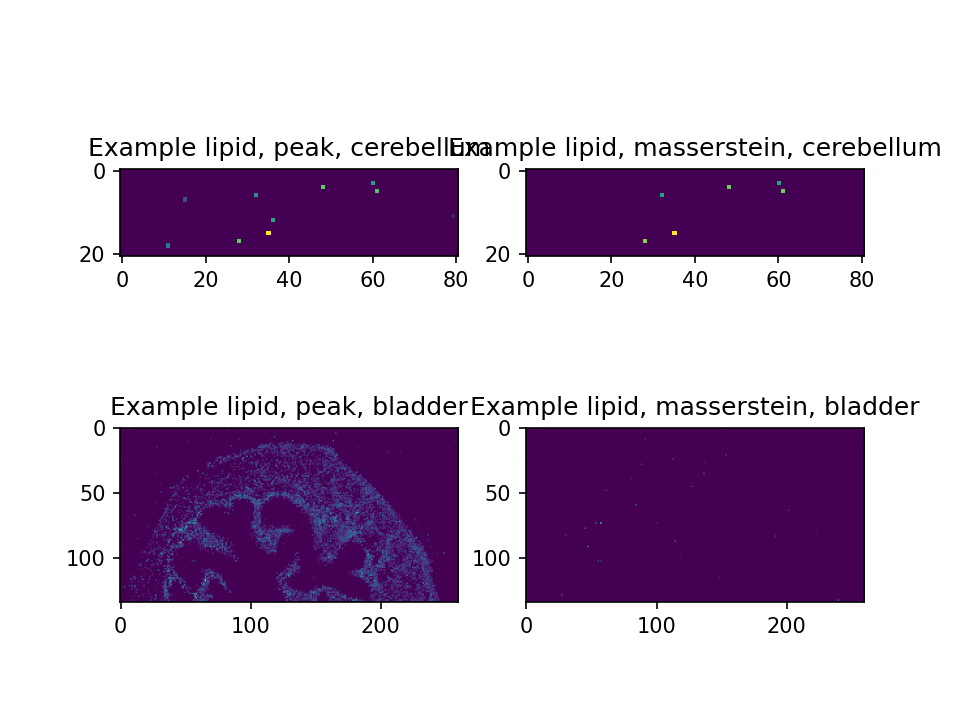

In [13]:
lipid_id = 0

plt.figure()
plt.subplot(221)
plt.title('Example lipid, peak, cerebellum')
plt.imshow(single_peak_intensities['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Example lipid, masserstein, cerebellum')
plt.imshow(masserstein_estimation['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Example lipid, peak, bladder')
plt.imshow(single_peak_intensities['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Example lipid, masserstein, bladder')
plt.imshow(masserstein_estimation['bladder'][...,lipid_id])
plt.show()

## K-means segmentation of peak intensities

First, we'll compute K-means segmentations based on peak intensities. 

In [18]:
nclust = 3
km = KMeans(n_clusters=nclust, n_init='auto')

In [15]:
intensity_segmentation = {n : np.zeros(single_peak_intensities[n].shape, dtype='int') for n in image_names}
for n in image_names:
    intsy_matrix = single_peak_intensities[n]
    for j in range(intsy_matrix.shape[2]):
        intsy_vector = intsy_matrix[...,j].reshape((-1,1))
        segm = km.fit_predict(intsy_vector)
        cluster_centers = km.cluster_centers_[:,0]
        cluster_order = np.argsort(np.argsort(cluster_centers))
        relabeled_segm = cluster_order[segm].reshape(intsy_matrix.shape[:2])
        intensity_segmentation[n][...,j] = relabeled_segm
    

Visualize an example segmentation:

<IPython.core.display.Javascript object>


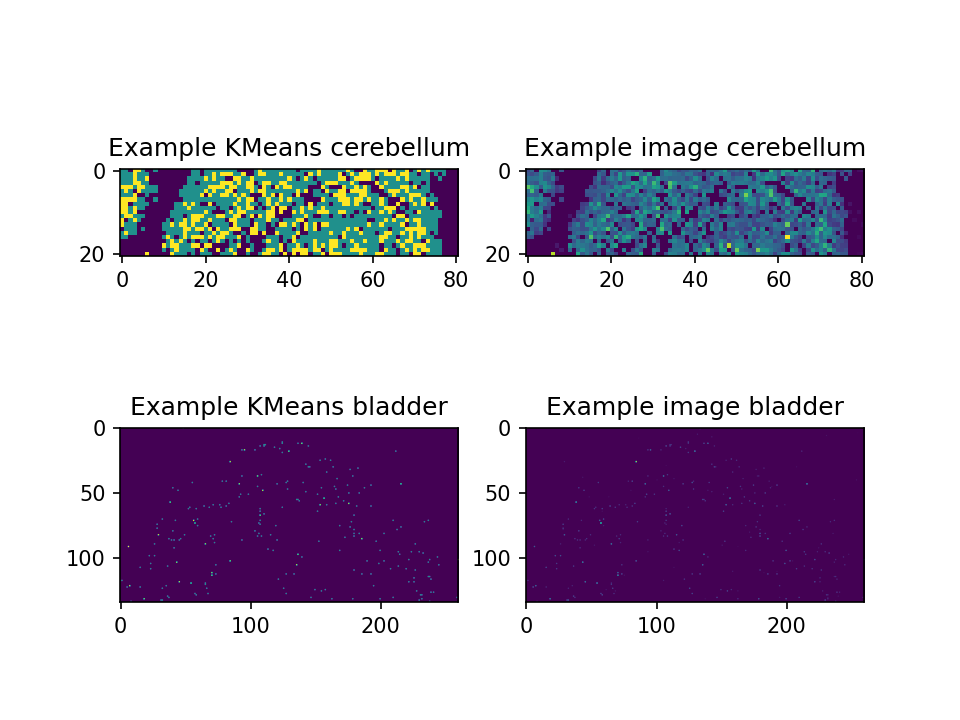

In [16]:
lipid_id = 20

plt.figure()
plt.subplot(221)
plt.title('Example KMeans cerebellum')
plt.imshow(intensity_segmentation['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Example image cerebellum')
plt.imshow(single_peak_intensities['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Example KMeans bladder')
plt.imshow(intensity_segmentation['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Example image bladder')
plt.imshow(single_peak_intensities['bladder'][...,lipid_id])
plt.show()

Save the segmentation results

In [17]:
for n in image_names:
    intensity_segmentation[n].dump(n+'_peak_kmeans_segmentation.dmp')
# # For saving as tsv:
# for n in image_names:
#     with open(n + '_kmeans.tsv', 'w') as h:
#         sgm_table = intensity_segmentation[n]
#         crd = intensity_coordinates[n]
#         header = ['X', 'Y'] + list(map(str, range(sgm_table.shape[1])))
#         h.write('\t'.join(header) + '\n')
#         for l1, l2 in zip(crd, sgm_table):
#             l1 = '\t'.join(list(map(str, l1)))
#             l2 = '\t'.join(list(map(str, l2)))
#             h.write(l1 + '\t' + l2 + '\n')

## K-means segmentation of estimated signals

In [19]:
nclust = 3
km = KMeans(n_clusters=nclust, n_init='auto')

In [20]:
masserstein_kmeans_segmentation = {n : np.zeros(masserstein_estimation[n].shape, dtype='int') for n in image_names}
for n in image_names:
    intsy_matrix = masserstein_estimation[n]
    for j in range(intsy_matrix.shape[2]):
        intsy_vector = intsy_matrix[...,j].reshape((-1,1))
        segm = km.fit_predict(intsy_vector)
        cluster_centers = km.cluster_centers_[:,0]
        cluster_order = np.argsort(np.argsort(cluster_centers))
        relabeled_segm = cluster_order[segm].reshape(intsy_matrix.shape[:2])
        masserstein_kmeans_segmentation[n][...,j] = relabeled_segm

/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Visualize the segmentation:

<IPython.core.display.Javascript object>


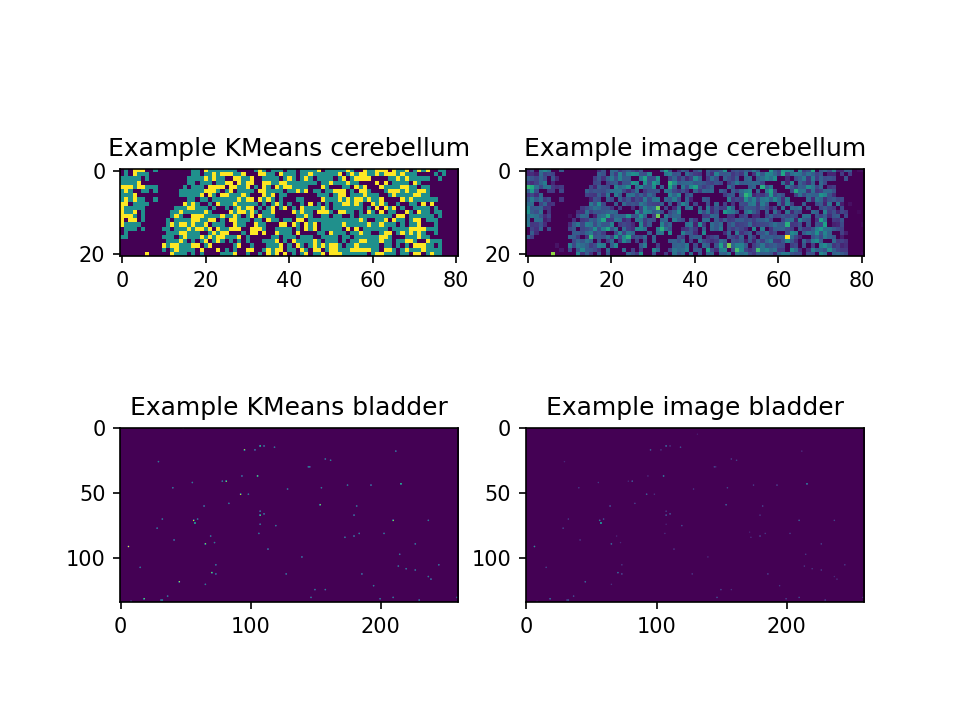

In [21]:
lipid_id = 20

plt.figure()
plt.subplot(221)
plt.title('Example KMeans cerebellum')
plt.imshow(masserstein_kmeans_segmentation['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Example image cerebellum')
plt.imshow(masserstein_estimation['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Example KMeans bladder')
plt.imshow(masserstein_kmeans_segmentation['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Example image bladder')
plt.imshow(masserstein_estimation['bladder'][...,lipid_id])
plt.show()

Save the results

In [23]:
for n in image_names:
    masserstein_kmeans_segmentation[n].dump(n+'_masserstein_kmeans_segmentation.dmp')

## spatial-DGMM segmentation of estimated signals  
First, load R and the Cardinal package

In [24]:
%load_ext rpy2.ipython

In [25]:
%R suppressPackageStartupMessages(library(Cardinal))

array(['Cardinal', 'S4Vectors', 'stats4', 'BiocParallel', 'BiocGenerics',
       'ProtGenerics', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U12')

In [52]:
%R setCardinalBPPARAM(MulticoreParam(timeout=600))

o{'Cardinal.bpparam': class: MulticoreParam
  bpisup: FALSE; bpnworkers: 14; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: NA; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpexportvariables: FALSE; bpforceGC: FALSE
  bpfallback: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK
, }

Convert our intensity arrays to Pandas DataFrames

In [27]:
cerebellum_df = pd.DataFrame({'L%i' % (li+1): masserstein_estimation['cerebellum'][...,li].flatten() for li in range(masserstein_estimation['cerebellum'].shape[2])})
cerebellum_df[['x', 'y']] = [(x+1,y+1) for y in range(image_shapes['cerebellum'][0]) for x in range(image_shapes['cerebellum'][1])]

bladder_df = pd.DataFrame({'L%i' % (li+1): masserstein_estimation['bladder'][...,li].flatten() for li in range(masserstein_estimation['bladder'].shape[2])})
bladder_df[['x', 'y']] = [(x+1,y+1) for y in range(image_shapes['bladder'][0]) for x in range(image_shapes['bladder'][1])]
cerebellum_df

L1   L2        L3   L4   L5   L6        L7            L8   L9  L10  \
0    -0.0 -0.0  0.001622 -0.0 -0.0 -0.0  0.003010  0.000000e+00 -0.0 -0.0   
1    -0.0 -0.0  0.000836 -0.0 -0.0 -0.0  0.002401  0.000000e+00 -0.0 -0.0   
2    -0.0 -0.0  0.001252 -0.0 -0.0 -0.0  0.003331  0.000000e+00 -0.0 -0.0   
3    -0.0 -0.0  0.000745 -0.0 -0.0 -0.0  0.001365 -9.371256e-15 -0.0 -0.0   
4    -0.0 -0.0  0.001111 -0.0 -0.0 -0.0  0.003326  8.938803e-04 -0.0 -0.0   
...   ...  ...       ...  ...  ...  ...       ...           ...  ...  ...   
1696 -0.0 -0.0 -0.000000 -0.0 -0.0  0.0 -0.000000 -0.000000e+00 -0.0 -0.0   
1697  0.0  0.0  0.000000 -0.0  0.0  0.0  0.000088  0.000000e+00 -0.0 -0.0   
1698  0.0  0.0  0.000000 -0.0  0.0  0.0  0.000093  0.000000e+00 -0.0 -0.0   
1699 -0.0  0.0  0.000000 -0.0 -0.0 -0.0  0.000000 -0.000000e+00 -0.0 -0.0   
1700  0.0  0.0  0.000000 -0.0 -0.0 -0.0  0.000236  0.000000e+00 -0.0 -0.0   

      ...      L200      L201      L202      L203  L204      L205      L206  \
0     ...  0.000788  0.001083  0.059611 -0.000000  -0.0  0.012520  0.002682   
1     ... -0.000000  0.001414  0.055063 -0.000000  -0.0  0.011657  0.001755   
2     ... -0.000000  0.000943  0.052132  0.000918  -0.0  0.008227  0.002699   
3     ... -0.000000  0.001469  0.056552  0.001131  -0.0  0.007089  0.003027   
4     ... -0.000000  0.000768  0.052784 -0.000000  -0.0  0.007828  0.000808   
...   ...       ...       ...       ...       ...   ...       ...       ...   
1696  ... -0.000000  0.001140  0.033869 -0.000000  -0.0  0.004909  0.000742   
1697  ...  0.000000  0.000000  0.001427  0.000000   0.0 -0.000000  0.000000   
1698  ...  0.000000 -0.000000  0.000811  0.000000   0.0 -0.000000  0.000000   
1699  ... -0.000000 -0.000000  0.001010  0.000000   0.0 -0.000000  0.000000   
1700  ...  0.000000 -0.000000  0.001093  0.000000   0.0 -0.000000  0.000000   

          L207   x   y  
0    -0.000000   1   1  
1    -0.000000   2   1  
2    -0.000000   3   1  
3    -0.000000   4   1  
4    -0.000000   5   1  
...        ...  ..  ..  
1696 -0.000000  77  21  
1697  0.000104  78  21  
1698  0.000000  79  21  
1699  0.000000  80  21  
1700 -0.000000  81  21  

[1701 rows x 209 columns]

Import the data into R

In [28]:
%R -i cerebellum_df 
%R -i bladder_df

Visualize an example signal distribution throughout the cerebellum.    

In [29]:
%%R 
x <- cerebellum_df[['L4']]

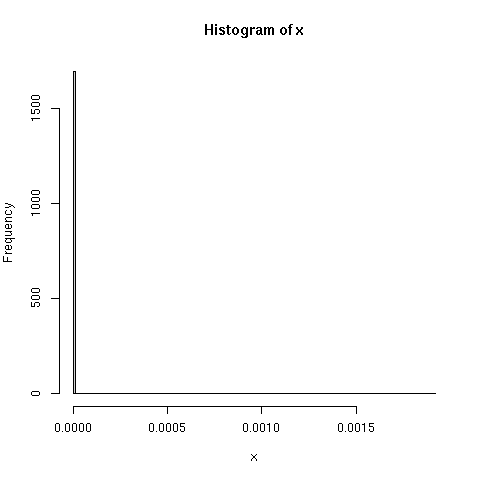

In [30]:
%%R 
hist(x, breaks=200)

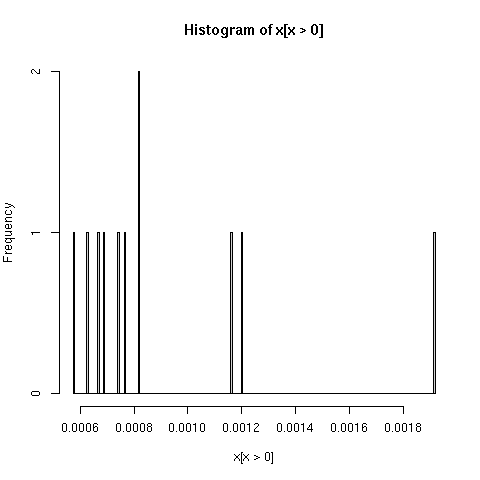

In [31]:
%%R 
hist(x[x>0], breaks=200)

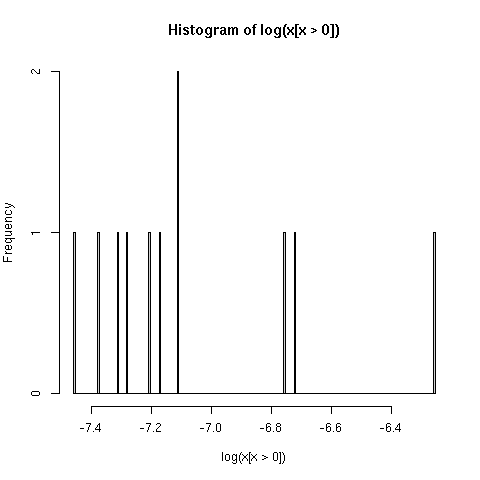

In [32]:
%%R 
hist(log(x[x>0]), breaks=200)

Creating Cardinal images

In [33]:
%%R 
# Creating a test image
test_coord <- bladder_df[,c('x', 'y')] 
test_sdata <- t(unname(as.matrix(bladder_df[,1:4])))
# Optional removing of background
test_sdata <- test_sdata + rexp(n=ncol(test_sdata)*nrow(test_sdata), rate=1000)
test_run <- factor(rep("run0", nrow(test_coord)))
test_fdata <- MassDataFrame(mz=as.numeric(1:nrow(test_sdata)))
test_pdata <- PositionDataFrame(run=test_run, coord=test_coord)
# # Optional normalization
# test_sdata = apply(test_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# test_sdata = apply(test_sdata, 2, log)
# Optional unit change
test_sdata <- 100000*test_sdata
test_image <- MSImagingExperiment(spectraData=test_sdata,
                                 featureData=test_fdata,
                                 pixelData=test_pdata,
                                 centroided = TRUE)


# Creating cerebellum image
cerebellum_coord <- cerebellum_df[,c('x', 'y')] 
cerebellum_sdata <- t(unname(as.matrix(cerebellum_df[!names(cerebellum_df) %in% c('x', 'y')])))
cerebellum_run <- factor(rep("run0", nrow(cerebellum_coord)))
cerebellum_fdata <- MassDataFrame(mz=1:nrow(cerebellum_sdata))
cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=cerebellum_coord)
# # Optional normalization
# cerebellum_sdata = apply(cerebellum_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# cerebellum_sdata = apply(cerebellum_sdata, 2, log)
cerebellum_image <- MSImagingExperiment(spectraData=cerebellum_sdata,
                                 featureData=cerebellum_fdata,
                                 pixelData=cerebellum_pdata,
                                 centroided = TRUE)

# Creating bladder image
bladder_coord <- bladder_df[,c('x', 'y')] 
bladder_sdata <- t(unname(as.matrix(bladder_df[!names(bladder_df) %in% c('x', 'y')])))
bladder_run <- factor(rep("run0", nrow(bladder_coord)))
bladder_fdata <- MassDataFrame(mz=as.numeric(1:nrow(bladder_sdata)))
bladder_pdata <- PositionDataFrame(run=bladder_run, coord=bladder_coord)
# # Optional normalization
# bladder_sdata = apply(bladder_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# bladder_sdata = apply(bladder_sdata, 2, log)
bladder_image <- MSImagingExperiment(spectraData=bladder_sdata,
                                 featureData=bladder_fdata,
                                 pixelData=bladder_pdata,
                                 centroided = TRUE)

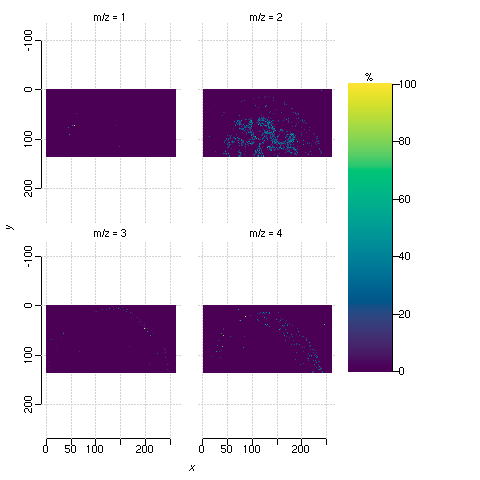

In [34]:
%%R
image(bladder_image, mz=1:4, scale=T)

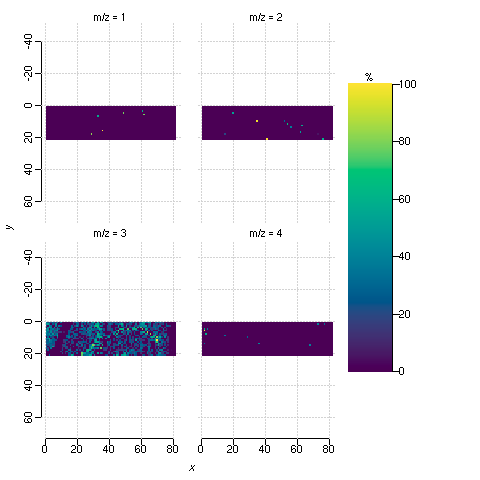

In [35]:
%%R
image(cerebellum_image, mz=1:4, scale=T)

Segmentation

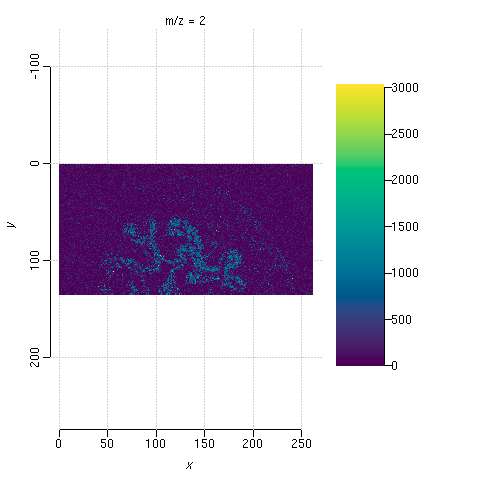

In [40]:
%%R
image(test_image,i=2)

In [37]:
%%R
test_sdgmm <- spatialDGMM(test_image, r=4, k=3, tol=1e-12, iter.max=2000)

calculating gaussian weights
fitting spatial Gaussian mixture models for k = 3
fitting spatial segmentations for 4 images
processing chunk 1/2 (2 items)

processing chunk 2/2 (2 items)

returning spatial Gaussian mixture models


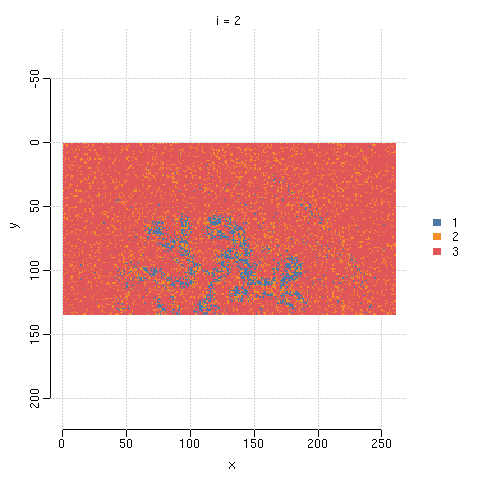

In [41]:
%%R
image(test_sdgmm, values='class', i=2)

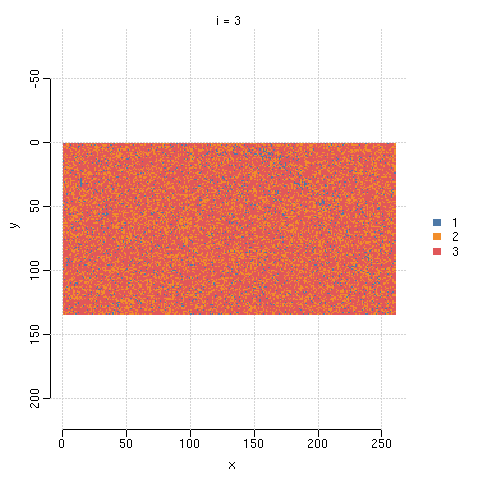

In [42]:
%%R
image(test_sdgmm, values='class', i=3)

In [53]:
%%R 
bladder_sdgmm <- spatialDGMM(bladder_image, r=6, k=3, tol=1e-12, iter.max=2000)
cerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=6, k=3, tol=1e-12, iter.max=2000)

calculating gaussian weights
fitting spatial Gaussian mixture models for k = 3
fitting spatial segmentations for 180 images
processing chunk 9/20 (9 items)
processing chunk 10/20 (9 items)

processing chunk 5/20 (9 items)
processing chunk 6/20 (9 items)

processing chunk 7/20 (9 items)
processing chunk 8/20 (9 items)

processing chunk 1/20 (9 items)
processing chunk 2/20 (9 items)

processing chunk 15/20 (9 items)
processing chunk 16/20 (9 items)

processing chunk 3/20 (9 items)
processing chunk 4/20 (9 items)

processing chunk 19/20 (9 items)
processing chunk 20/20 (9 items)

processing chunk 11/20 (9 items)
processing chunk 12/20 (9 items)

processing chunk 17/20 (9 items)
processing chunk 18/20 (9 items)

processing chunk 13/20 (9 items)
processing chunk 14/20 (9 items)

returning spatial Gaussian mixture models
calculating gaussian weights
fitting spatial Gaussian mixture models for k = 3
fitting spatial segmentations for 207 images
processing chunk 9/20 (10 items)

processing chun

RInterpreterError: Failed to parse and evaluate line 'bladder_sdgmm <- spatialDGMM(bladder_image, r=6, k=3, tol=1e-12, iter.max=2000)\ncerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=6, k=3, tol=1e-12, iter.max=2000)\n'.
R error message: 'Error: BiocParallel errors\n  0 remote errors, element index: \n  16 unevaluated and other errors\n  first remote error:'
R stdout:
calculating gaussian weights
fitting spatial Gaussian mixture models for k = 3
fitting spatial segmentations for 180 images
processing chunk 9/20 (9 items)
processing chunk 10/20 (9 items)

processing chunk 5/20 (9 items)
processing chunk 6/20 (9 items)

processing chunk 7/20 (9 items)
processing chunk 8/20 (9 items)

processing chunk 1/20 (9 items)
processing chunk 2/20 (9 items)

processing chunk 15/20 (9 items)
processing chunk 16/20 (9 items)

processing chunk 3/20 (9 items)
processing chunk 4/20 (9 items)

processing chunk 19/20 (9 items)
processing chunk 20/20 (9 items)

processing chunk 11/20 (9 items)
processing chunk 12/20 (9 items)

processing chunk 17/20 (9 items)
processing chunk 18/20 (9 items)

processing chunk 13/20 (9 items)
processing chunk 14/20 (9 items)

returning spatial Gaussian mixture models
calculating gaussian weights
fitting spatial Gaussian mixture models for k = 3
fitting spatial segmentations for 207 images
processing chunk 9/20 (10 items)

processing chunk 19/20 (10 items)

processing chunk 1/20 (11 items)
processing chunk 2/20 (10 items)

processing chunk 11/20 (10 items)
processing chunk 12/20 (10 items)

processing chunk 7/20 (11 items)
processing chunk 8/20 (10 items)

processing chunk 15/20 (10 items)
processing chunk 16/20 (10 items)

processing chunk 13/20 (10 items)
processing chunk 14/20 (11 items)

processing chunk 3/20 (10 items)
processing chunk 4/20 (11 items)

Stop worker failed with the error: reached CPU time limit
Error: BiocParallel errors
  0 remote errors, element index: 
  16 unevaluated and other errors
  first remote error:
In addition: Warning message:
In sgmixn(NULL, NULL, x, r = r, k = k[j], group = groups, weights = wts,  :
  fewer than k classes for images 30, 79, 90, 99

Visualize the segmentation before exporting back to Python

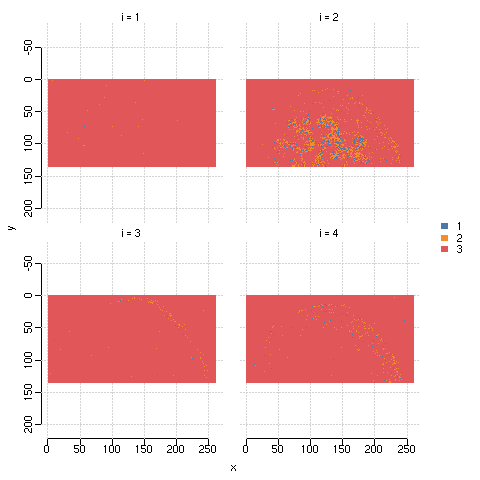

In [50]:
%%R 
image(bladder_sdgmm, values='class', i=1:4)

In [51]:
%%R 
image(cerebellum_sdgmm, values='class', i=1:4)

Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'image': object 'cerebellum_sdgmm' not found


RInterpreterError: Failed to parse and evaluate line "image(cerebellum_sdgmm, values='class', i=1:4)\n".
R error message: "Error in h(simpleError(msg, call)) : \n  error in evaluating the argument 'x' in selecting a method for function 'image': object 'cerebellum_sdgmm' not found"

Cast to arrays before exporting back to Python, transform class labels so that 0 = lowest intensity, 2 = highest intensity.  

In [42]:
%%R
cerebellum_segmentation <- 3 - sapply(cerebellum_sdgmm$class, as.numeric)

bladder_segmentation <- 3 - sapply(bladder_sdgmm$class, as.numeric)
# bladder_segmentation <- cbind(bladder_coord-1, bladder_segmentation)

Export the segmentation results back to Python

In [43]:
cerebellum_sdgmm_segmentation = %Rget cerebellum_segmentation
cerebellum_sdgmm_segmentation = cerebellum_sdgmm_segmentation.reshape(image_shapes['cerebellum'] + (-1,))
bladder_sdgmm_segmentation = %Rget bladder_segmentation
bladder_sdgmm_segmentation = bladder_sdgmm_segmentation.reshape(image_shapes['bladder'] + (-1,))

masserstein_segmentation = {'cerebellum' : cerebellum_sdgmm_segmentation, 
                            'bladder' : bladder_sdgmm_segmentation}

Visualize example segmentations to verify correct exporting:

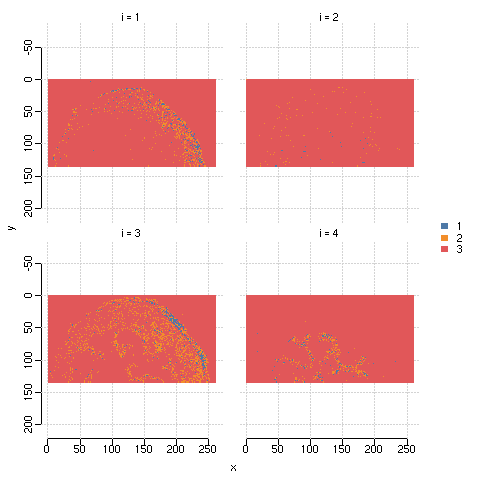

In [44]:
%%R 
image(bladder_sdgmm, values='class', i=1:4)

<IPython.core.display.Javascript object>


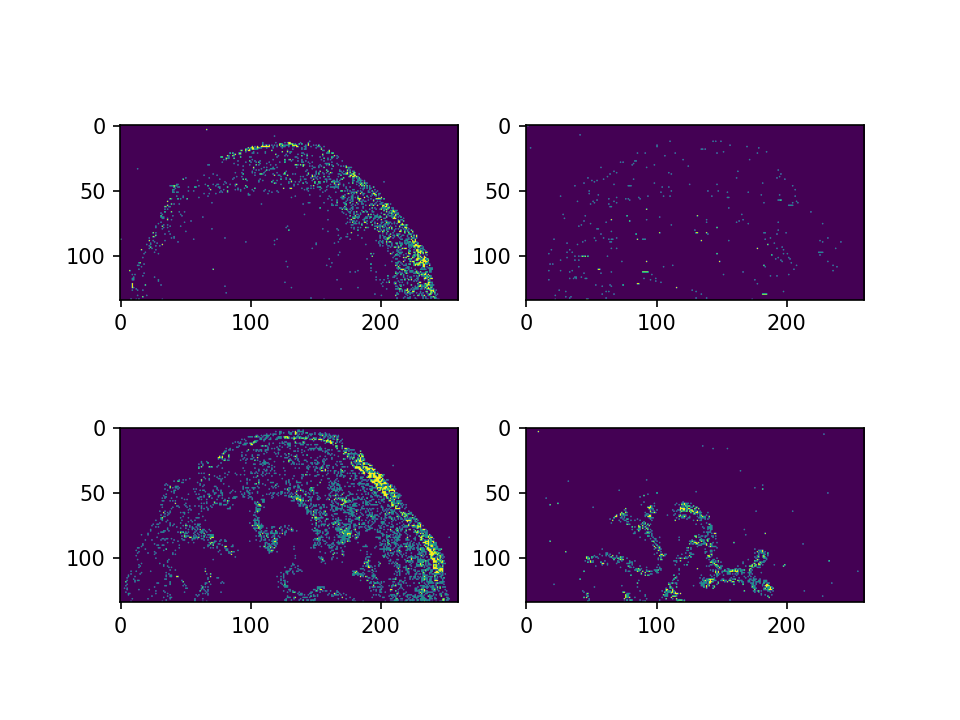

In [45]:
plt.figure()
for i in range(4):
    plt.subplot(221+i)
    plt.imshow(bladder_sdgmm_segmentation[...,i])

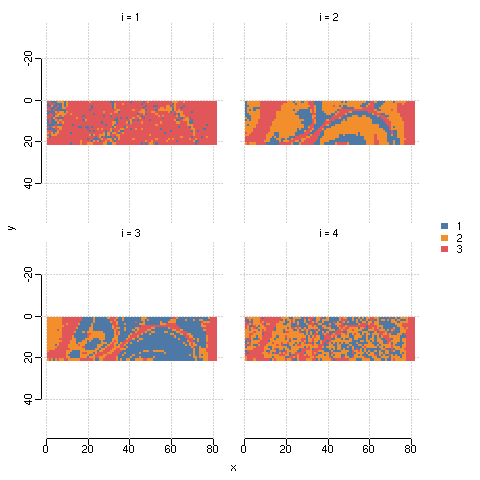

In [46]:
%%R 
image(cerebellum_sdgmm, values='class', i=1:4)

<IPython.core.display.Javascript object>


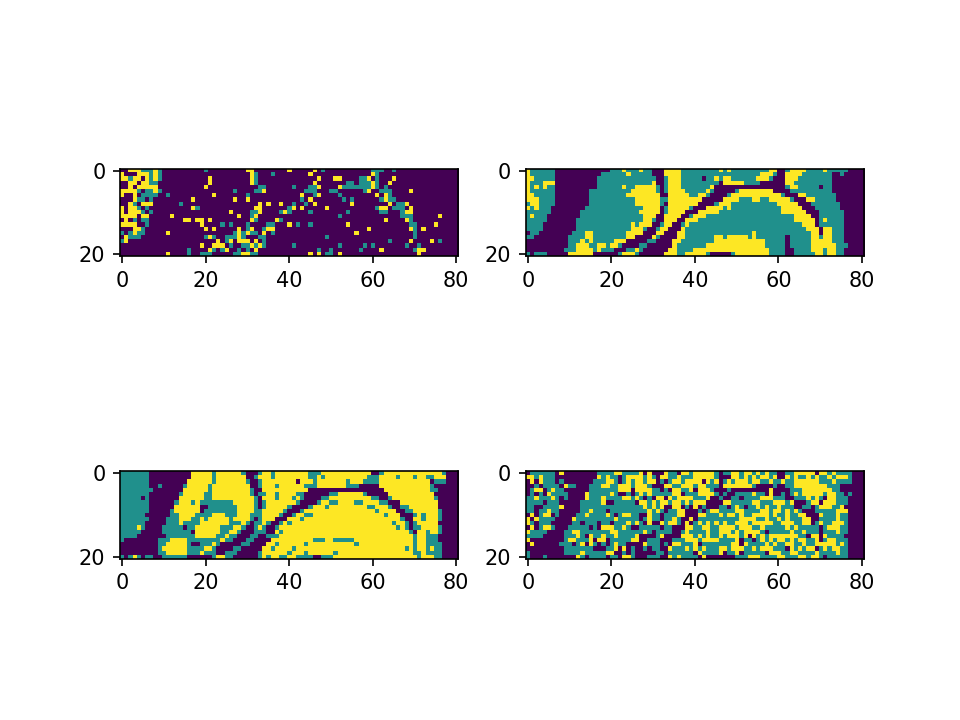

In [47]:
plt.figure()
for i in range(4):
    plt.subplot(221+i)
    plt.imshow(cerebellum_sdgmm_segmentation[...,i])


Compare the two segmentation algorithms visually to verify correct processing (we will analyze them further in the next notebook):

<IPython.core.display.Javascript object>


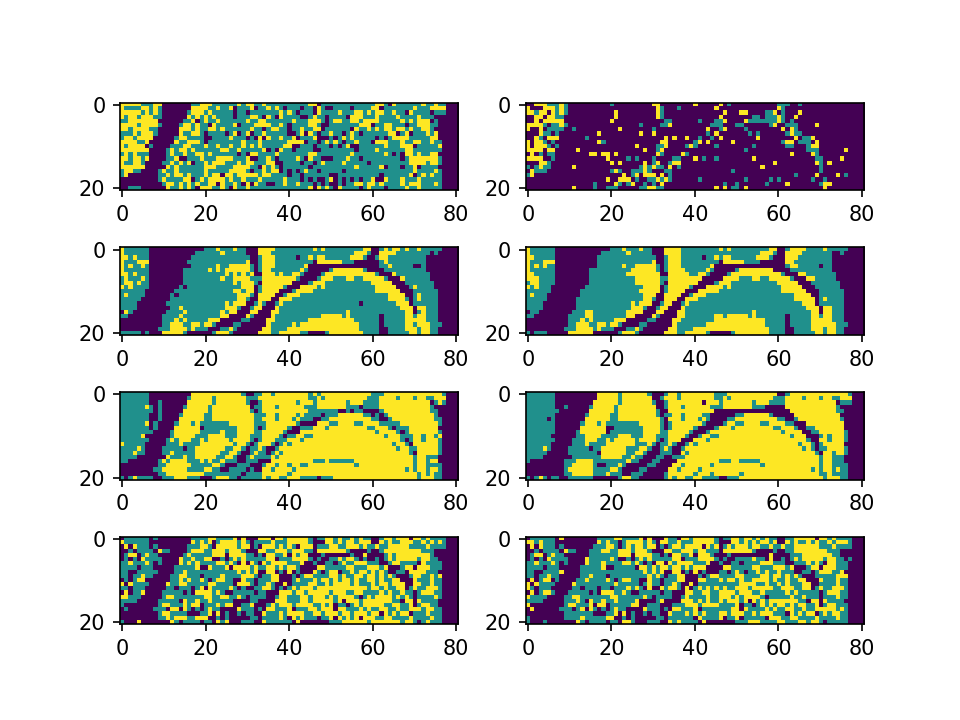

In [48]:
plt.figure()
for i in range(4):
    plt.subplot(421+2*i)
    plt.imshow(intensity_segmentation['cerebellum'][...,i])
    plt.subplot(422+2*i)
    plt.imshow(cerebellum_sdgmm_segmentation[...,i])


<IPython.core.display.Javascript object>


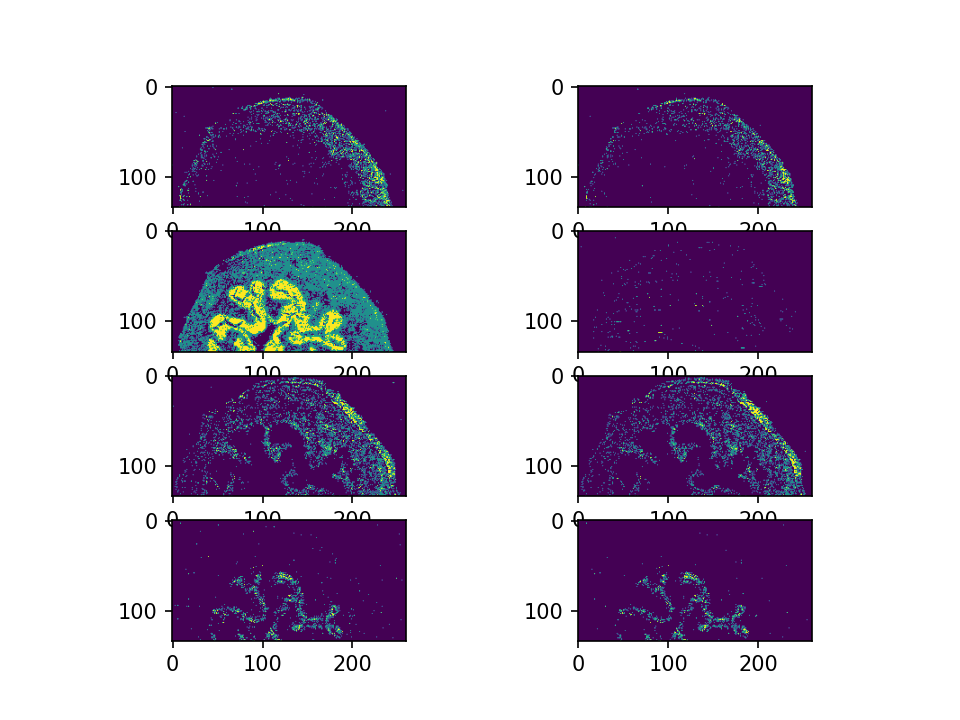

In [52]:
plt.figure()
for i in range(4):
    plt.subplot(421+2*i)
    plt.imshow(intensity_segmentation['bladder'][...,i])
    plt.subplot(422+2*i)
    plt.imshow(bladder_sdgmm_segmentation[...,i])


Save the spatial-DGMM segmentation results:

In [53]:
for n in image_names:
    masserstein_segmentation[n].dump(n+'_masserstein_sdgmm_segmentation.dmp')
# # For saving as tsv:
# for n in image_names:
#     with open(n + '_sdgmm.tsv', 'w') as h:
#         sgm_table = masserstein_segmentation[n]
#         crd = masserstein_coordinates[n]
#         header = ['X', 'Y'] + list(map(str, range(sgm_table.shape[1])))
#         h.write('\t'.join(header) + '\n')
#         for l1, l2 in zip(crd, sgm_table):
#             l1 = '\t'.join(list(map(str, l1)))
#             l2 = '\t'.join(list(map(str, l2)))
#             h.write(l1 + '\t' + l2 + '\n')

Now, generate and save images and segmentations for each lipid:

<IPython.core.display.Javascript object>


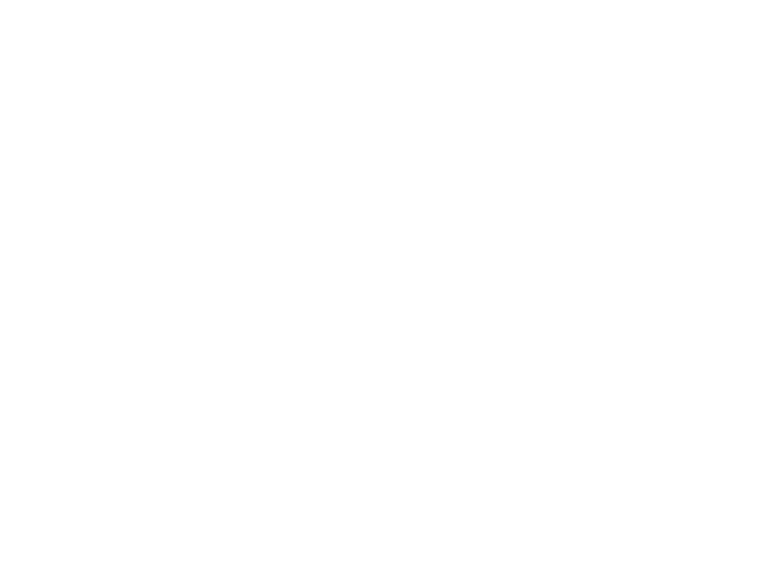

<IPython.core.display.Javascript object>


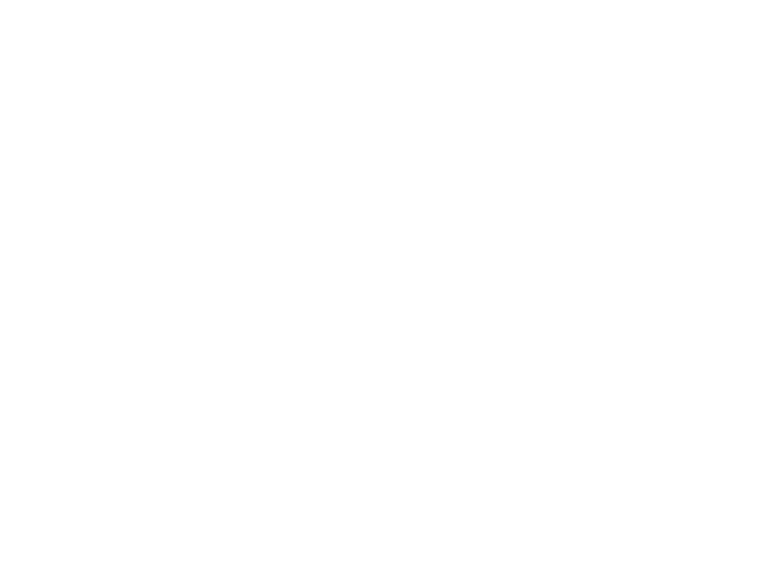

<IPython.core.display.Javascript object>


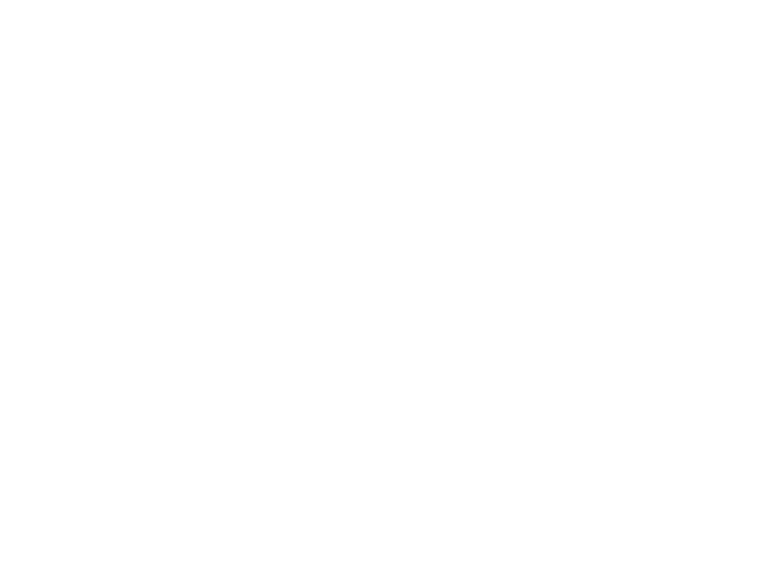

<IPython.core.display.Javascript object>


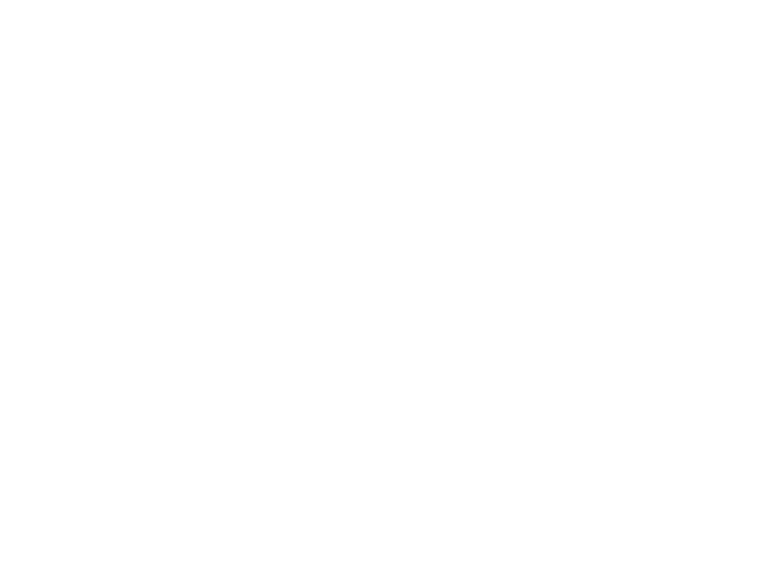

<IPython.core.display.Javascript object>


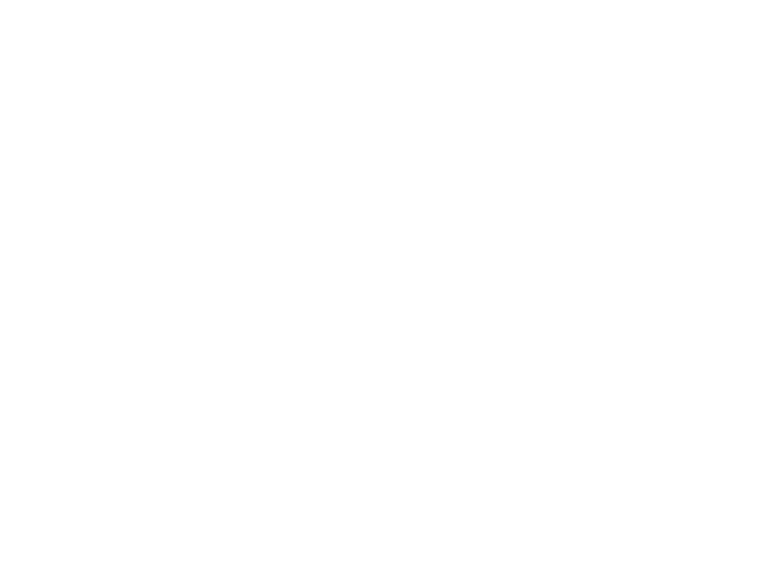

<IPython.core.display.Javascript object>


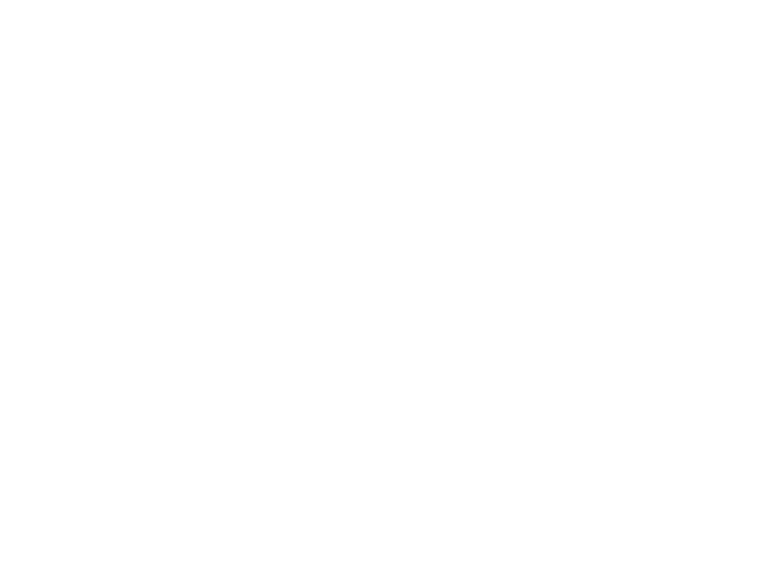

<IPython.core.display.Javascript object>


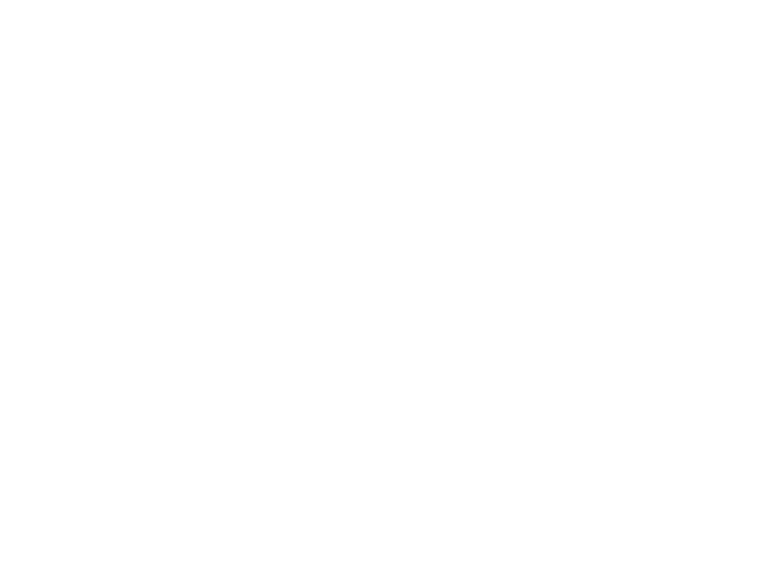

<IPython.core.display.Javascript object>


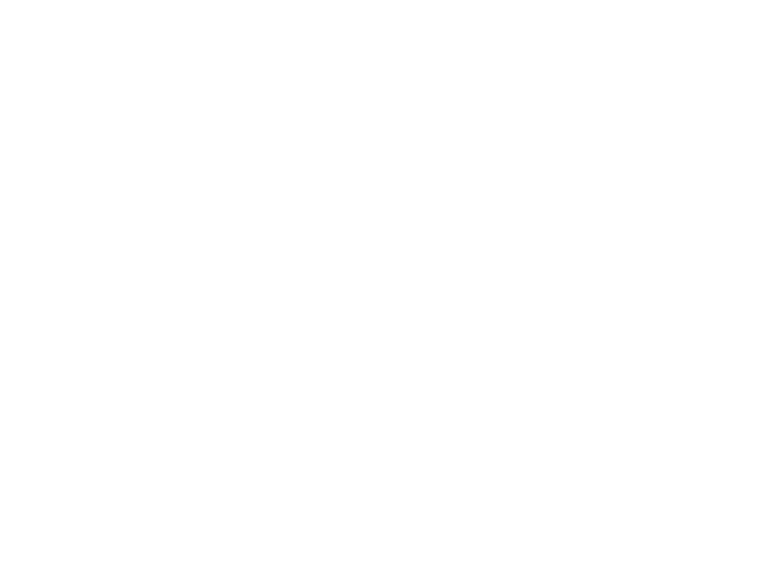

<IPython.core.display.Javascript object>


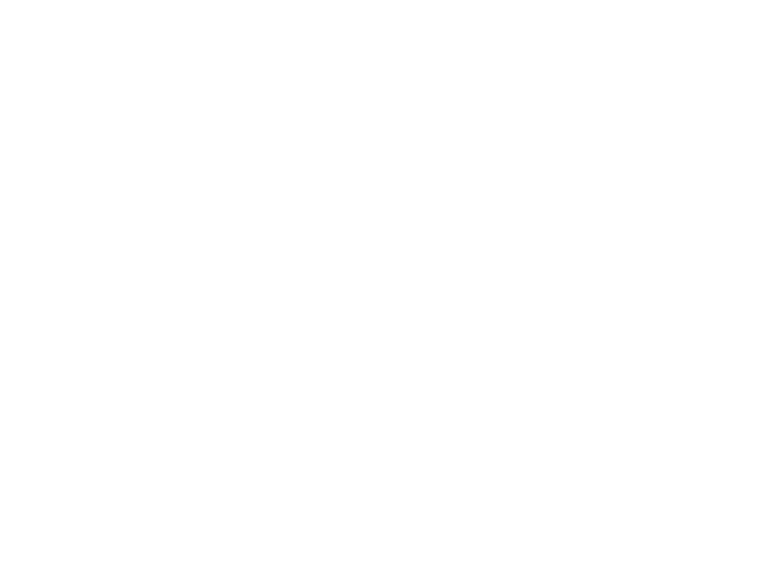

<IPython.core.display.Javascript object>


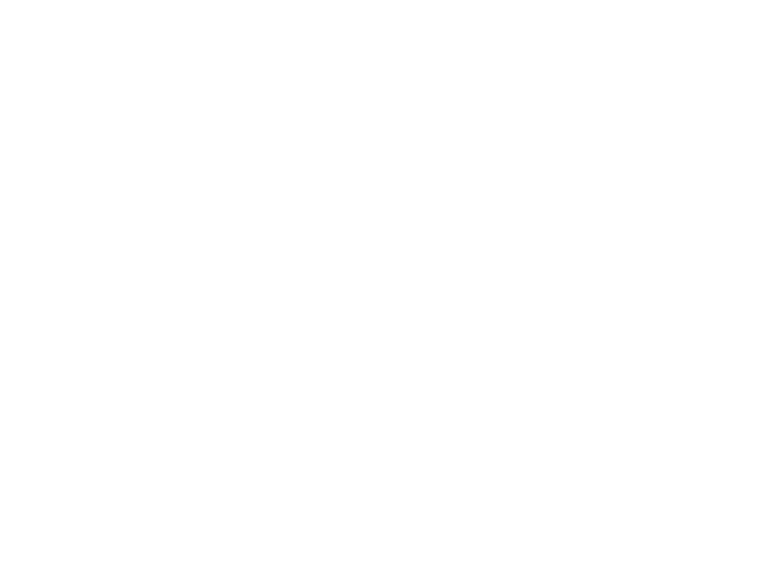

<IPython.core.display.Javascript object>


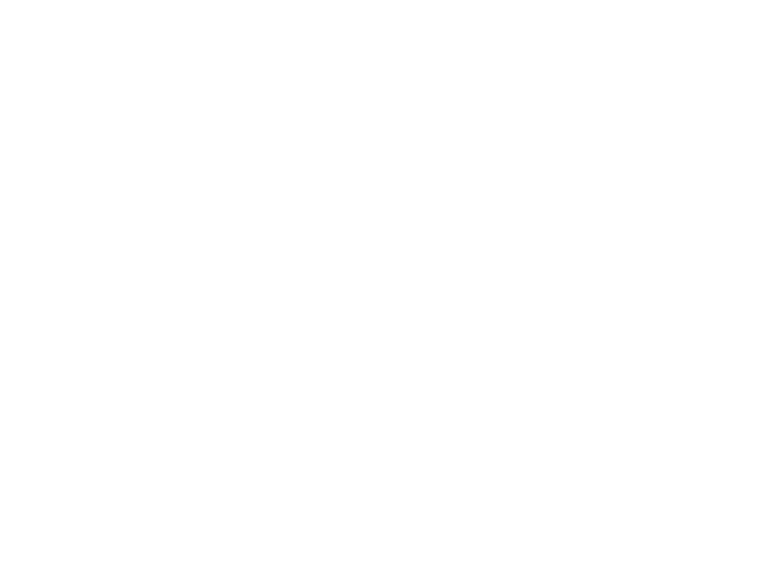

<IPython.core.display.Javascript object>


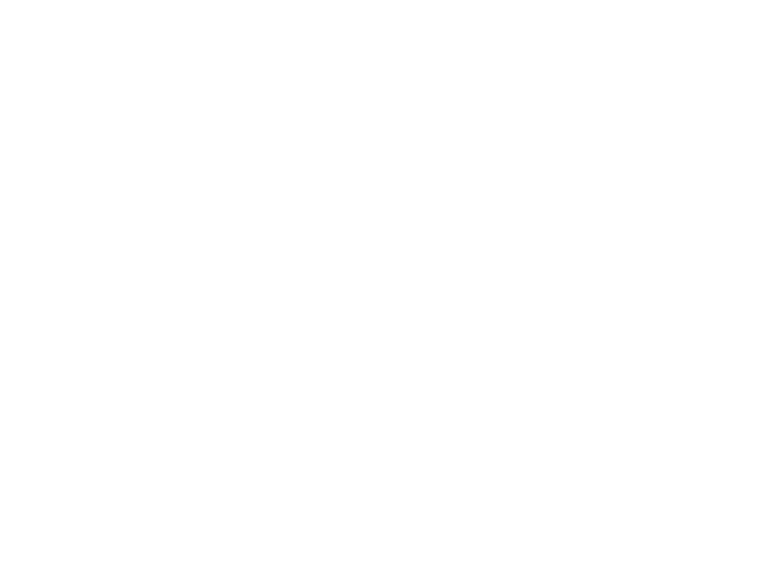

<IPython.core.display.Javascript object>


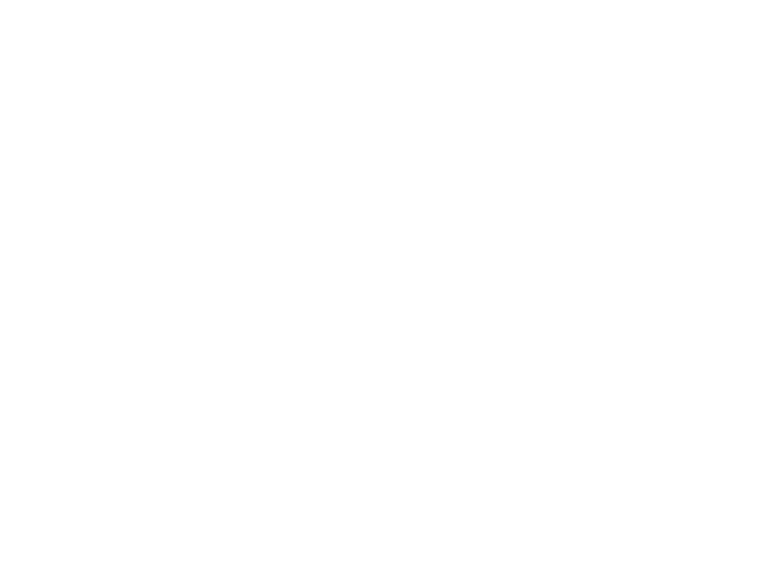

<IPython.core.display.Javascript object>


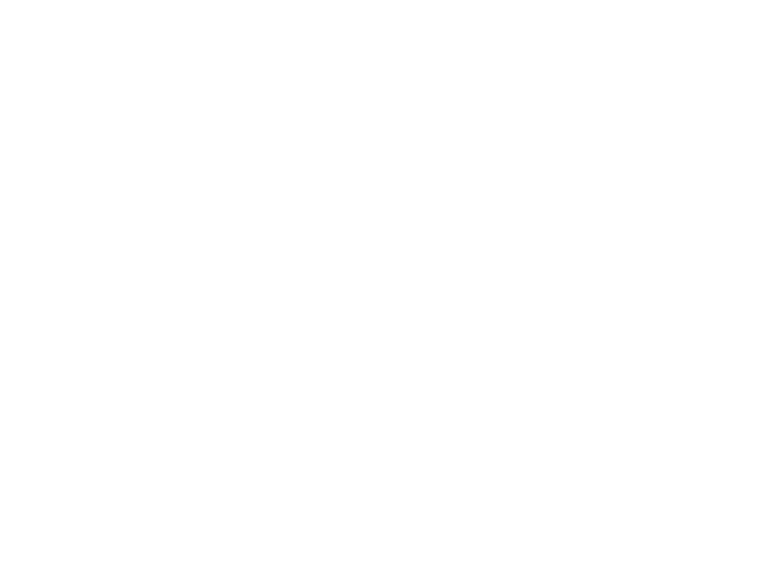

<IPython.core.display.Javascript object>


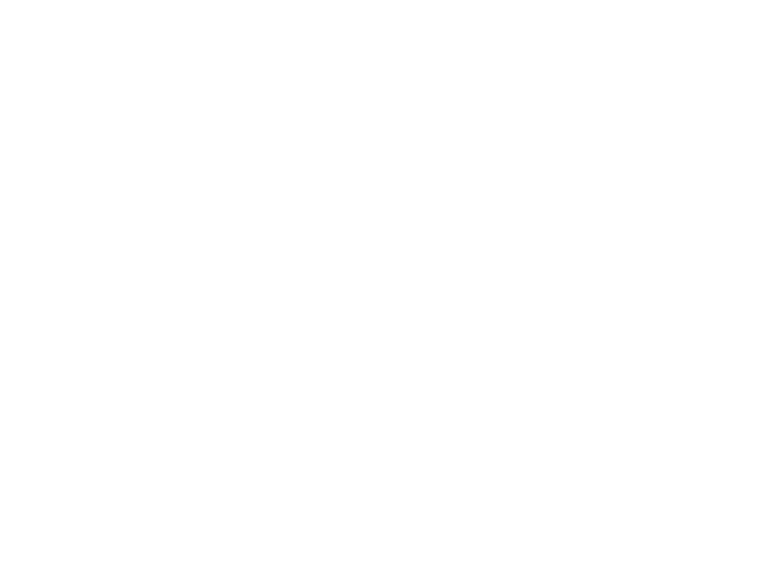

<IPython.core.display.Javascript object>


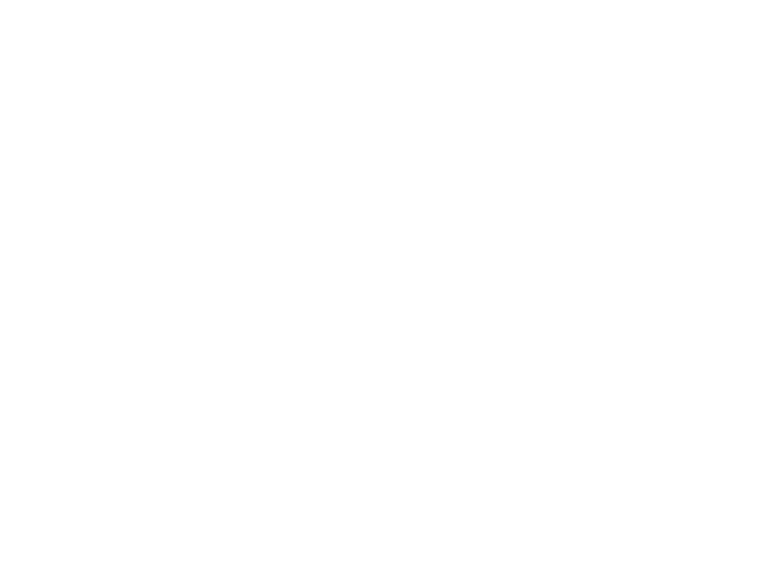

<IPython.core.display.Javascript object>


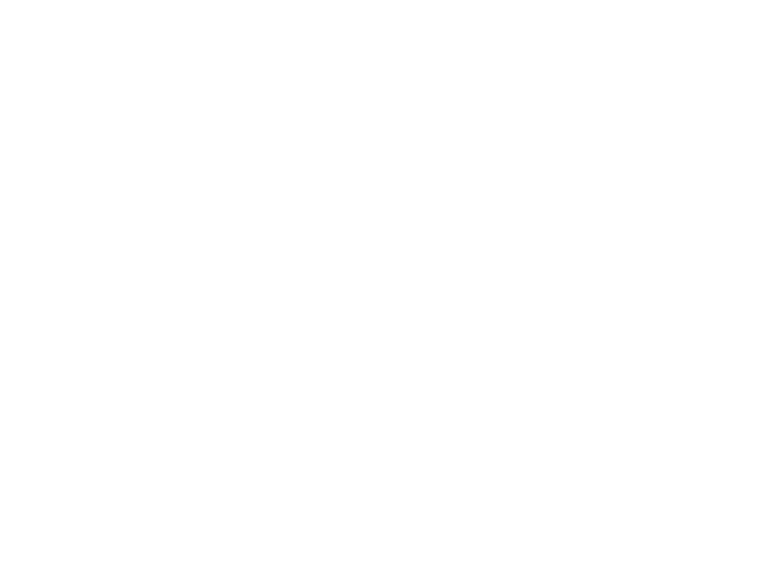

<IPython.core.display.Javascript object>


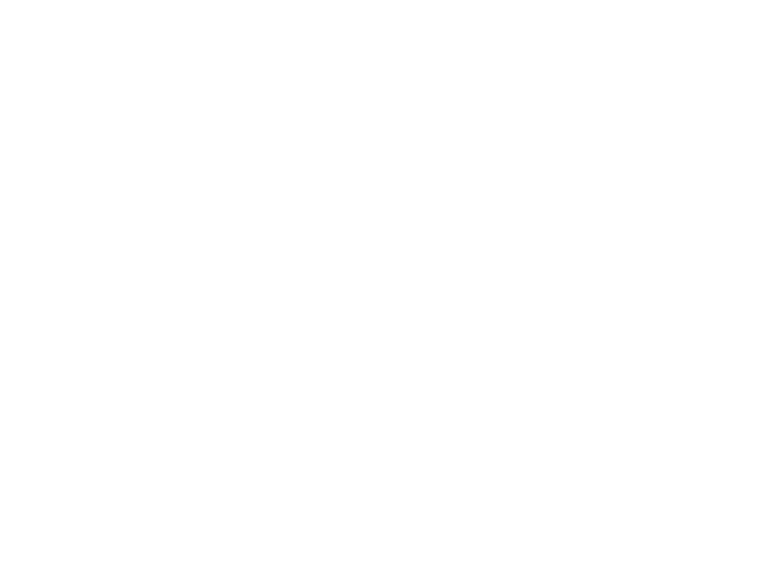

<IPython.core.display.Javascript object>


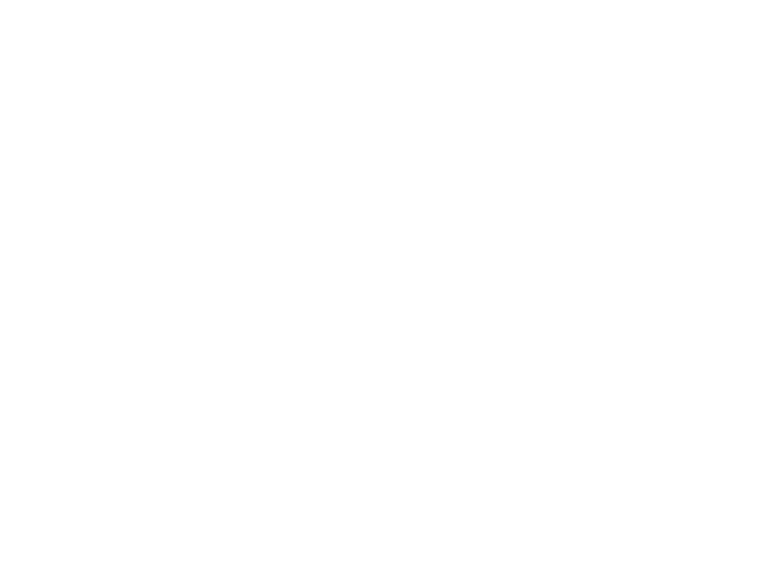

<IPython.core.display.Javascript object>


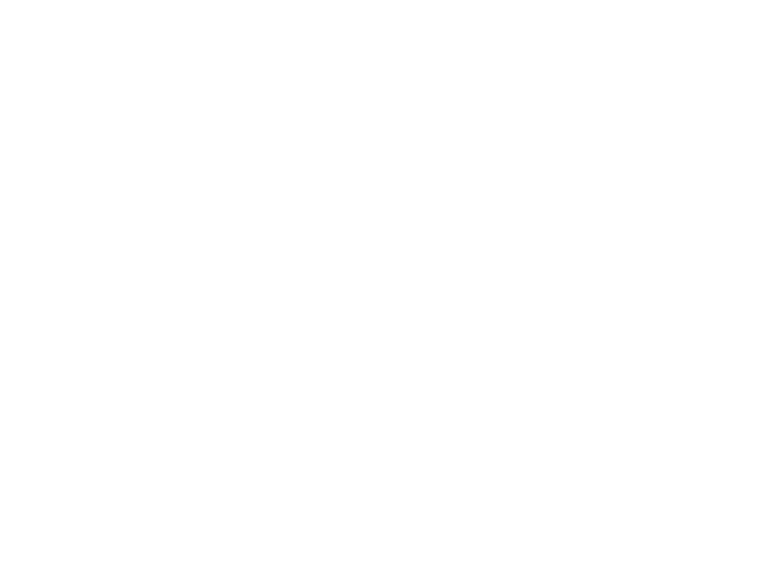

<IPython.core.display.Javascript object>


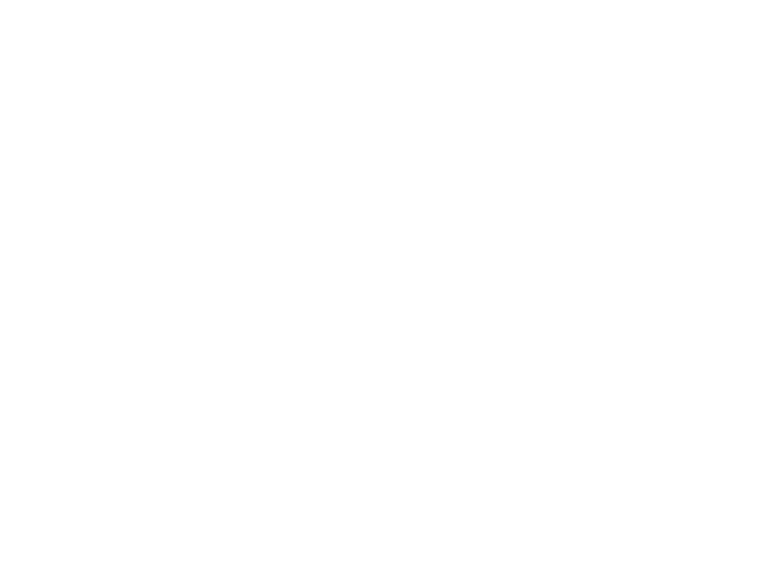

<IPython.core.display.Javascript object>


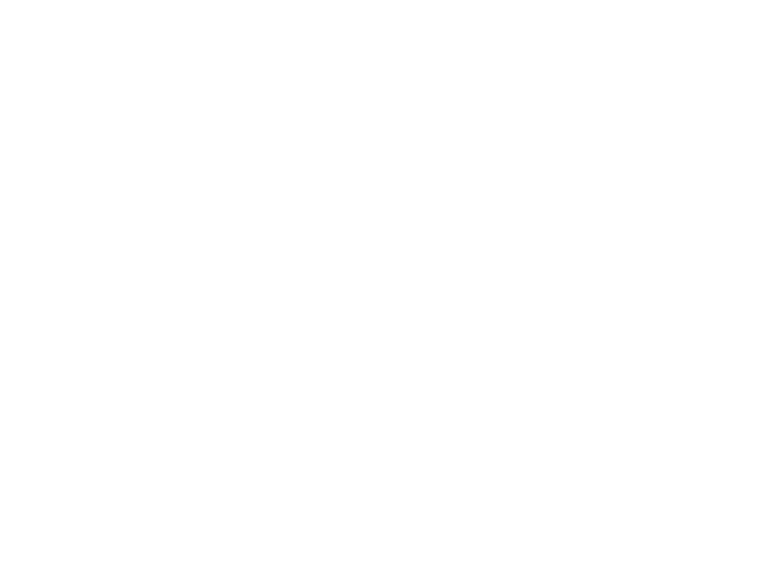

<IPython.core.display.Javascript object>


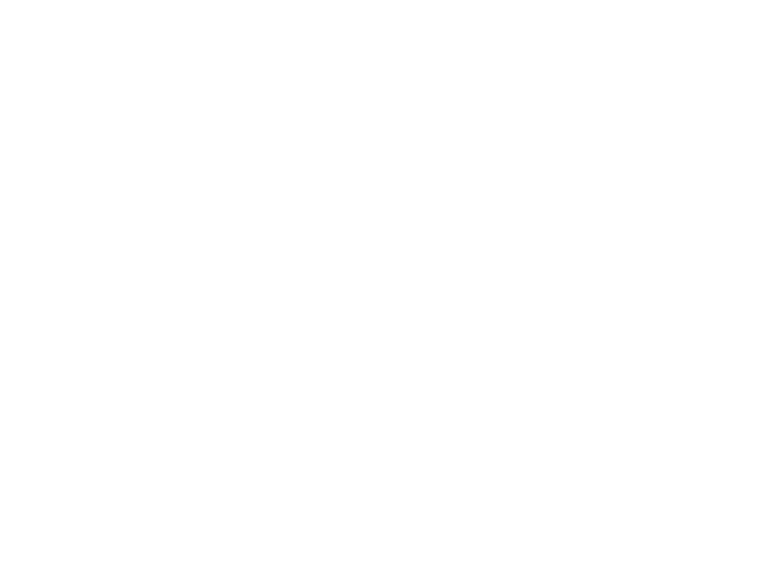

<IPython.core.display.Javascript object>


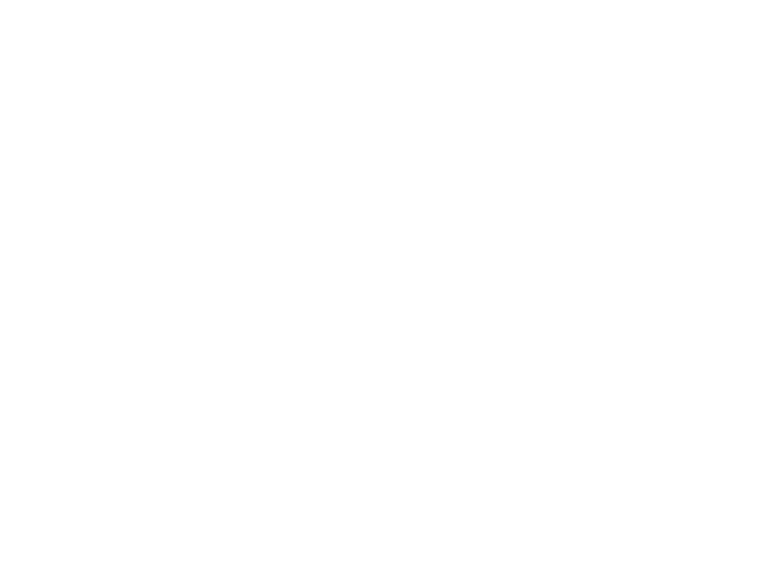

<IPython.core.display.Javascript object>


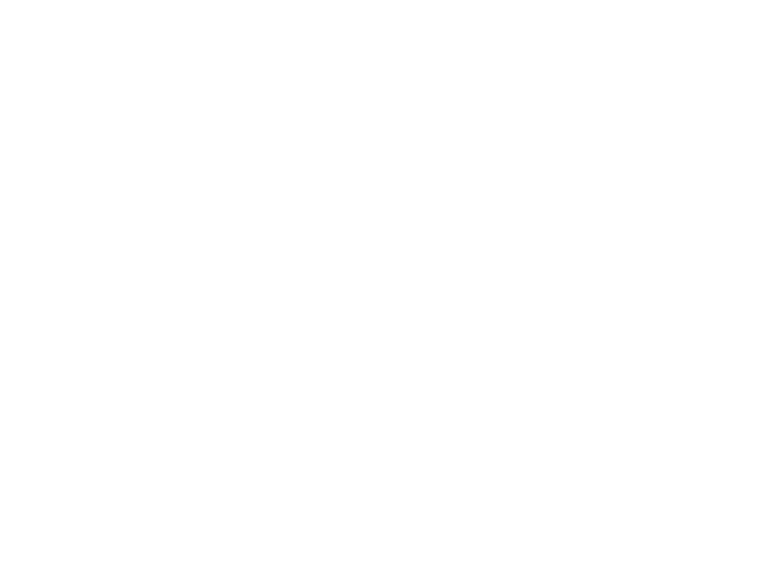

<IPython.core.display.Javascript object>


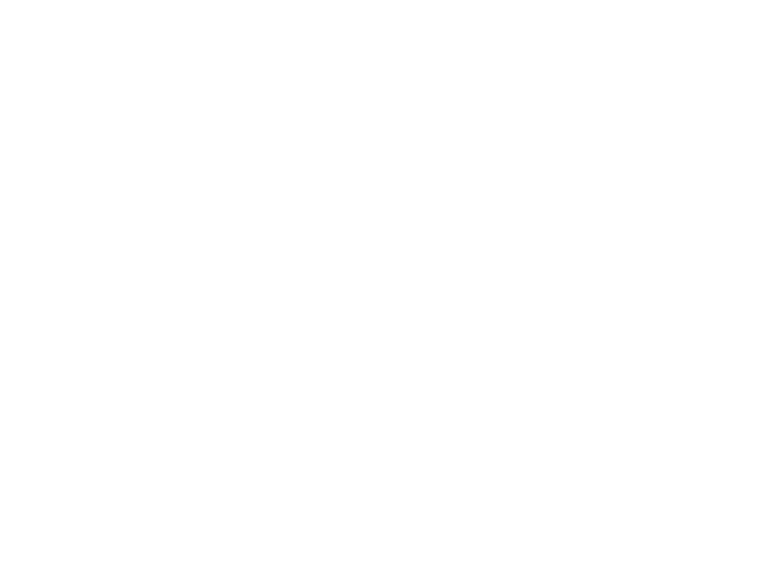

<IPython.core.display.Javascript object>


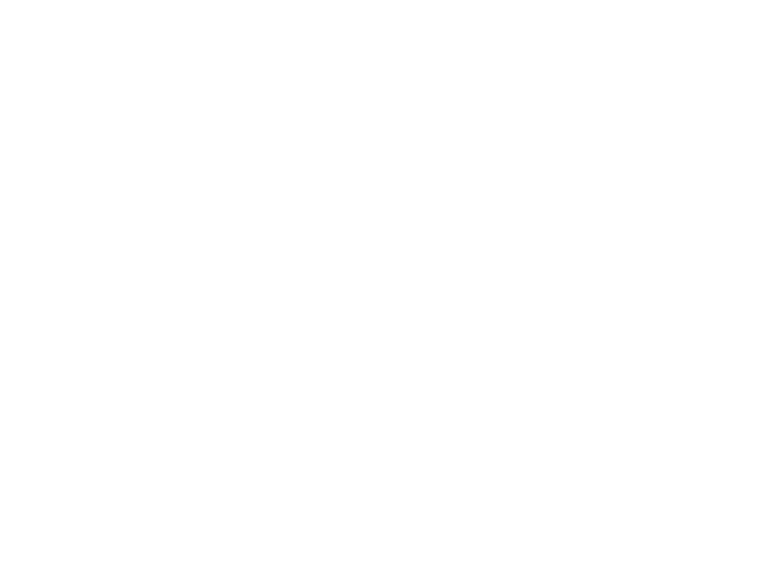

<IPython.core.display.Javascript object>


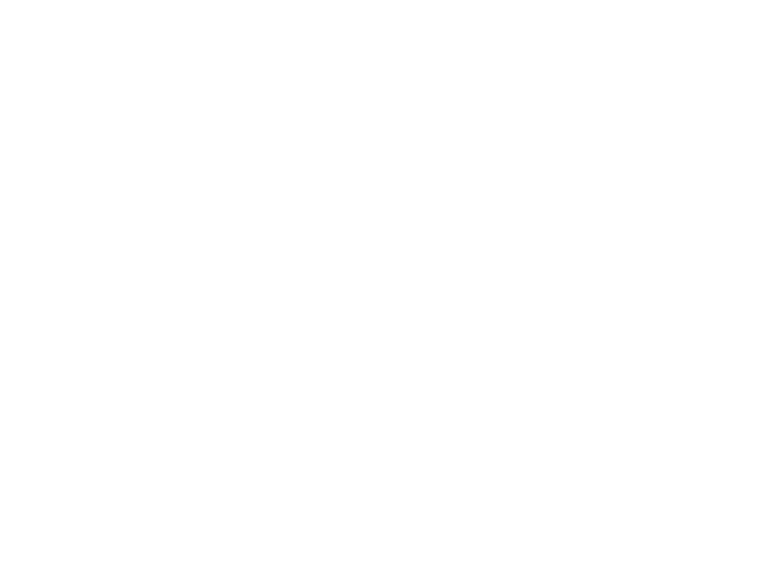

<IPython.core.display.Javascript object>


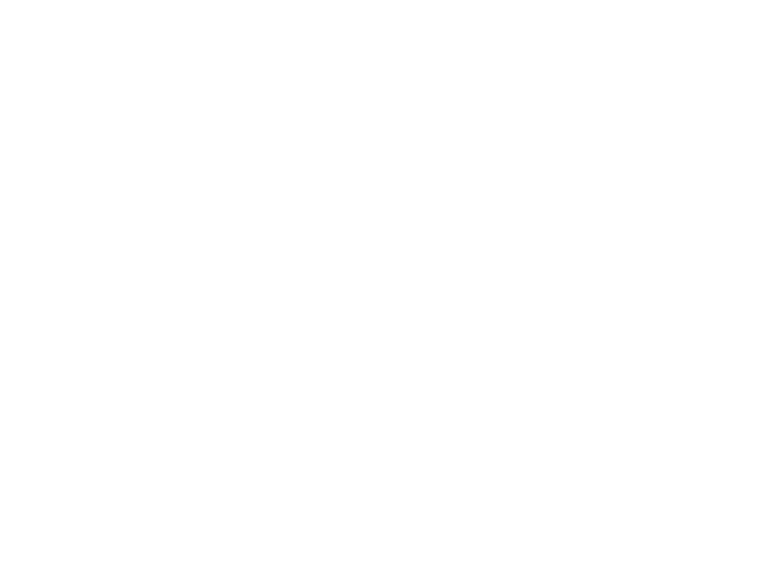

<IPython.core.display.Javascript object>


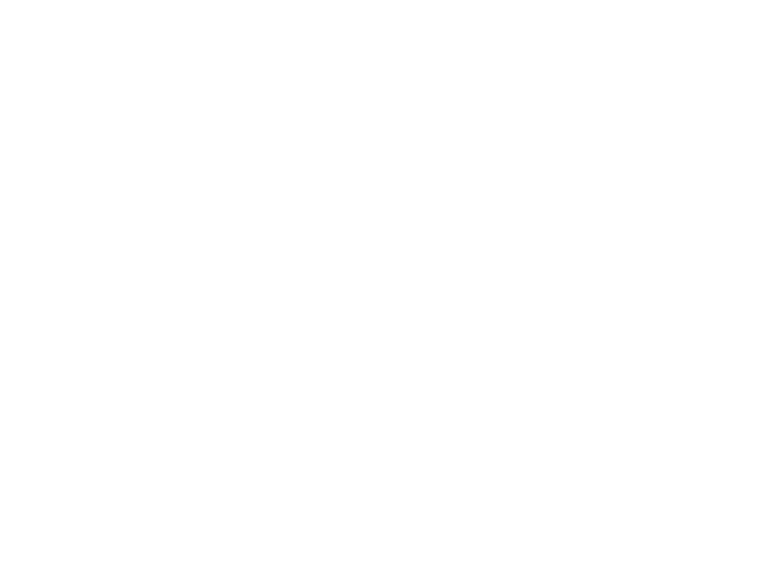

<IPython.core.display.Javascript object>


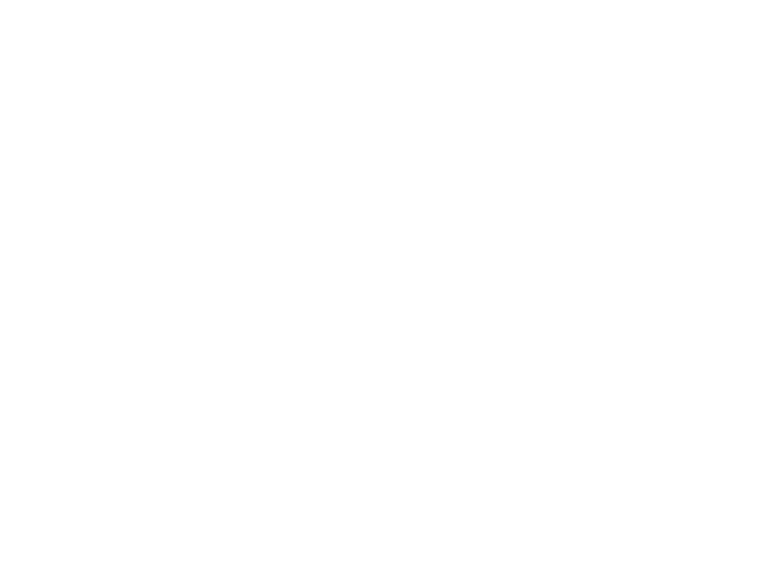

<IPython.core.display.Javascript object>


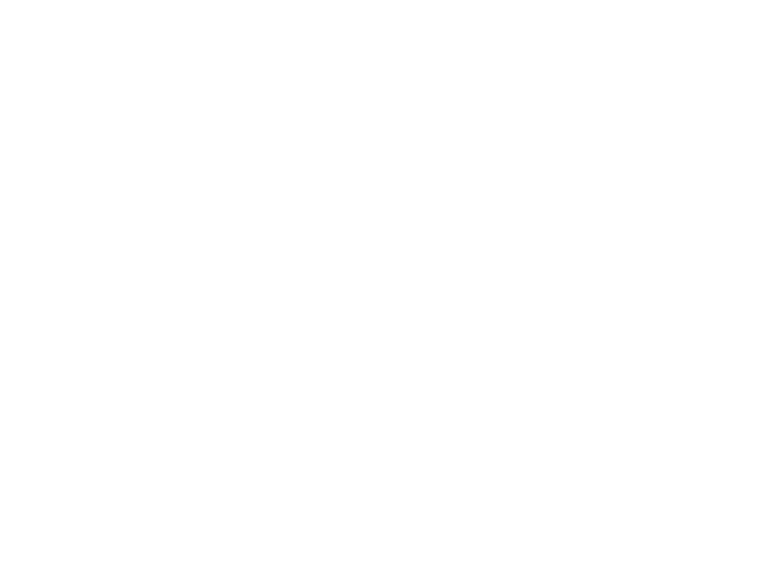

<IPython.core.display.Javascript object>


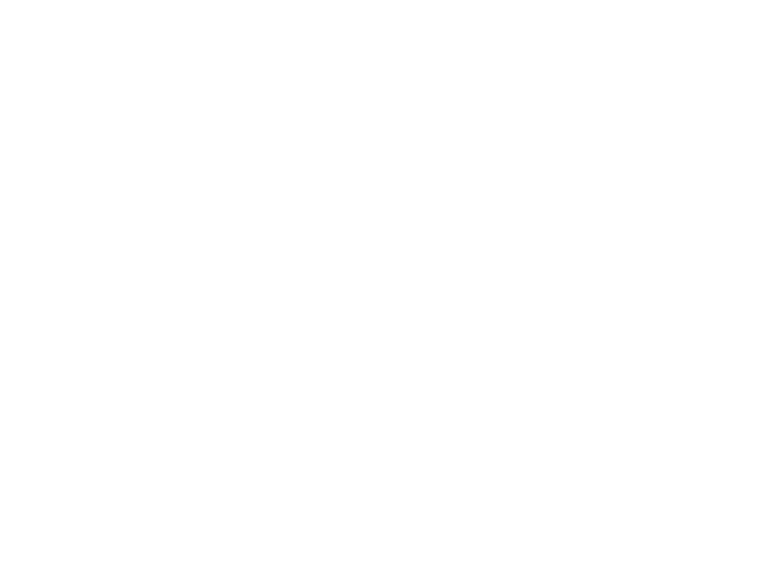

<IPython.core.display.Javascript object>


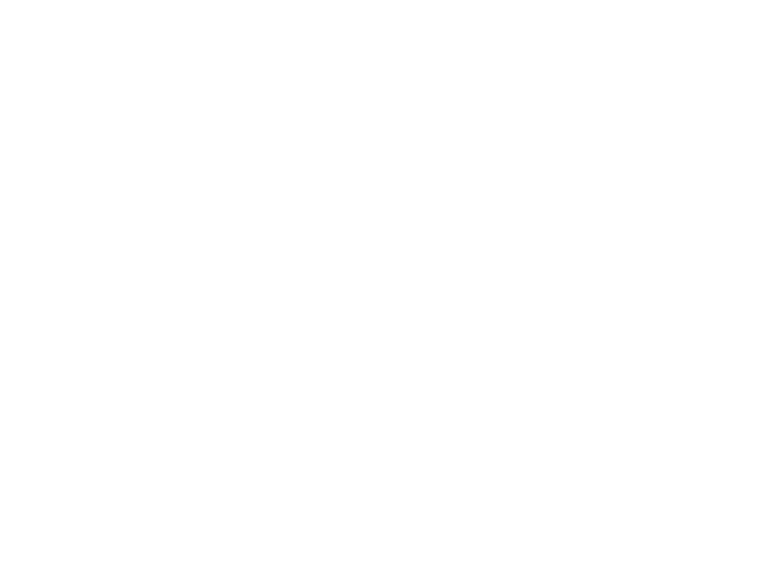

<IPython.core.display.Javascript object>


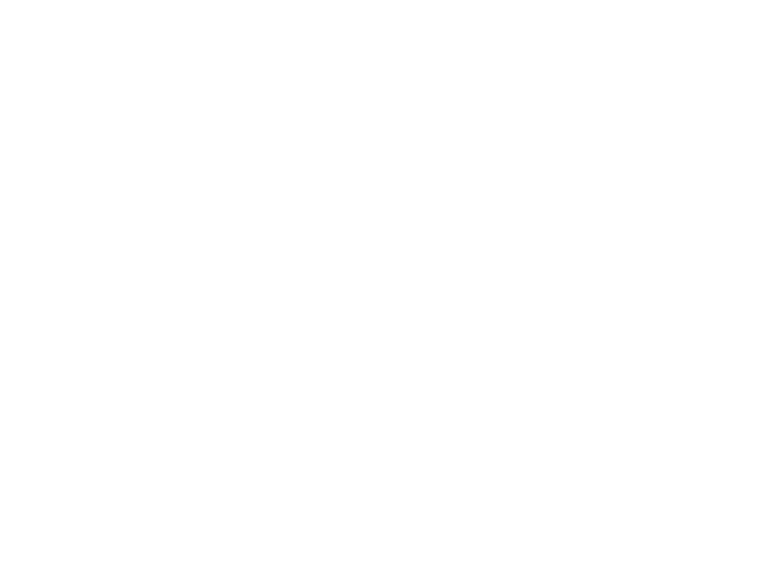

<IPython.core.display.Javascript object>


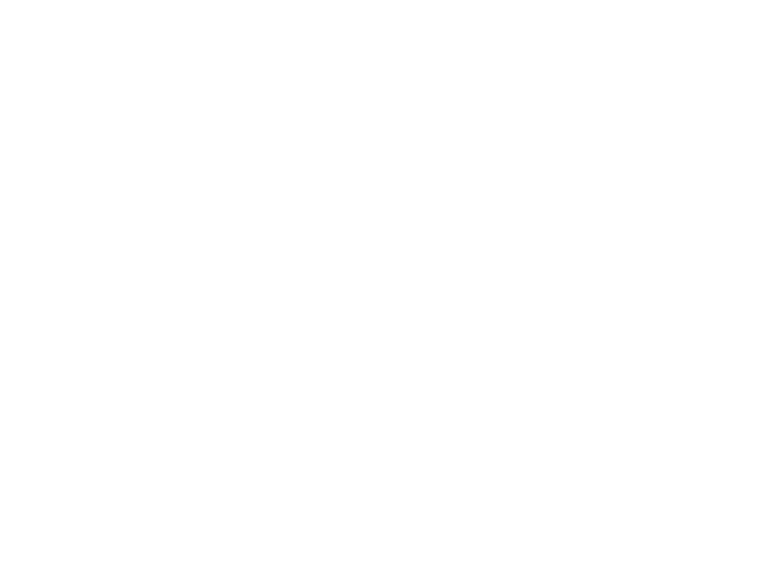

<IPython.core.display.Javascript object>


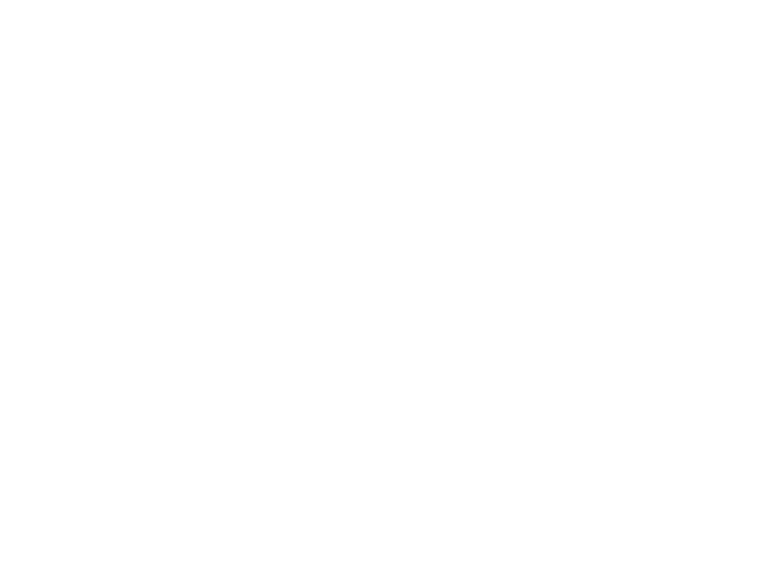

<IPython.core.display.Javascript object>


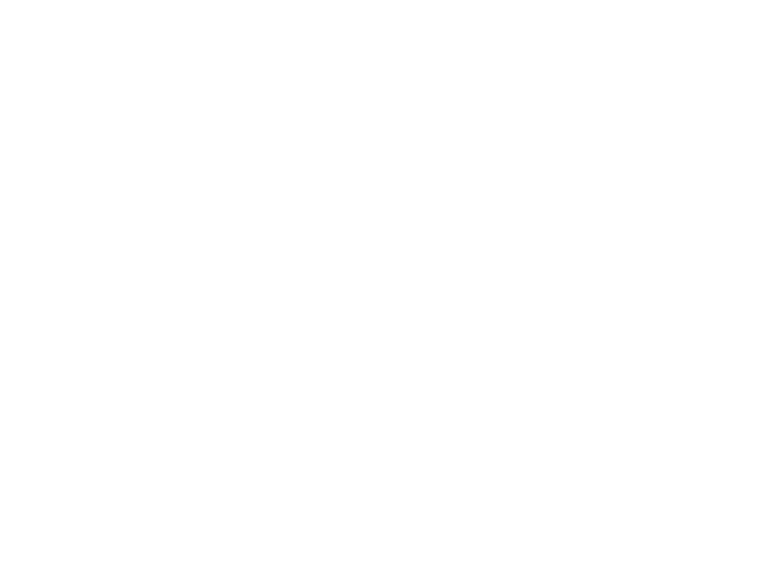

<IPython.core.display.Javascript object>


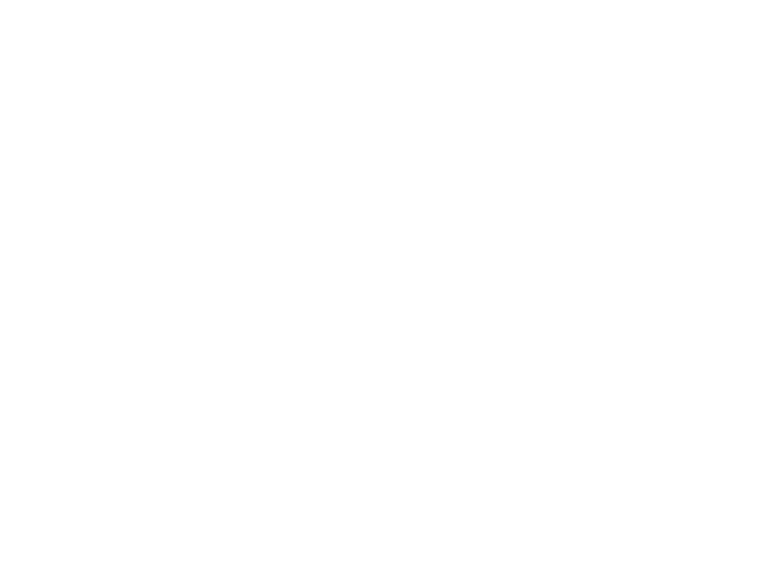

<IPython.core.display.Javascript object>


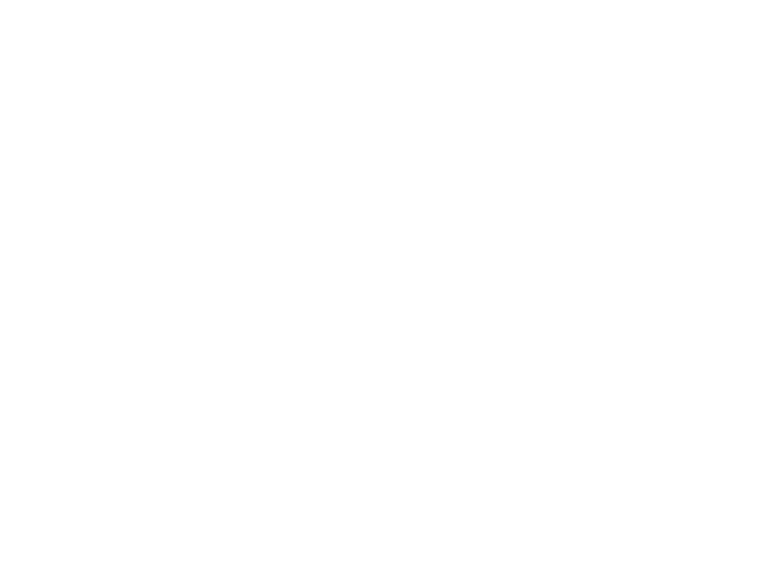

<IPython.core.display.Javascript object>


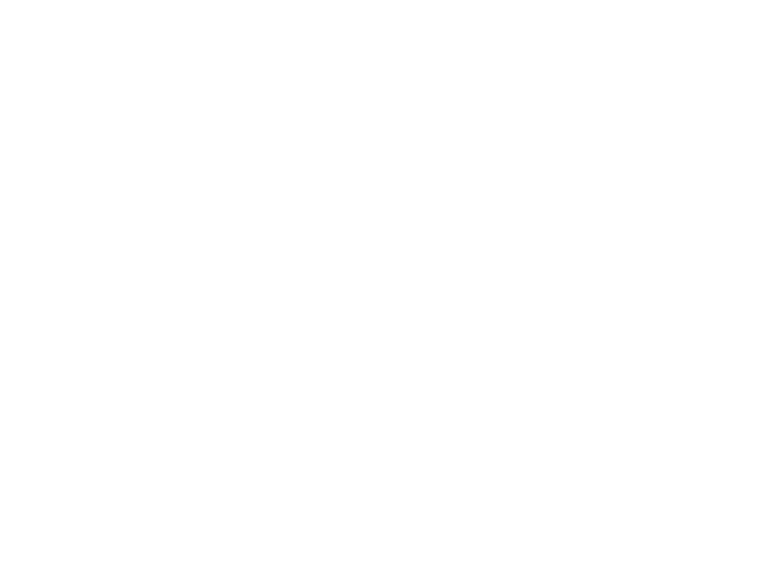

<IPython.core.display.Javascript object>


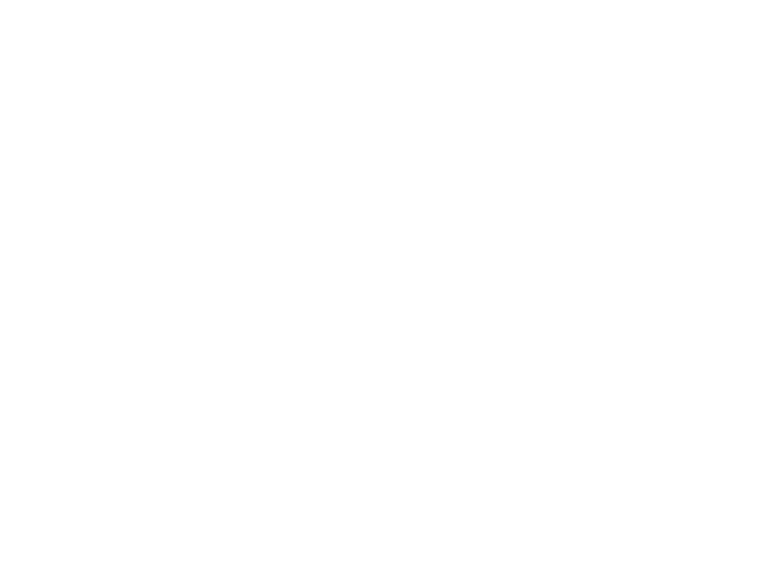

<IPython.core.display.Javascript object>


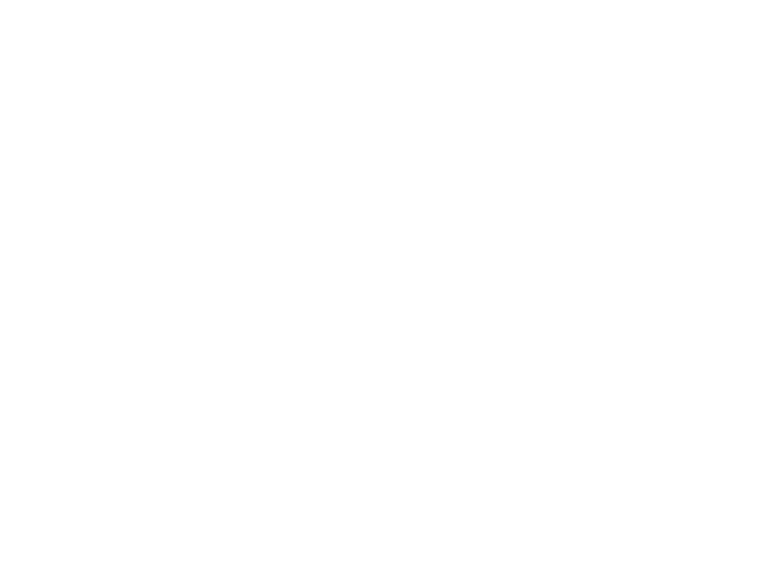

<IPython.core.display.Javascript object>


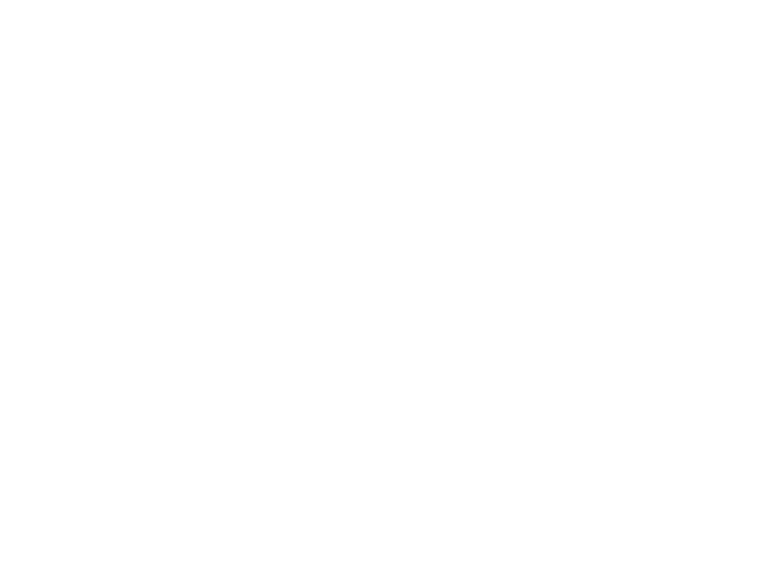

<IPython.core.display.Javascript object>


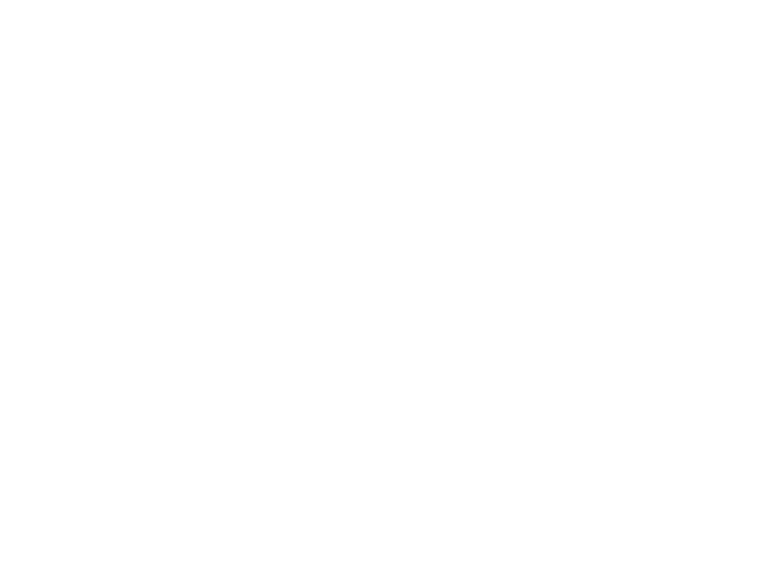

<IPython.core.display.Javascript object>


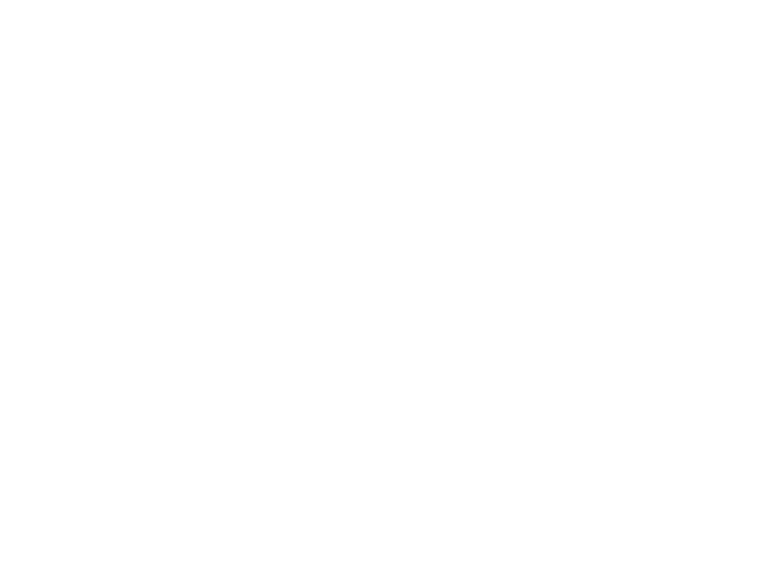

<IPython.core.display.Javascript object>


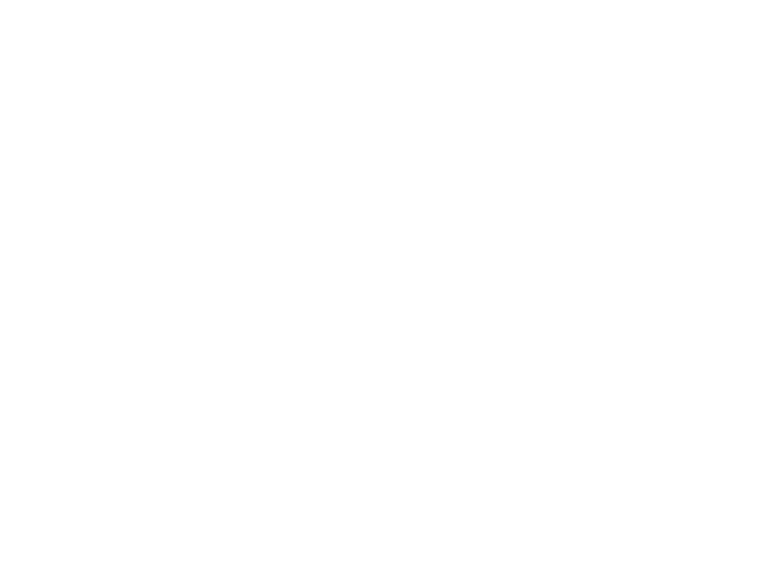

<IPython.core.display.Javascript object>


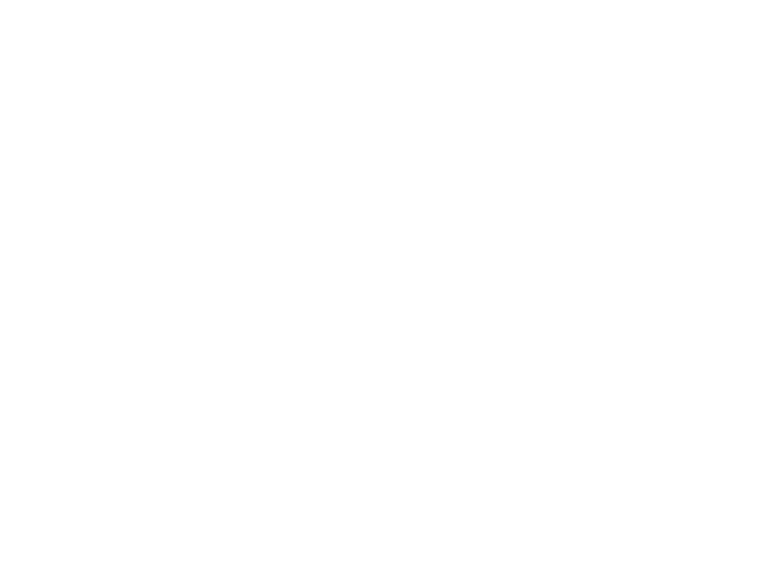

<IPython.core.display.Javascript object>


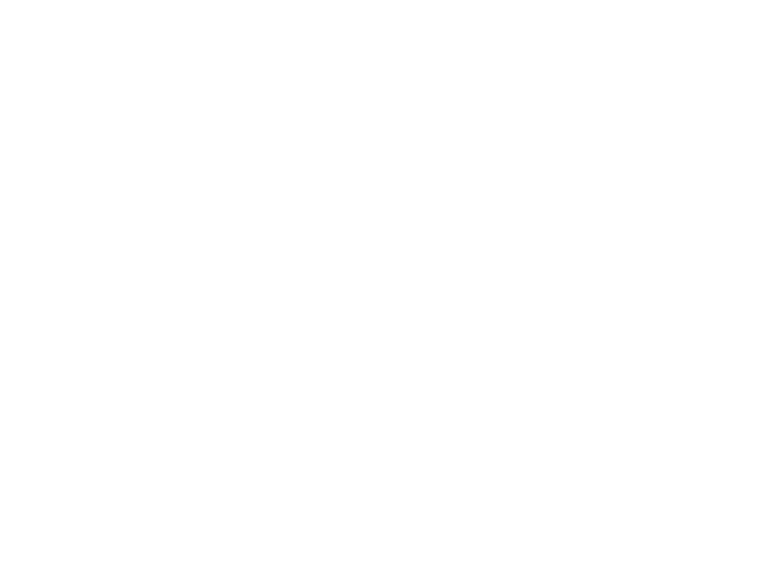

<IPython.core.display.Javascript object>


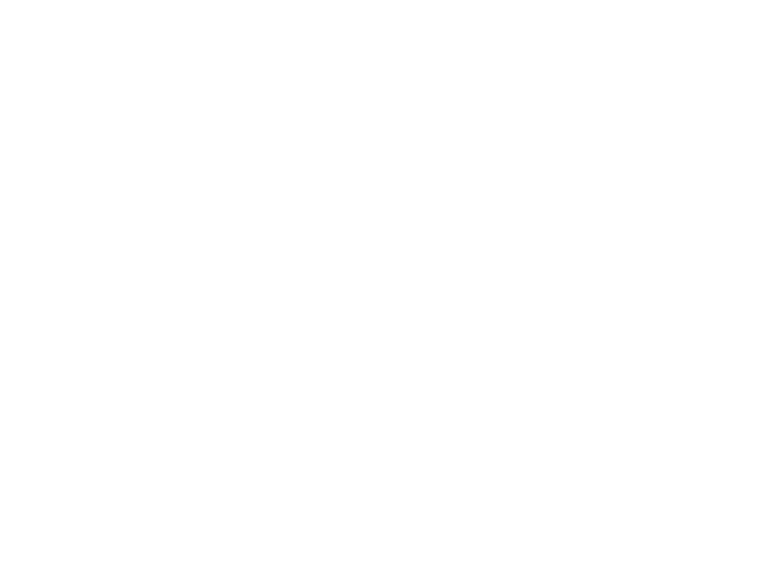

<IPython.core.display.Javascript object>


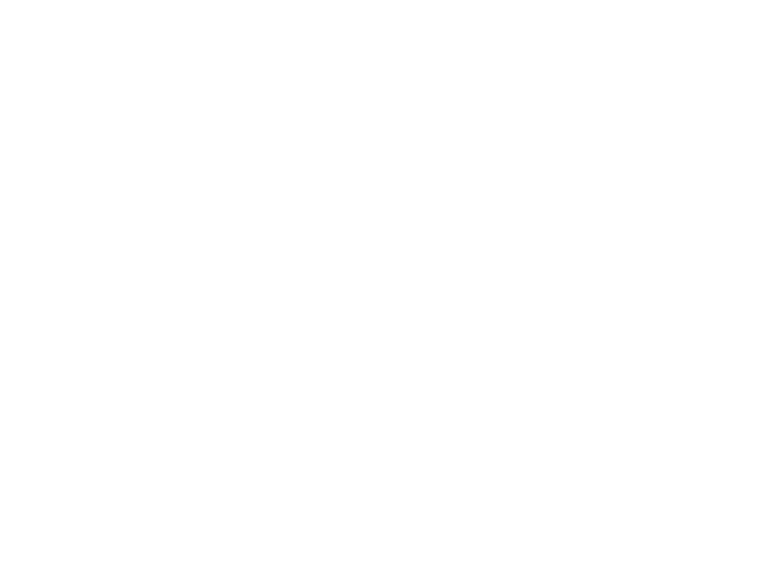

<IPython.core.display.Javascript object>


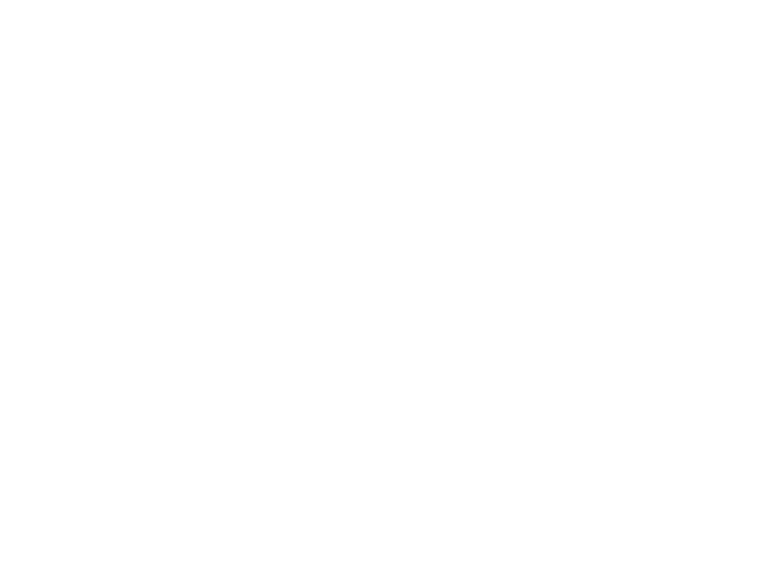

<IPython.core.display.Javascript object>


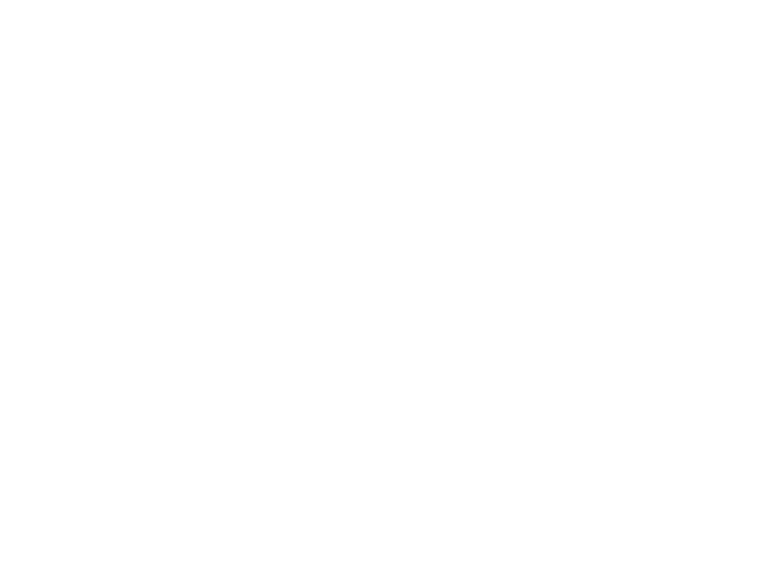

<IPython.core.display.Javascript object>


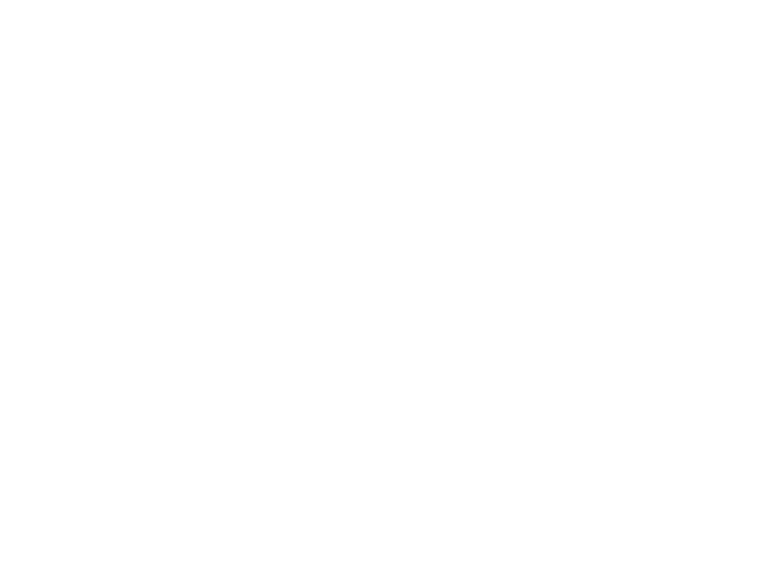

<IPython.core.display.Javascript object>


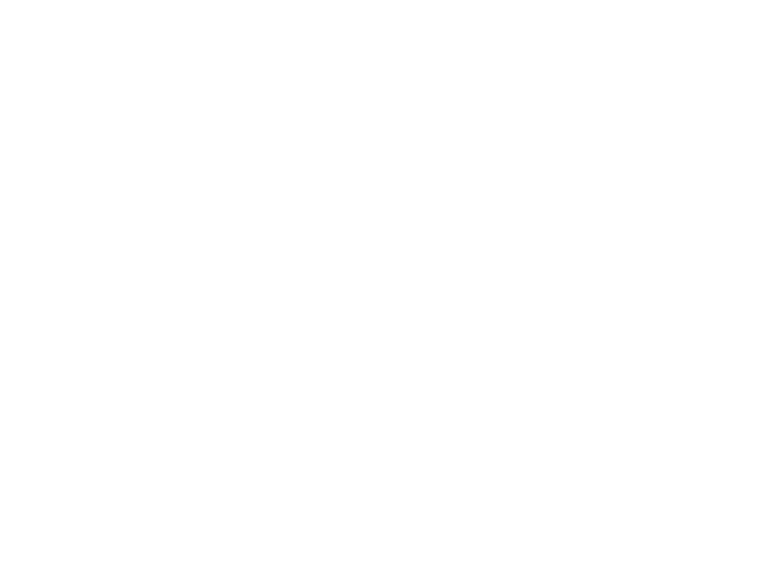

<IPython.core.display.Javascript object>


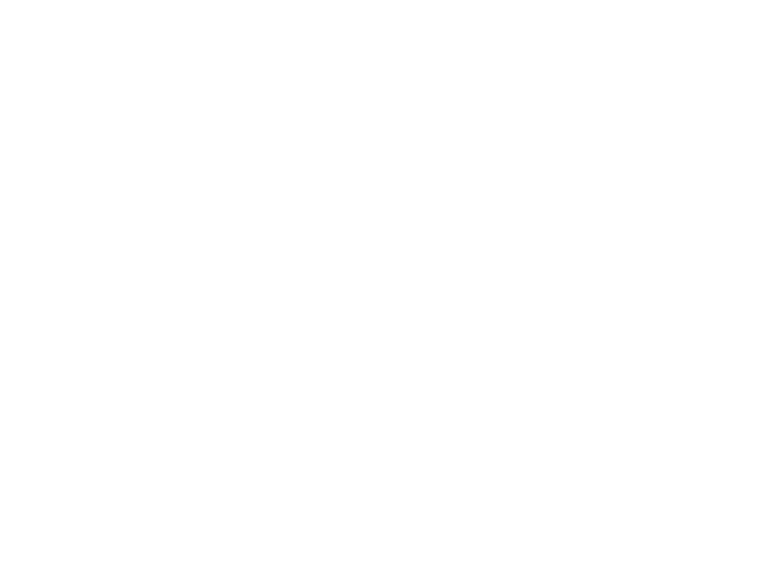

<IPython.core.display.Javascript object>


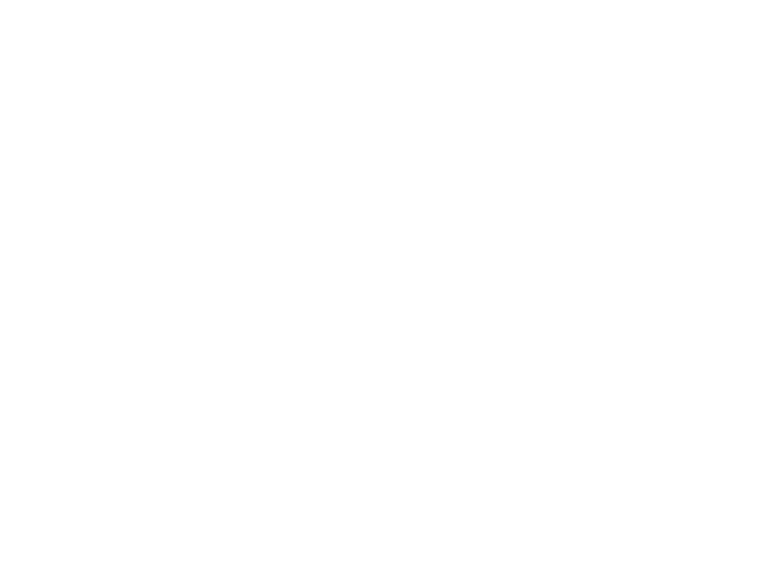

<IPython.core.display.Javascript object>


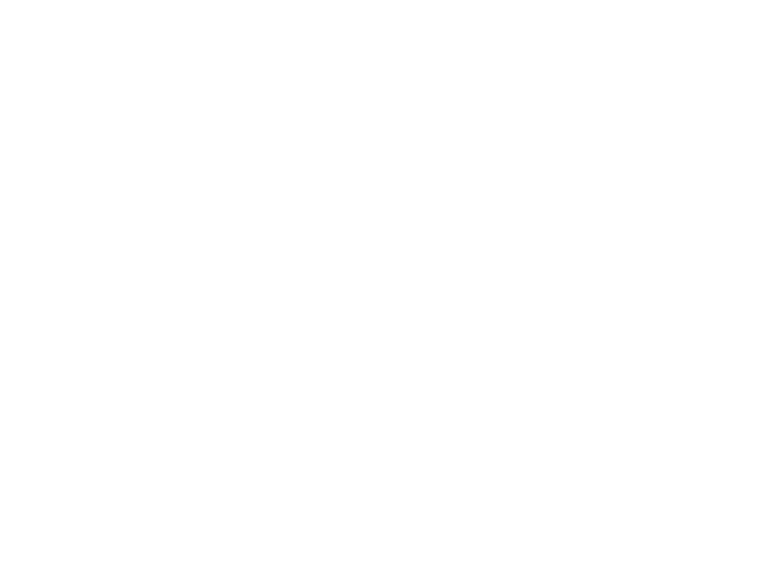

<IPython.core.display.Javascript object>


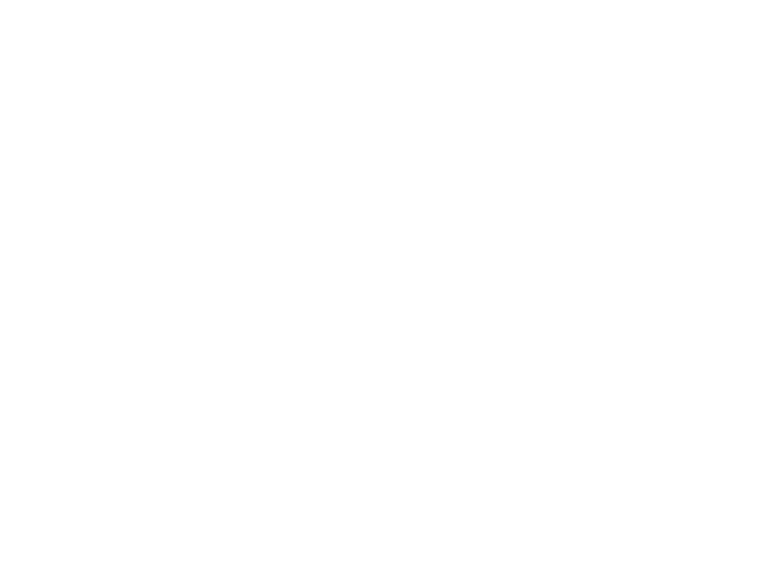

<IPython.core.display.Javascript object>


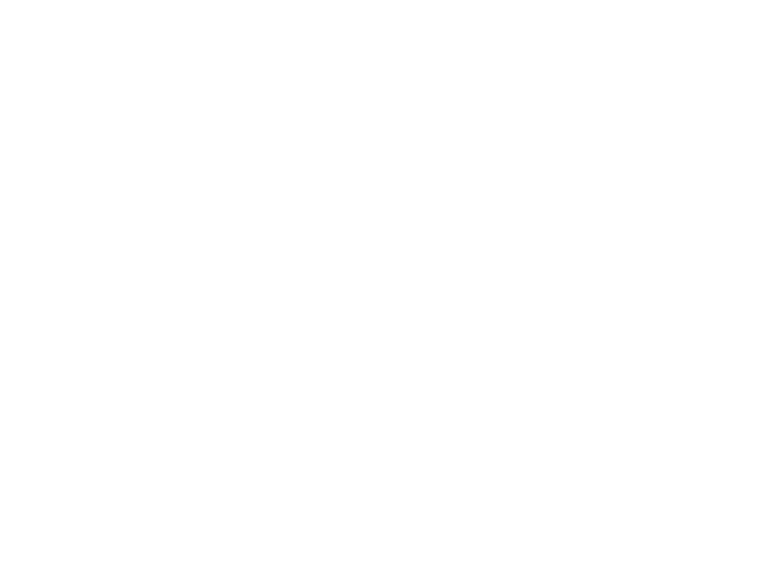

<IPython.core.display.Javascript object>


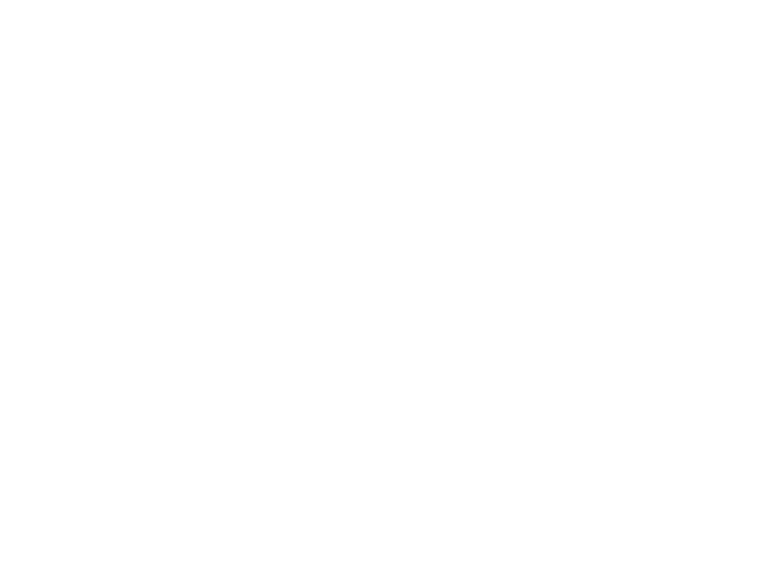

<IPython.core.display.Javascript object>


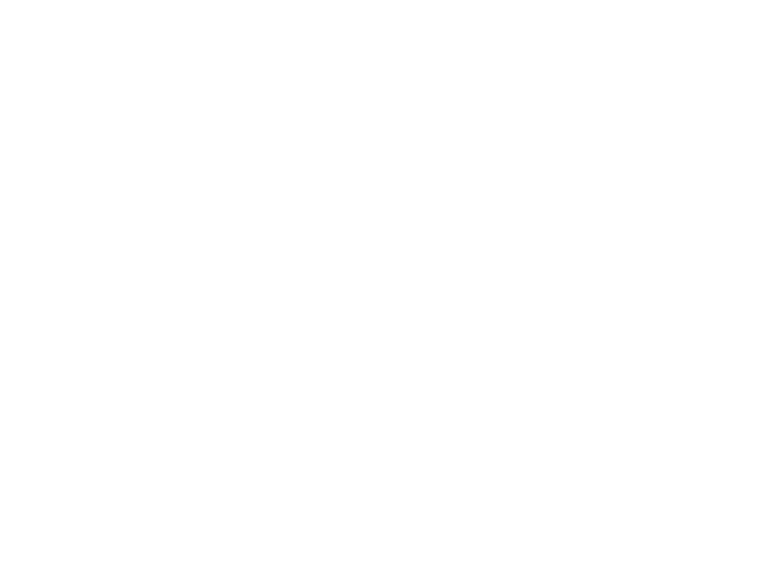

<IPython.core.display.Javascript object>


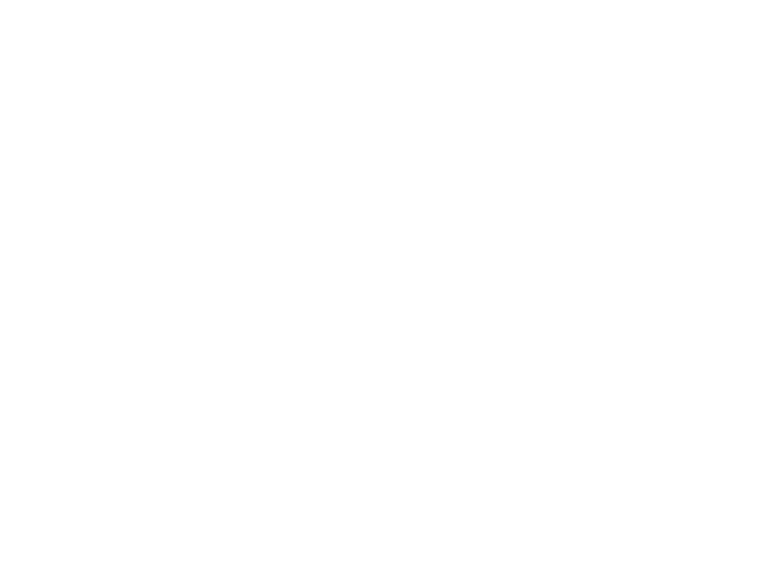

<IPython.core.display.Javascript object>


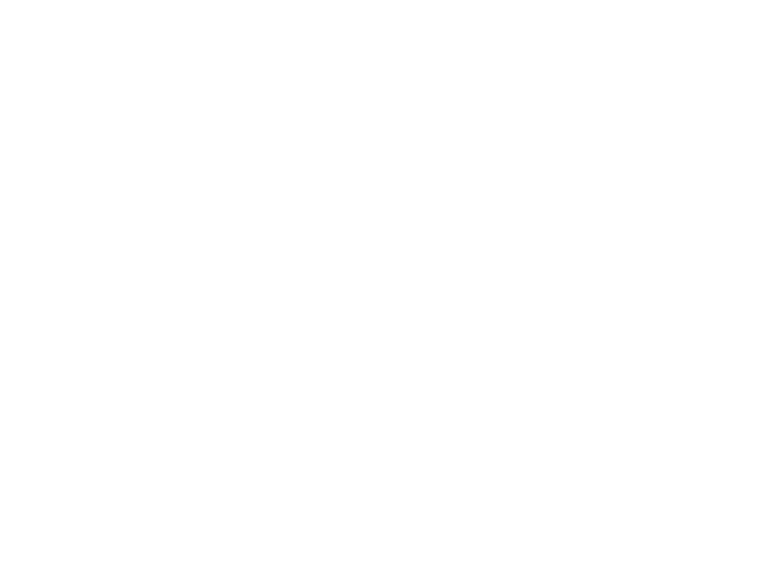

<IPython.core.display.Javascript object>


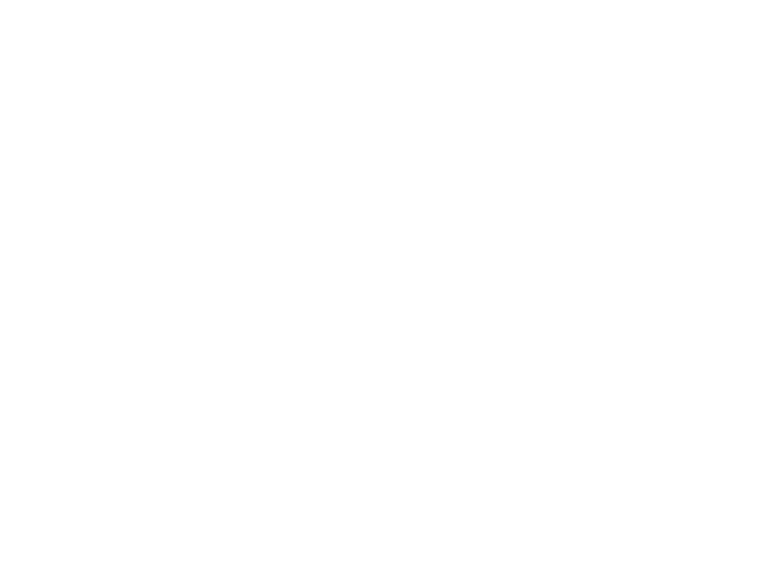

<IPython.core.display.Javascript object>


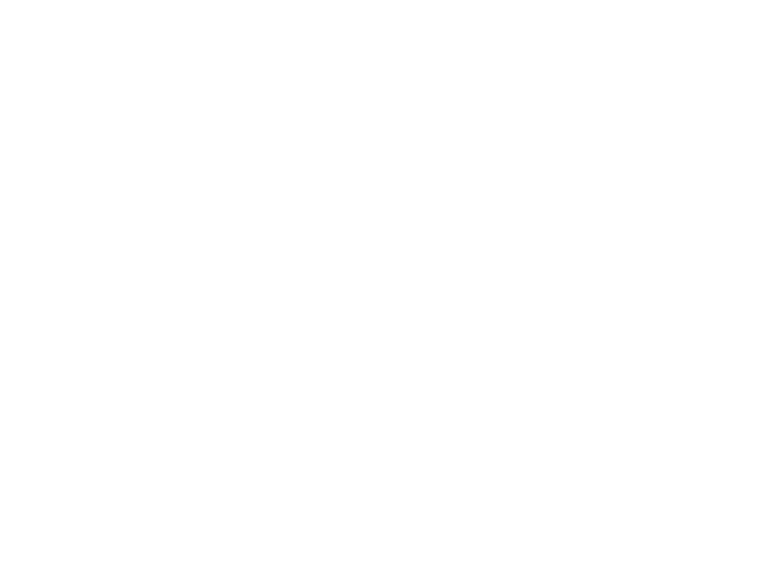

<IPython.core.display.Javascript object>


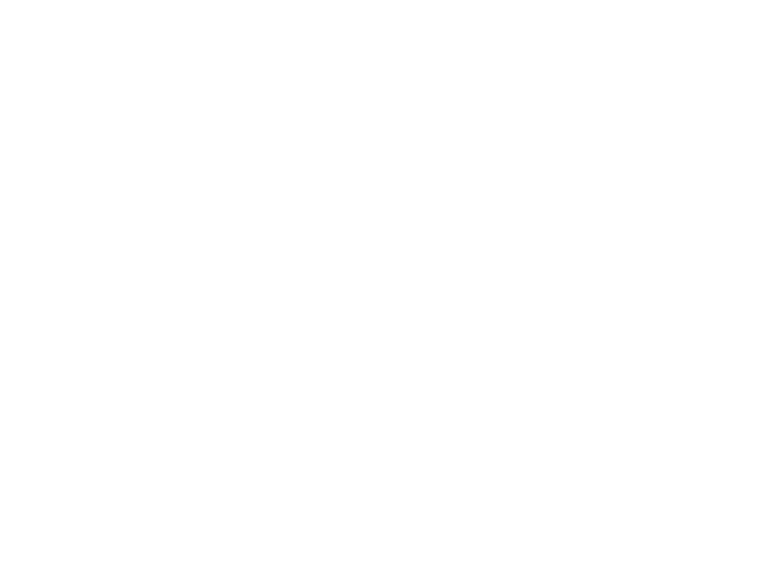

<IPython.core.display.Javascript object>


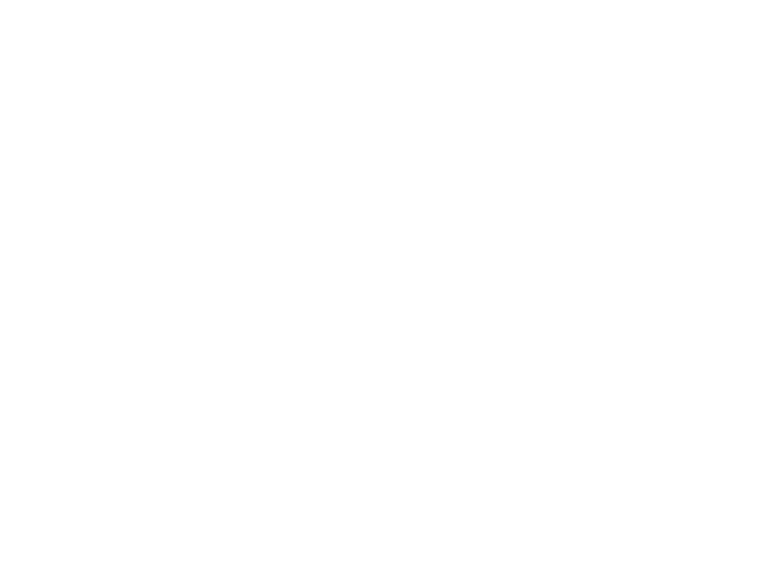

<IPython.core.display.Javascript object>


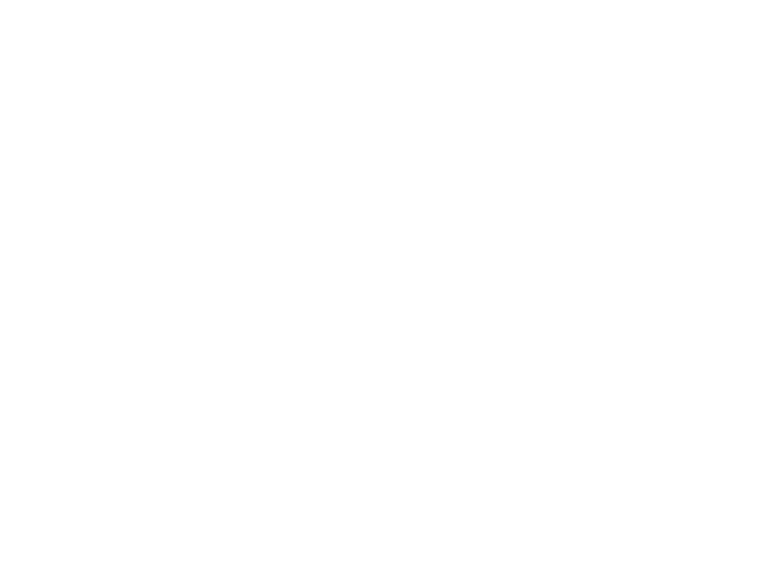

<IPython.core.display.Javascript object>


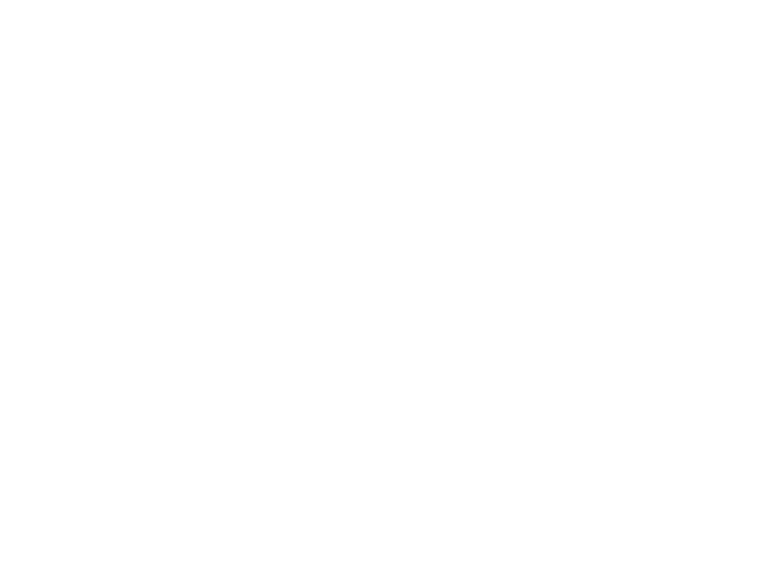

<IPython.core.display.Javascript object>


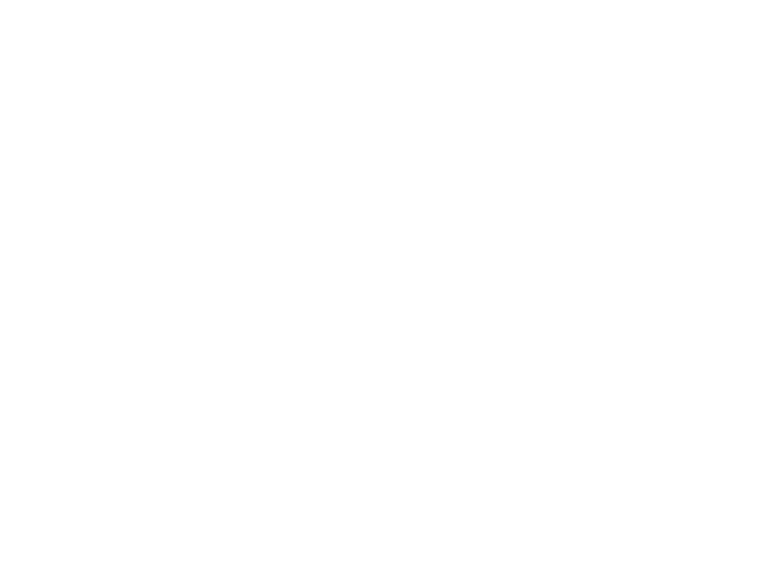

<IPython.core.display.Javascript object>


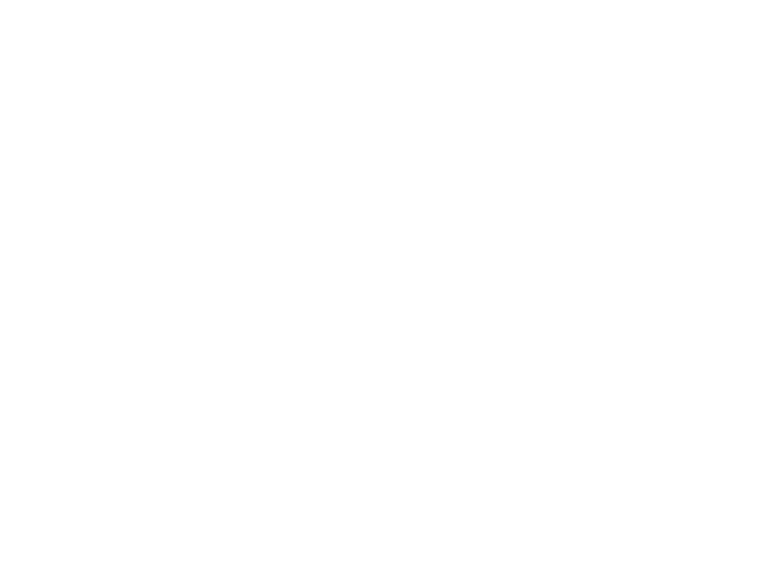

<IPython.core.display.Javascript object>


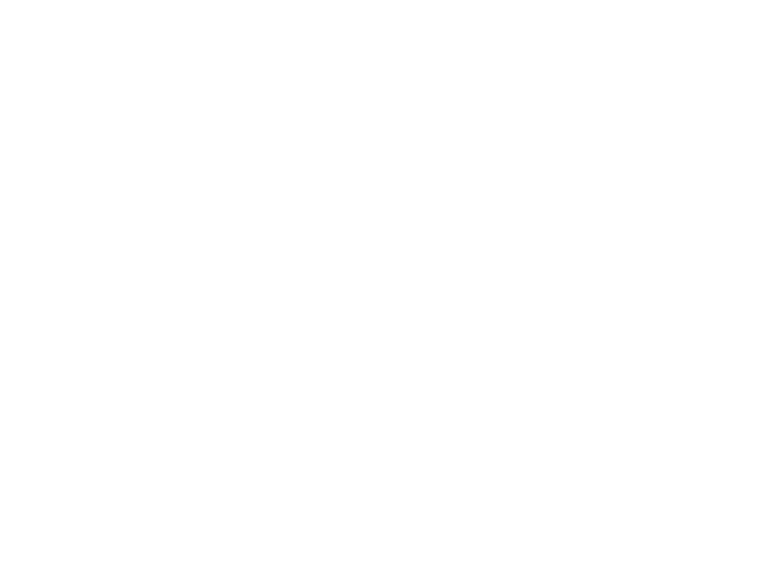

<IPython.core.display.Javascript object>


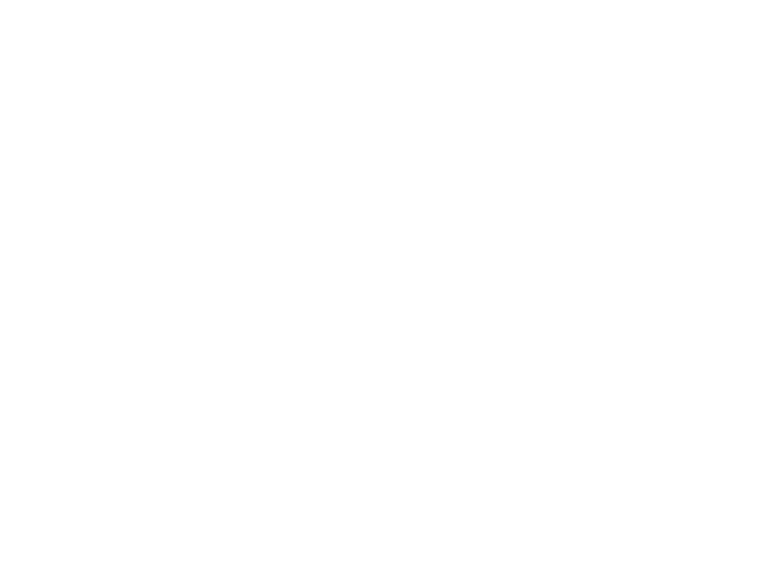

<IPython.core.display.Javascript object>


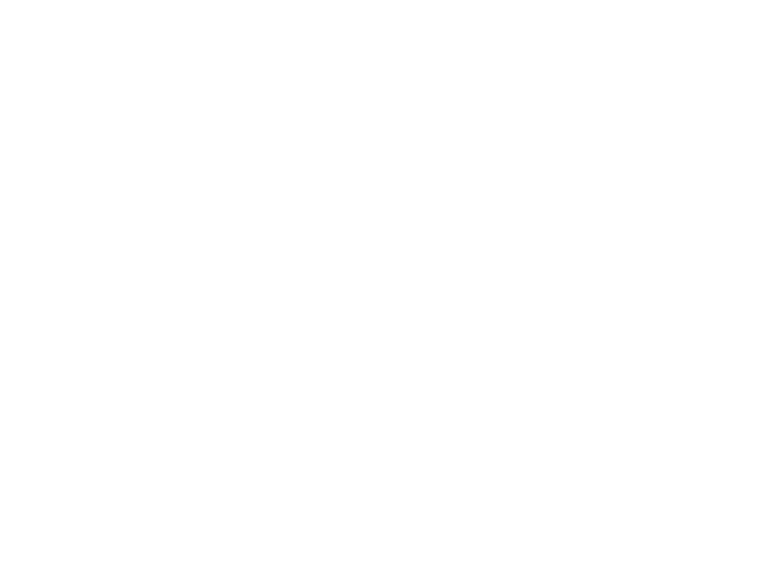

<IPython.core.display.Javascript object>


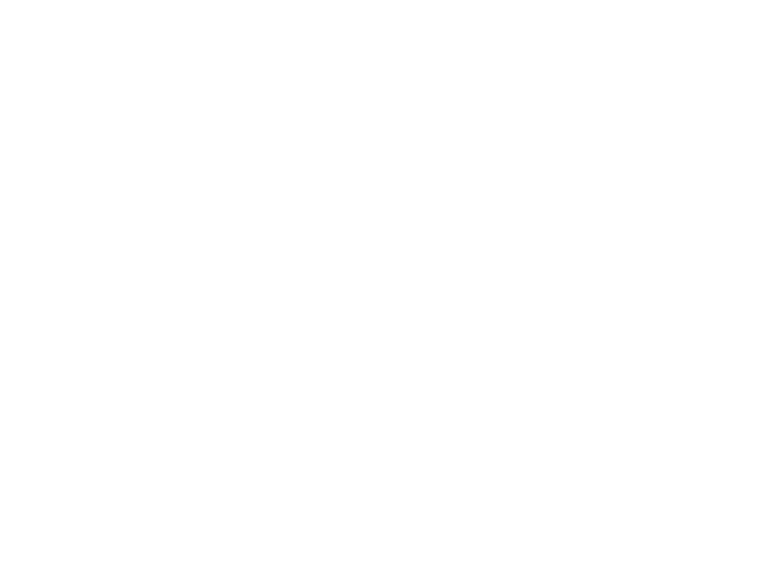

<IPython.core.display.Javascript object>


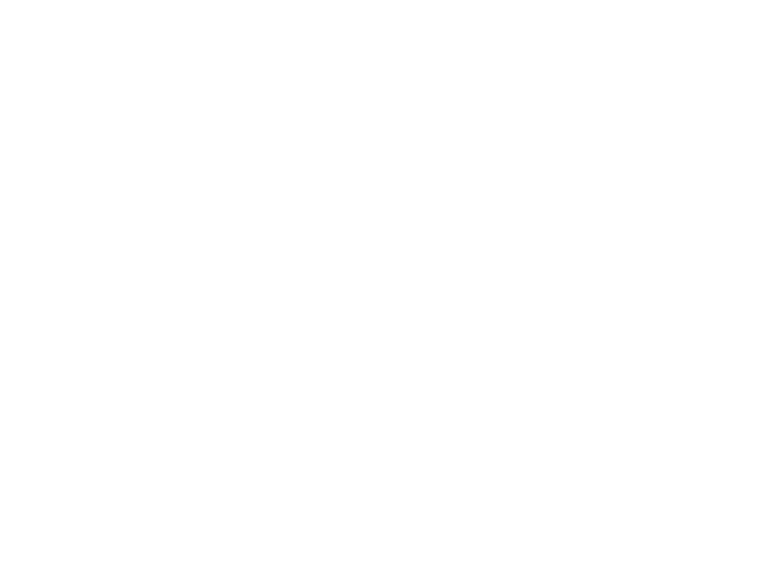

<IPython.core.display.Javascript object>


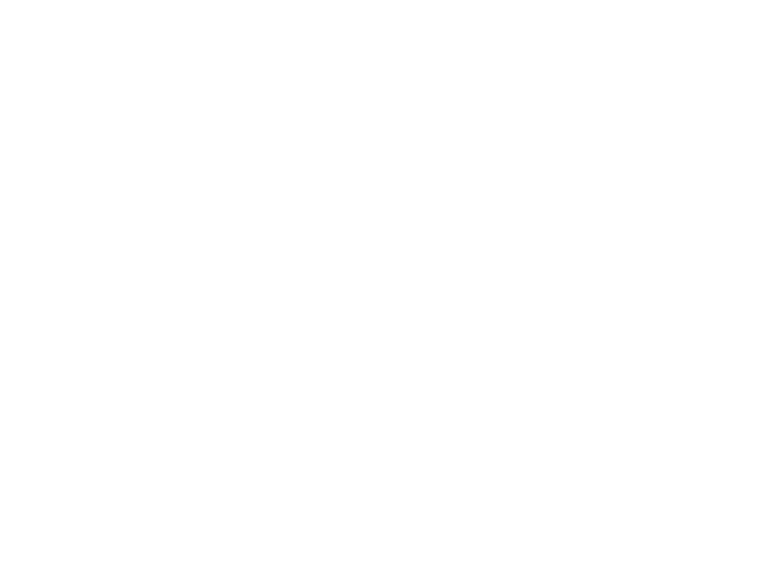

<IPython.core.display.Javascript object>


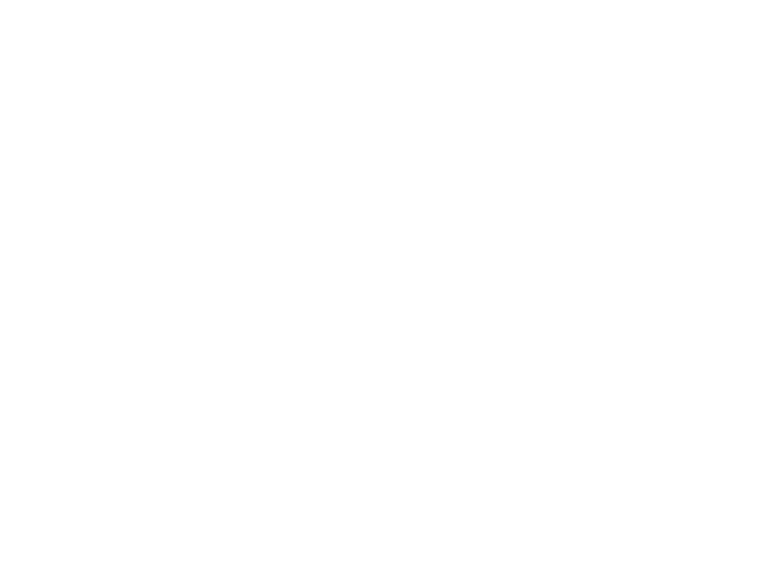

<IPython.core.display.Javascript object>


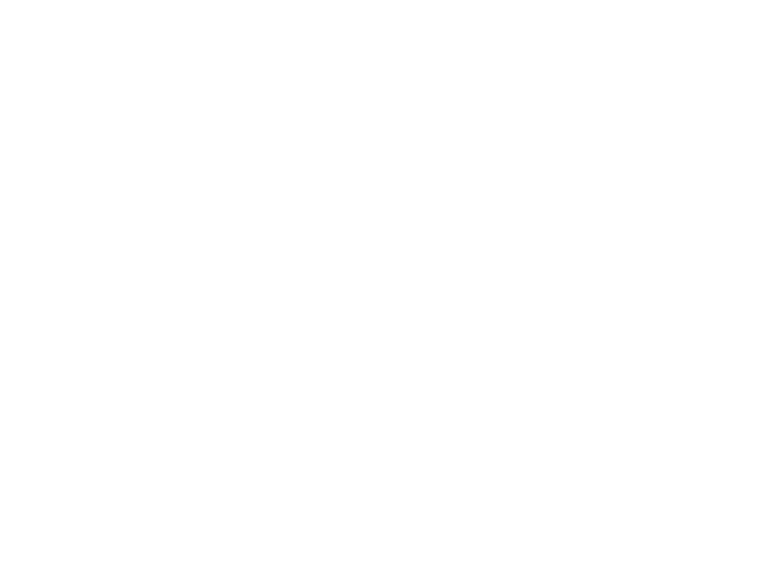

<IPython.core.display.Javascript object>


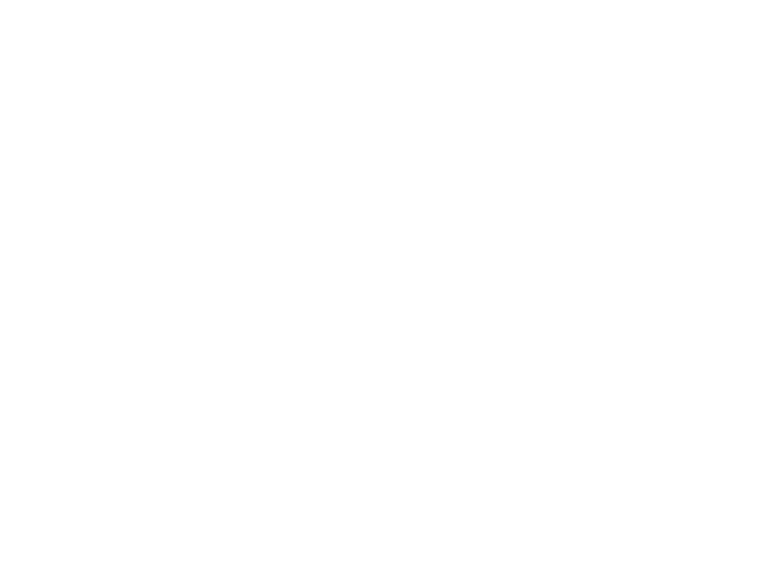

<IPython.core.display.Javascript object>


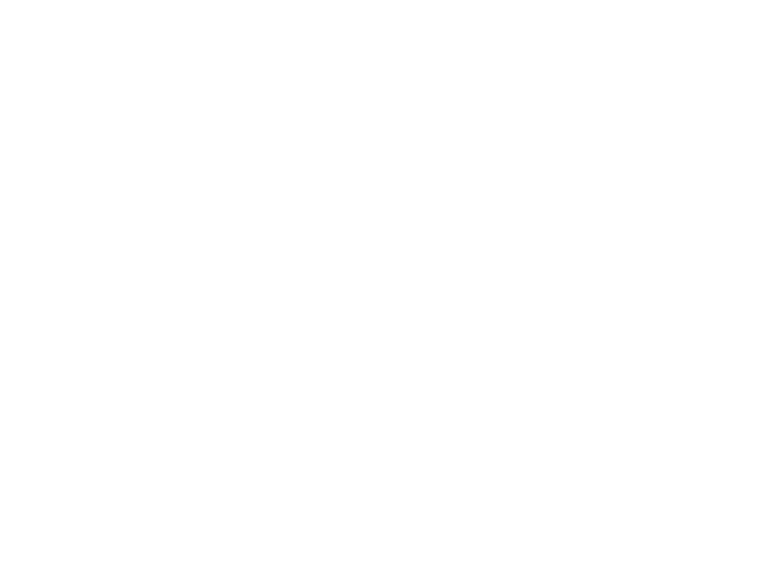

<IPython.core.display.Javascript object>


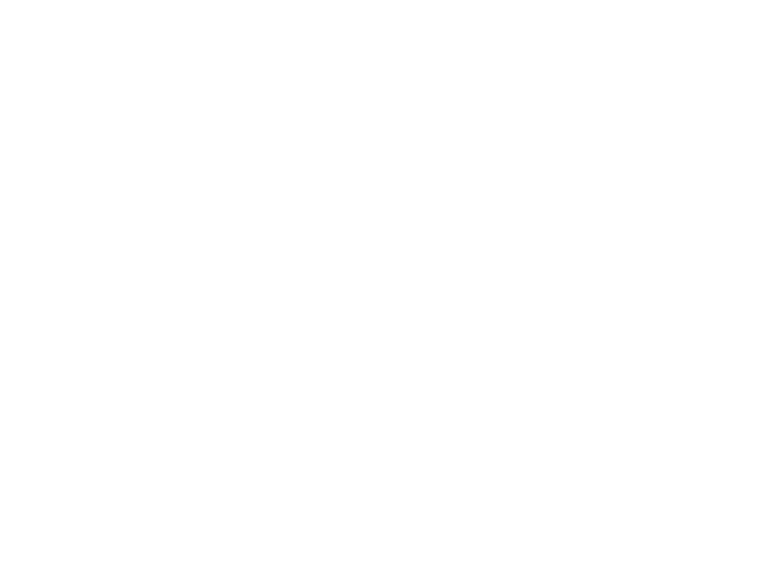

<IPython.core.display.Javascript object>


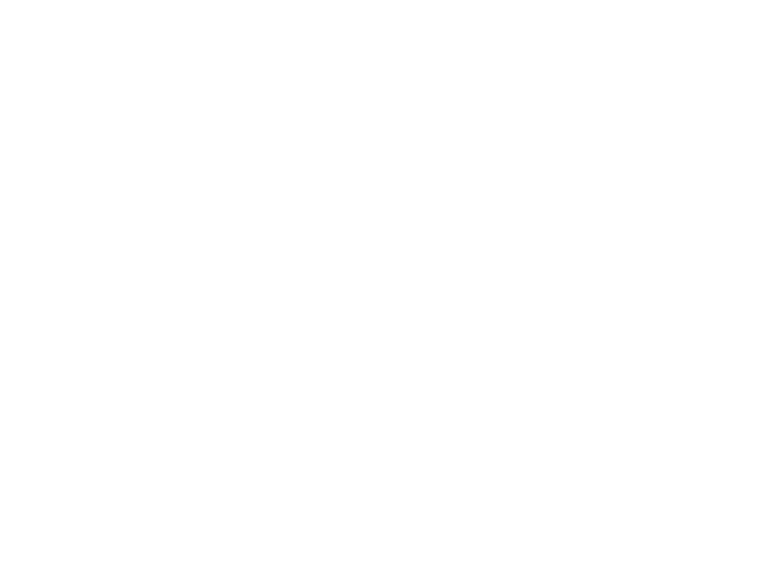

<IPython.core.display.Javascript object>


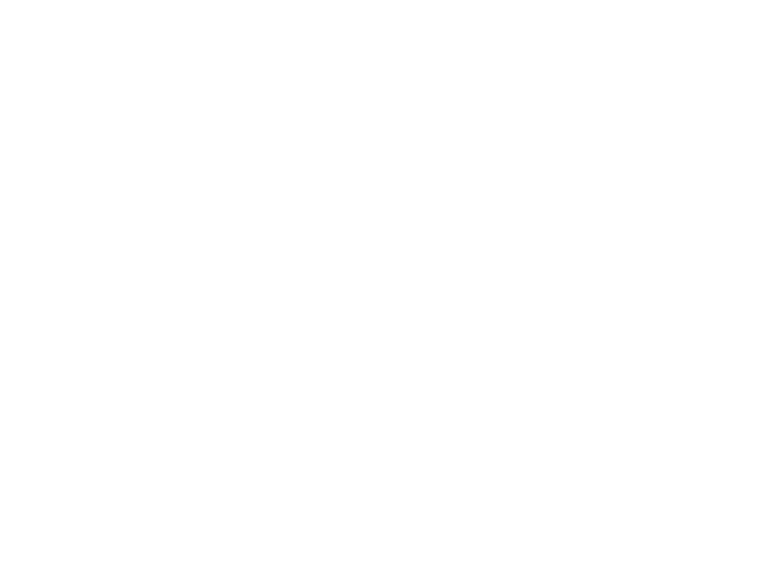

<IPython.core.display.Javascript object>


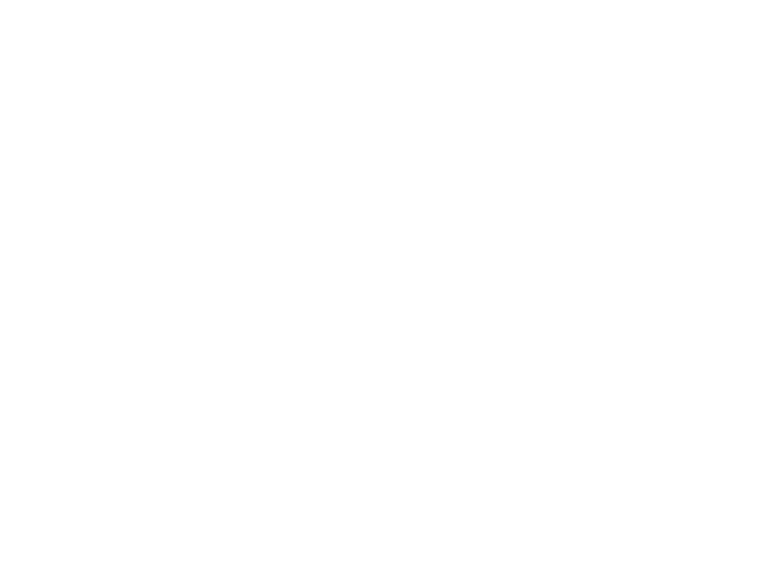

<IPython.core.display.Javascript object>


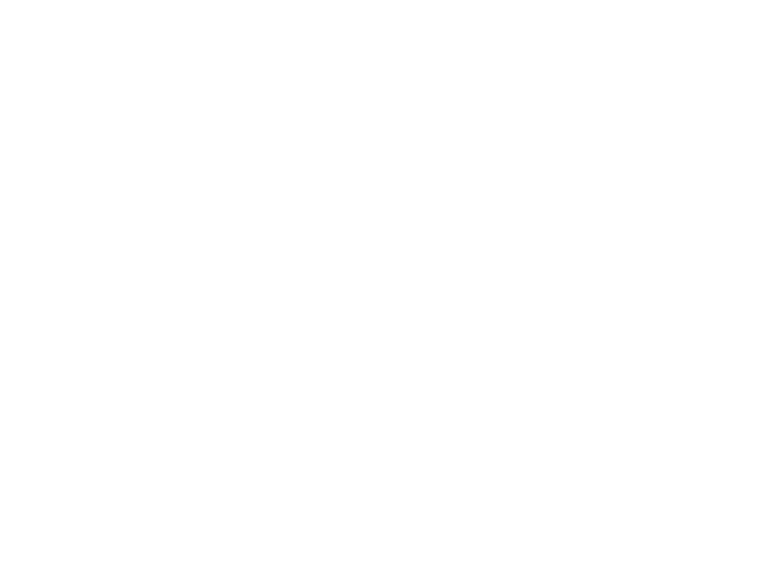

<IPython.core.display.Javascript object>


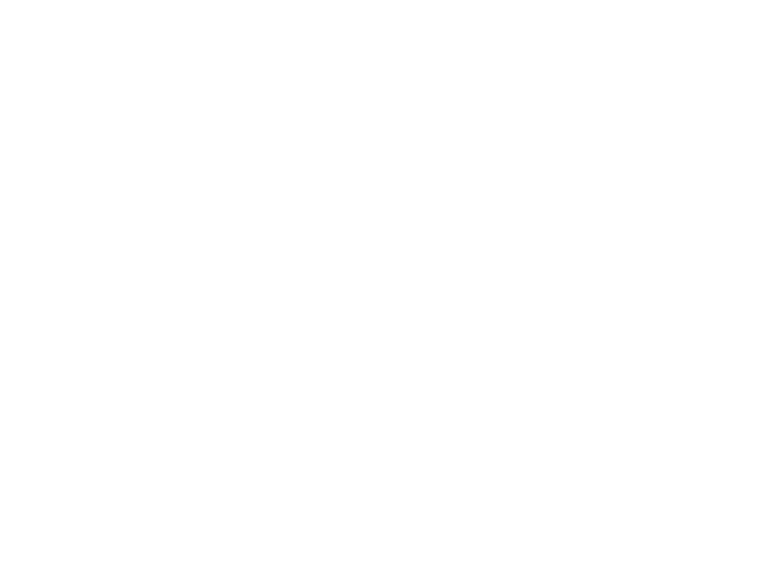

<IPython.core.display.Javascript object>


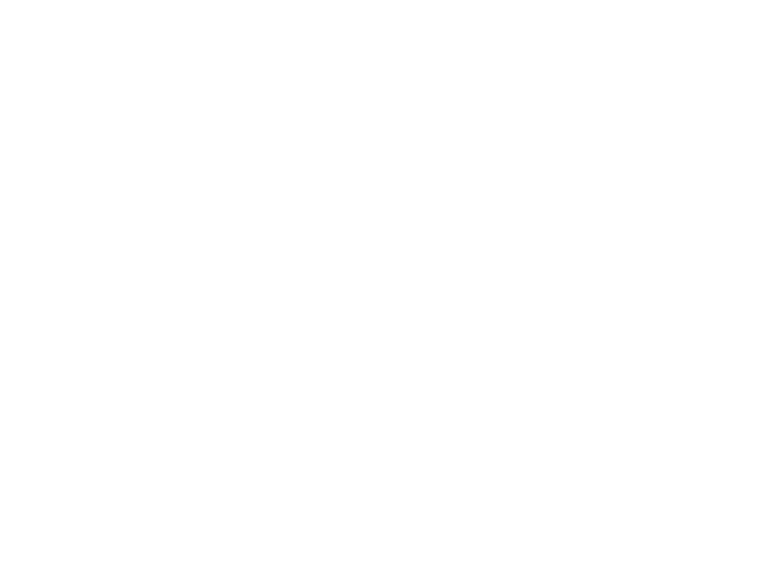

<IPython.core.display.Javascript object>


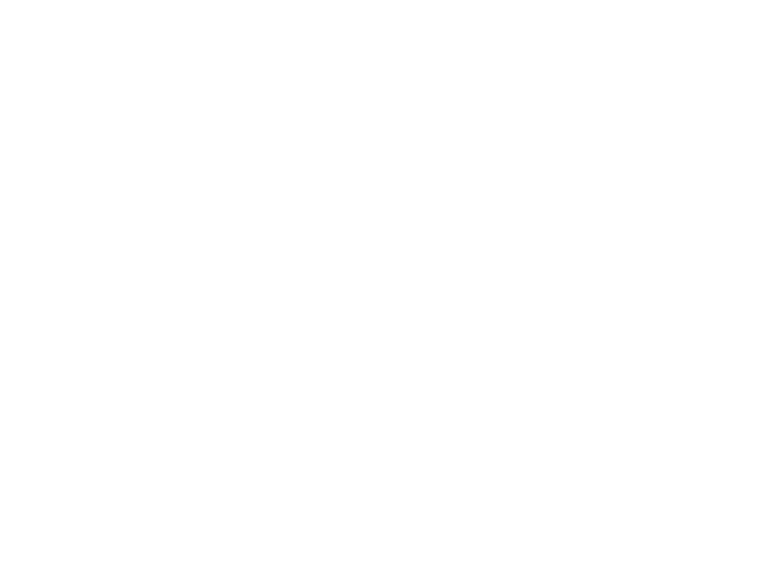

<IPython.core.display.Javascript object>


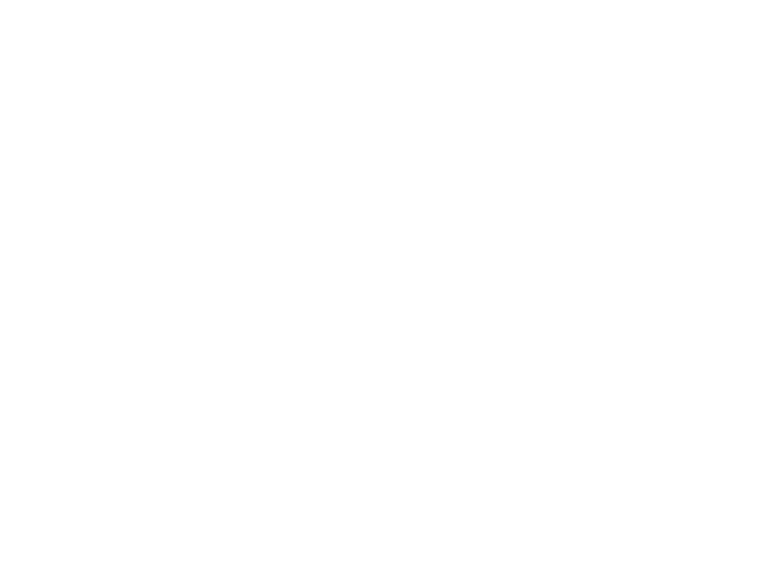

<IPython.core.display.Javascript object>


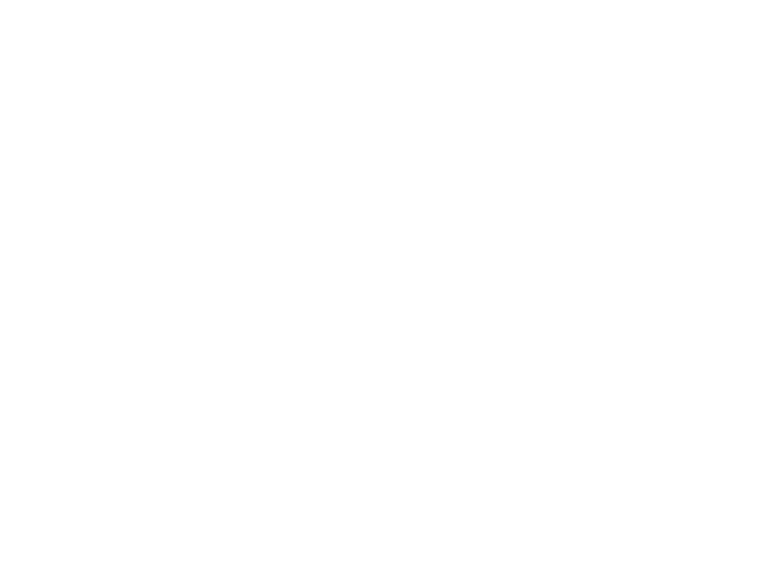

<IPython.core.display.Javascript object>


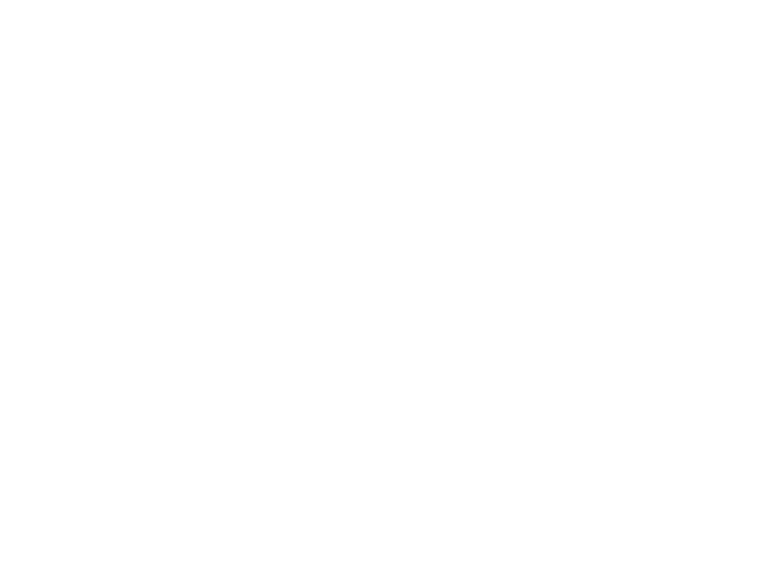

<IPython.core.display.Javascript object>


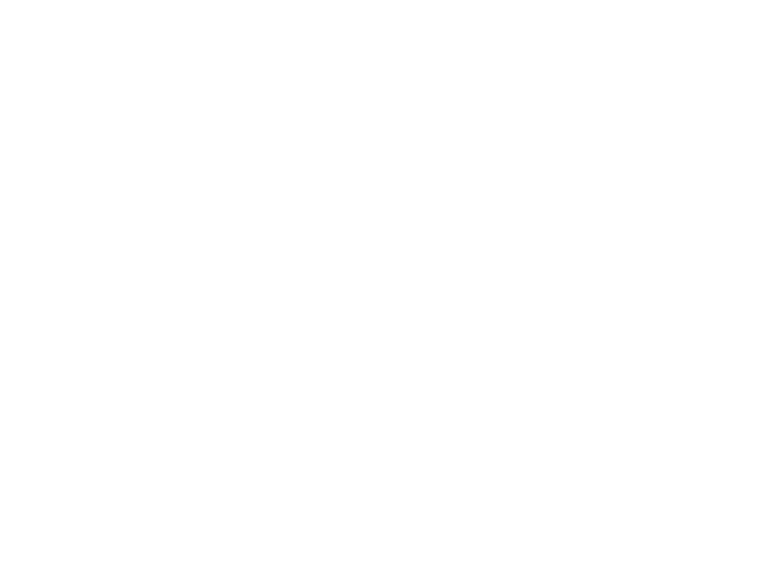

<IPython.core.display.Javascript object>


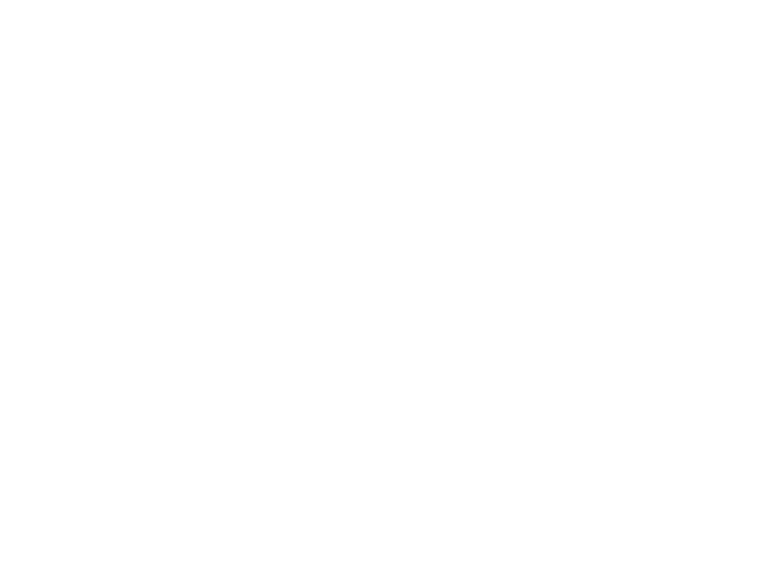

<IPython.core.display.Javascript object>


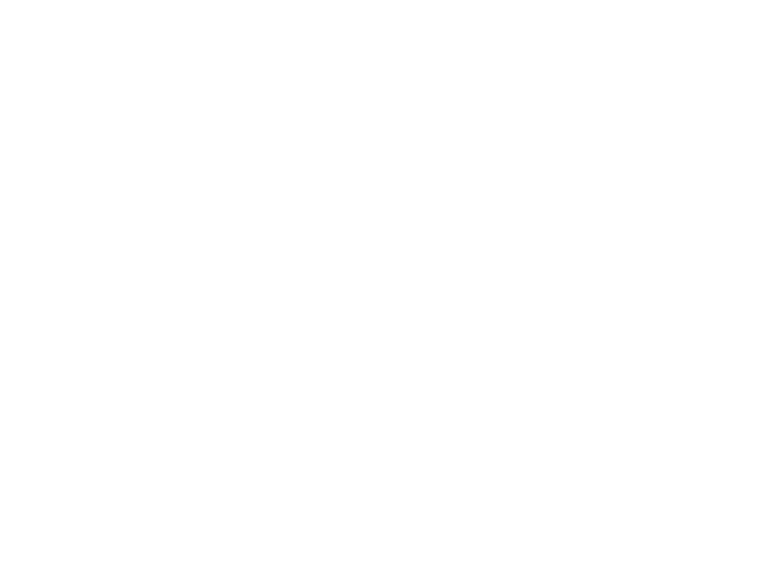

<IPython.core.display.Javascript object>


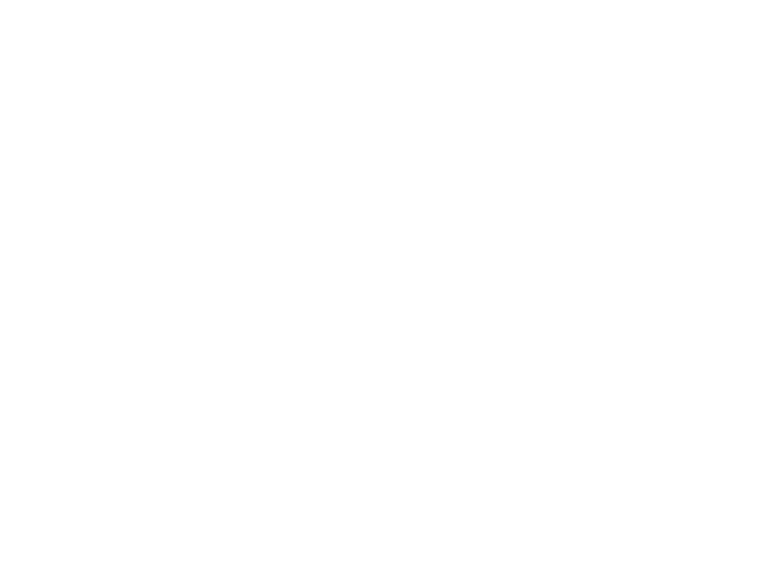

<IPython.core.display.Javascript object>


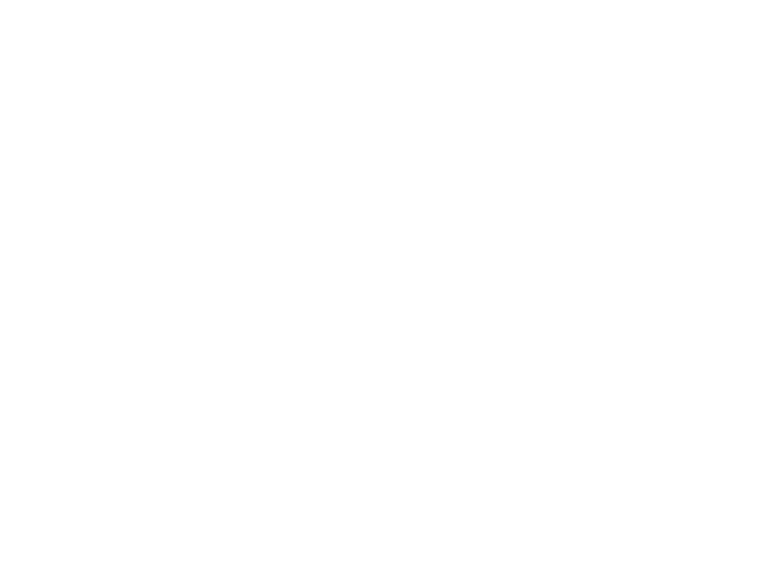

<IPython.core.display.Javascript object>


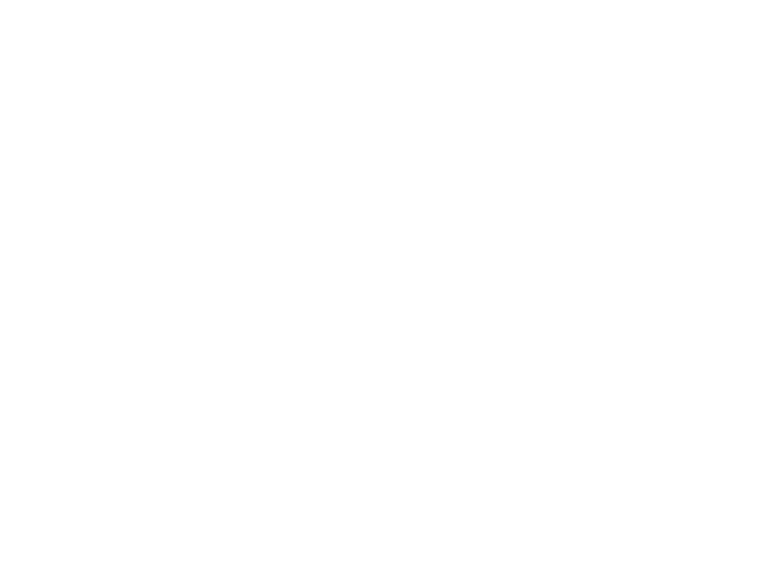

<IPython.core.display.Javascript object>


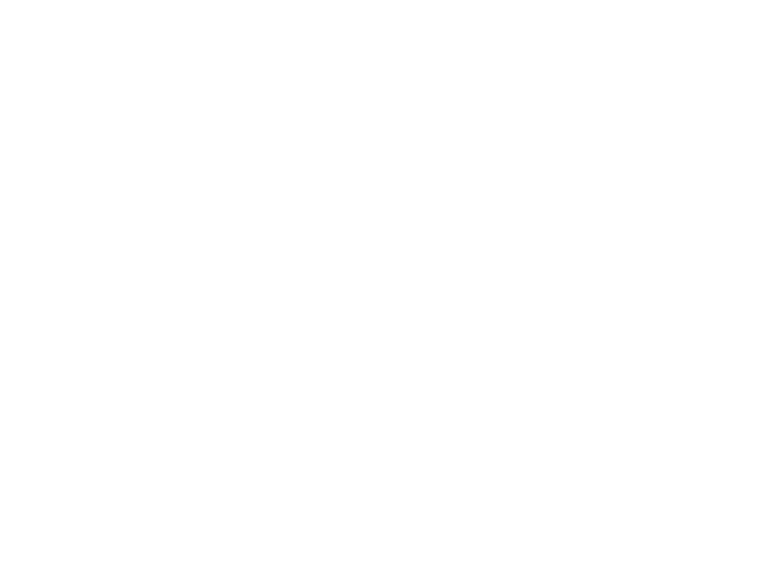

<IPython.core.display.Javascript object>


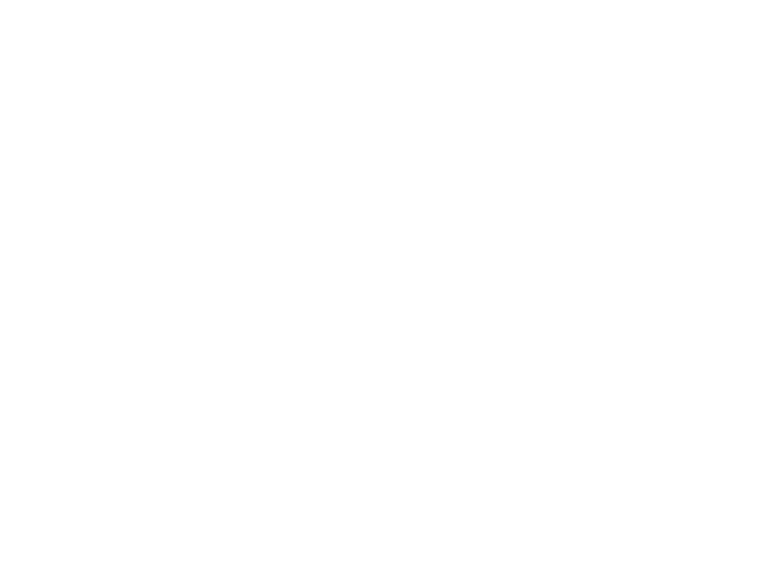

<IPython.core.display.Javascript object>


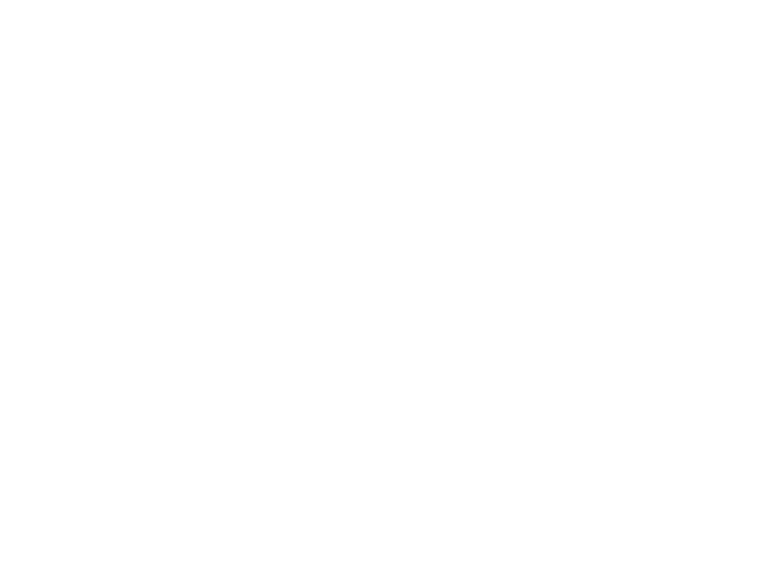

<IPython.core.display.Javascript object>


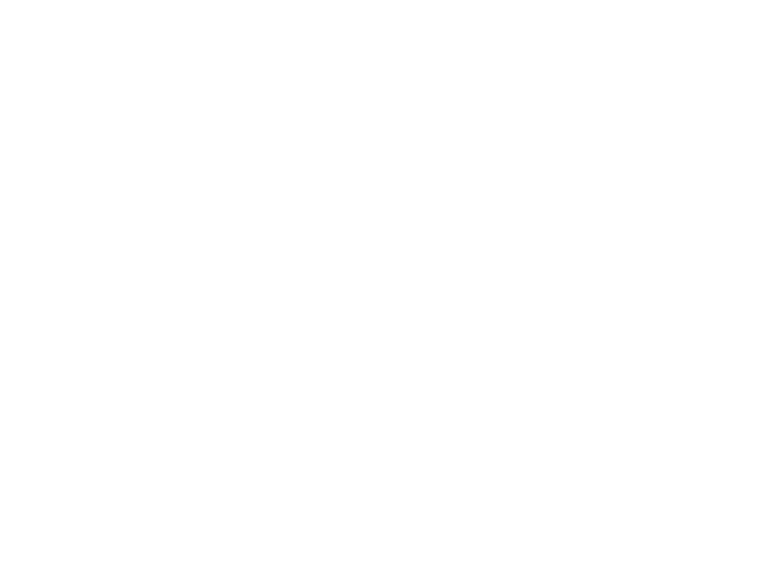

<IPython.core.display.Javascript object>


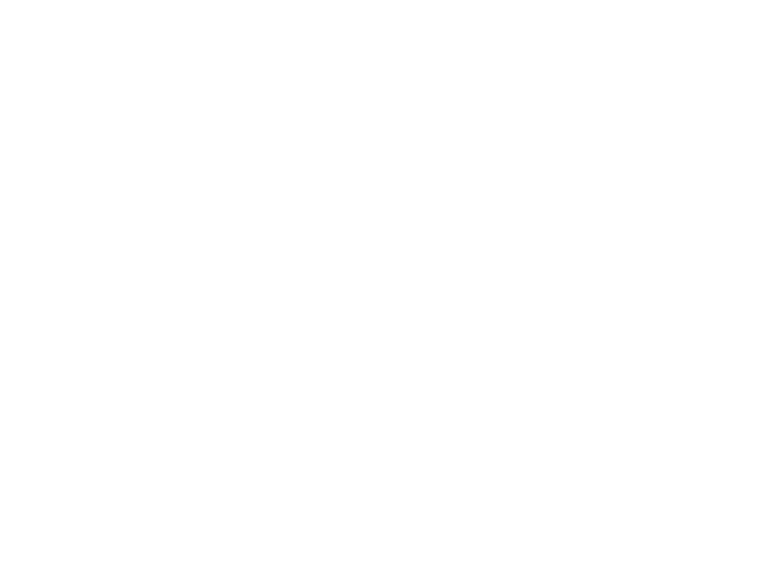

<IPython.core.display.Javascript object>


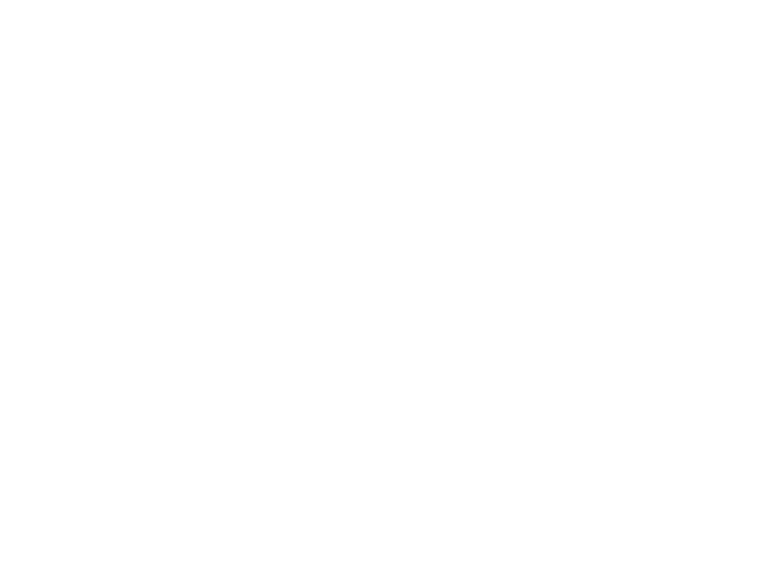

<IPython.core.display.Javascript object>


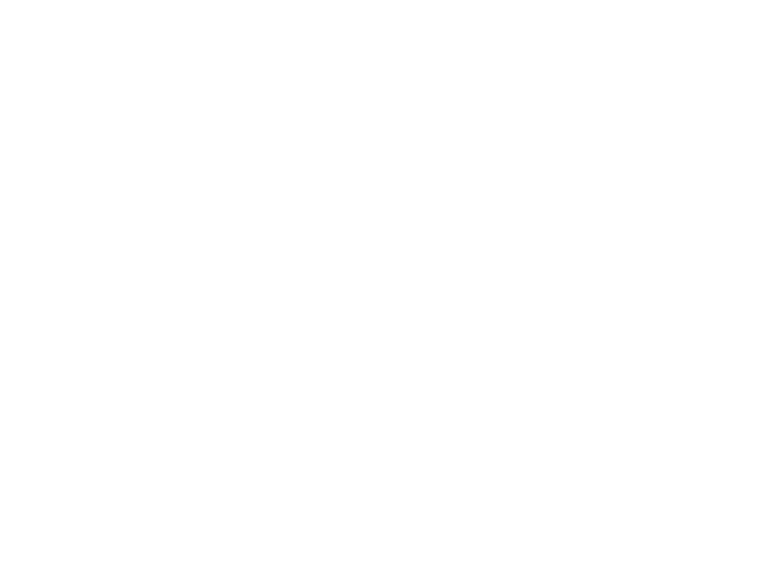

<IPython.core.display.Javascript object>


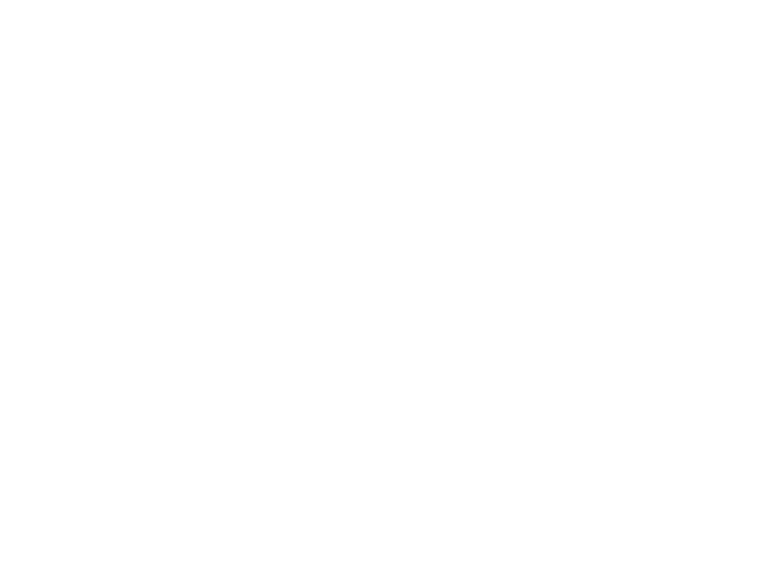

<IPython.core.display.Javascript object>


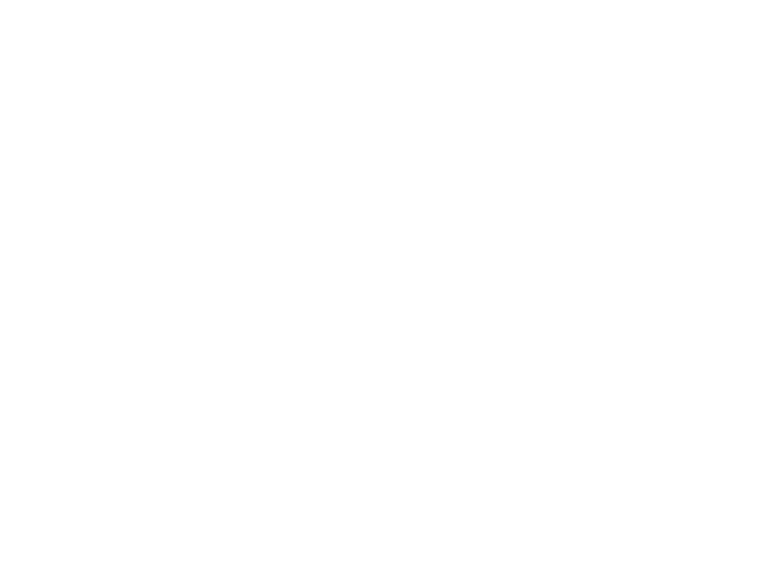

<IPython.core.display.Javascript object>


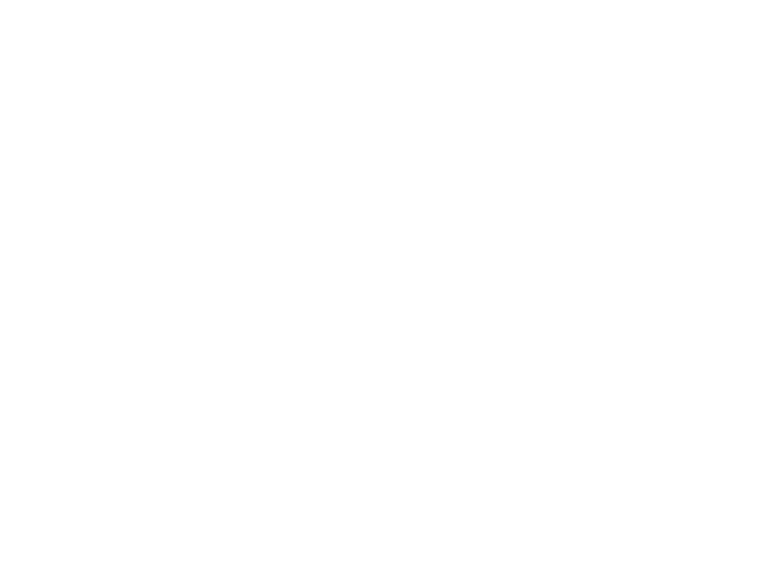

<IPython.core.display.Javascript object>


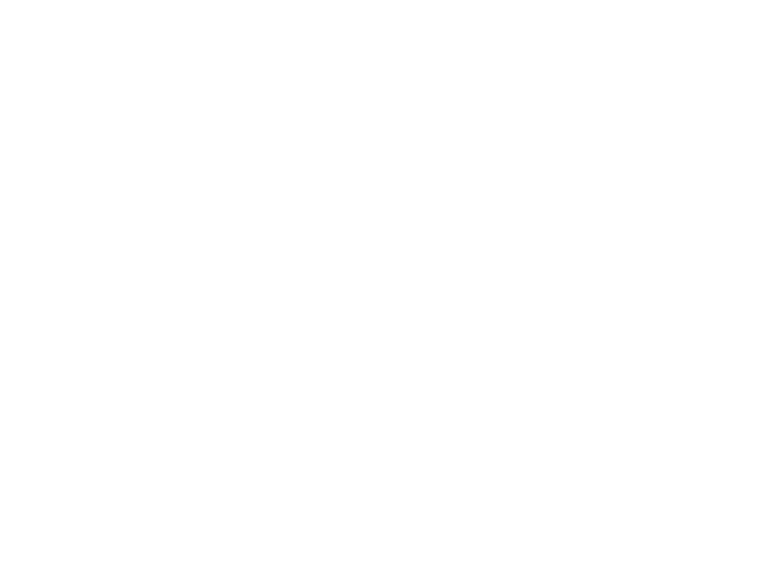

<IPython.core.display.Javascript object>


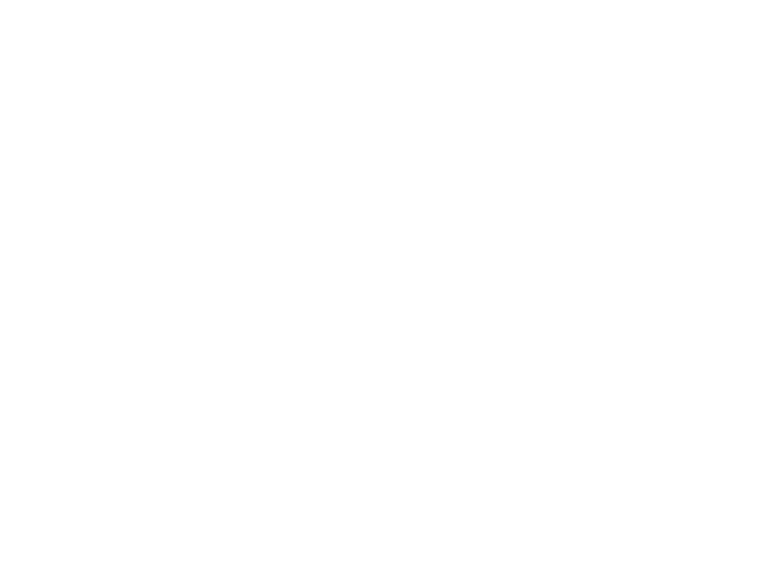

<IPython.core.display.Javascript object>


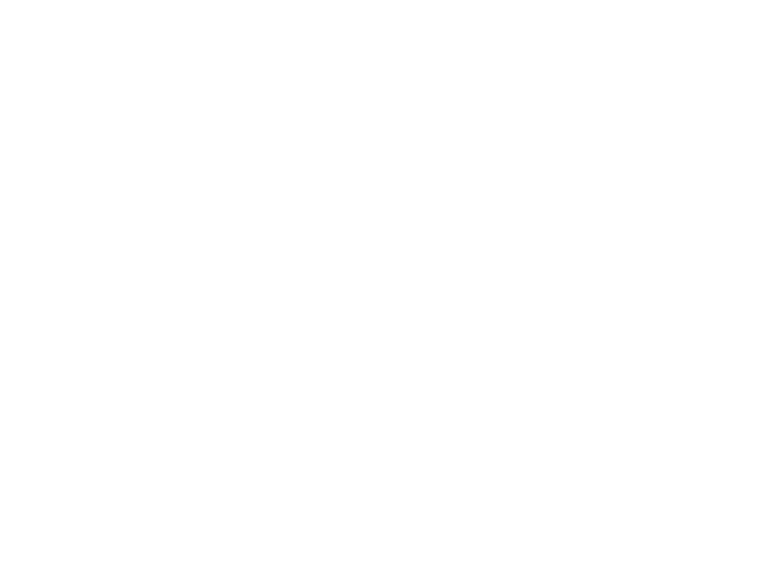

<IPython.core.display.Javascript object>


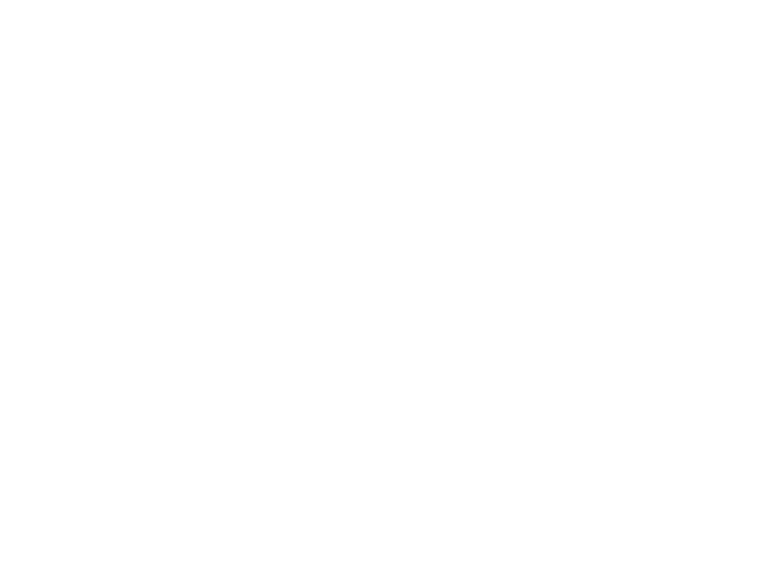

<IPython.core.display.Javascript object>


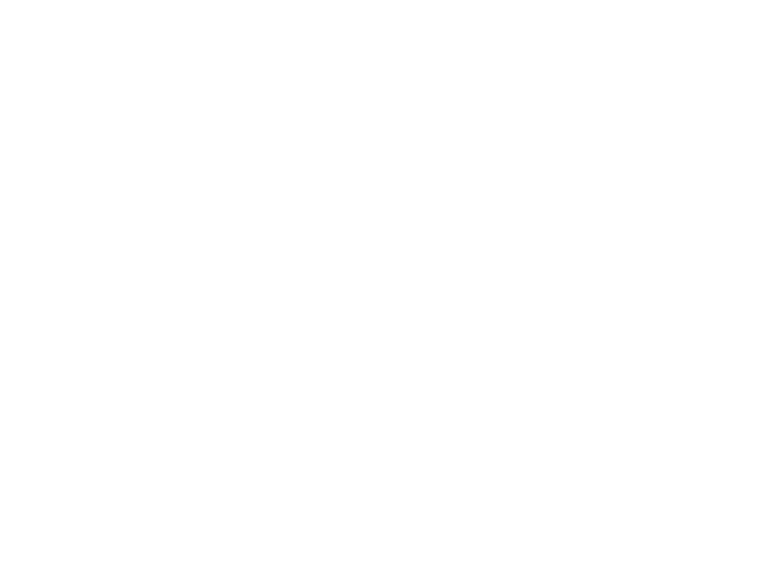

<IPython.core.display.Javascript object>


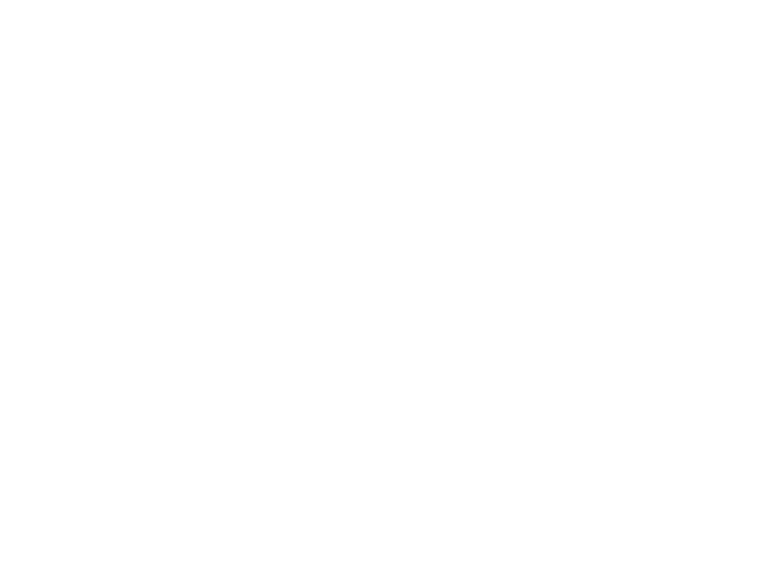

<IPython.core.display.Javascript object>


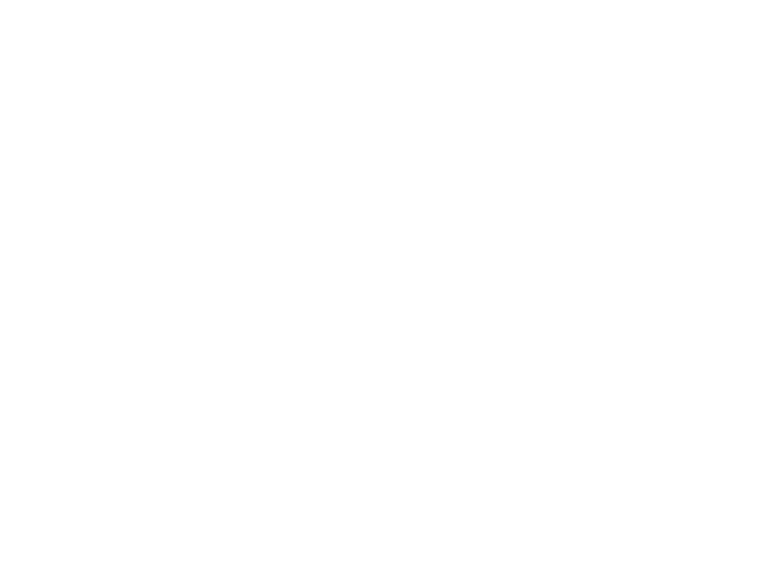

<IPython.core.display.Javascript object>


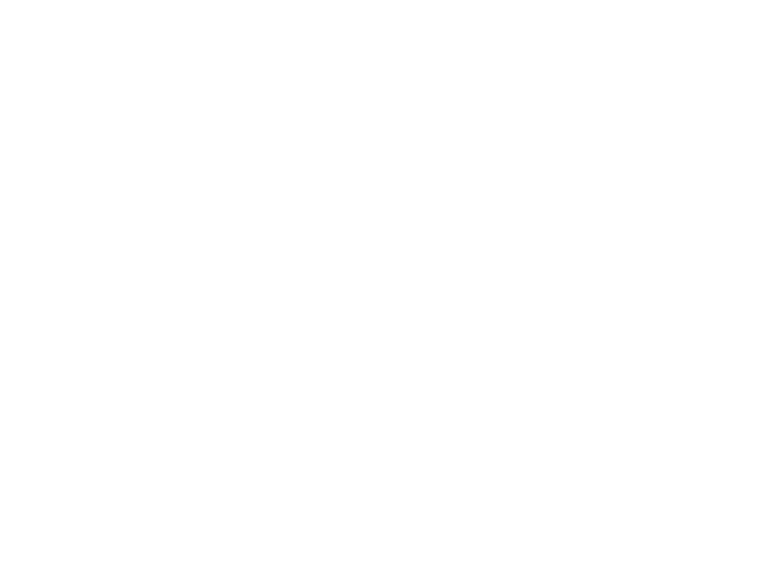

<IPython.core.display.Javascript object>


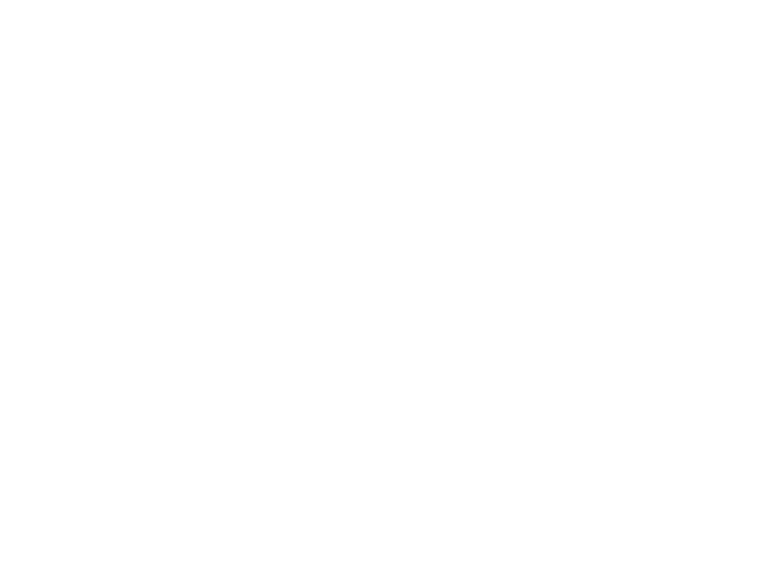

<IPython.core.display.Javascript object>


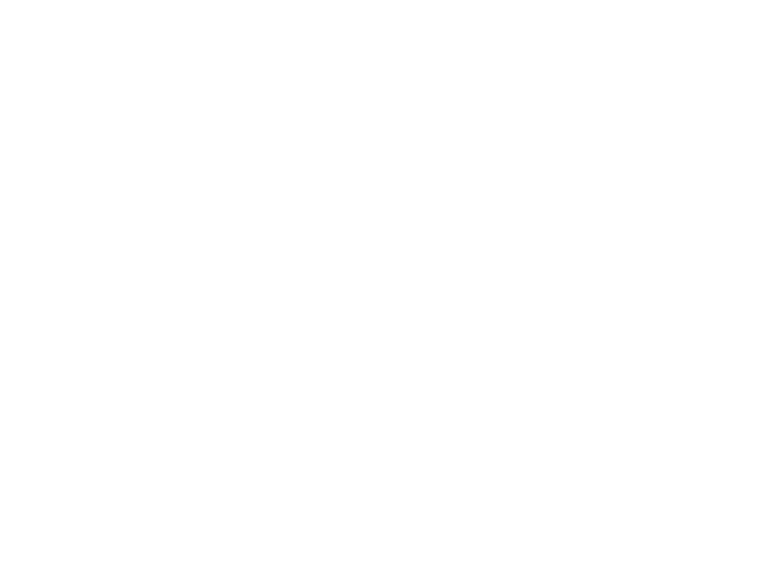

<IPython.core.display.Javascript object>


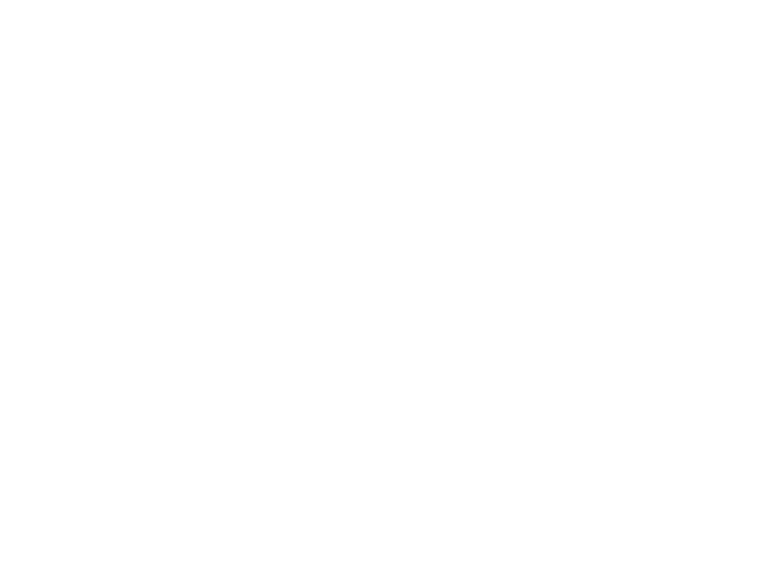

<IPython.core.display.Javascript object>


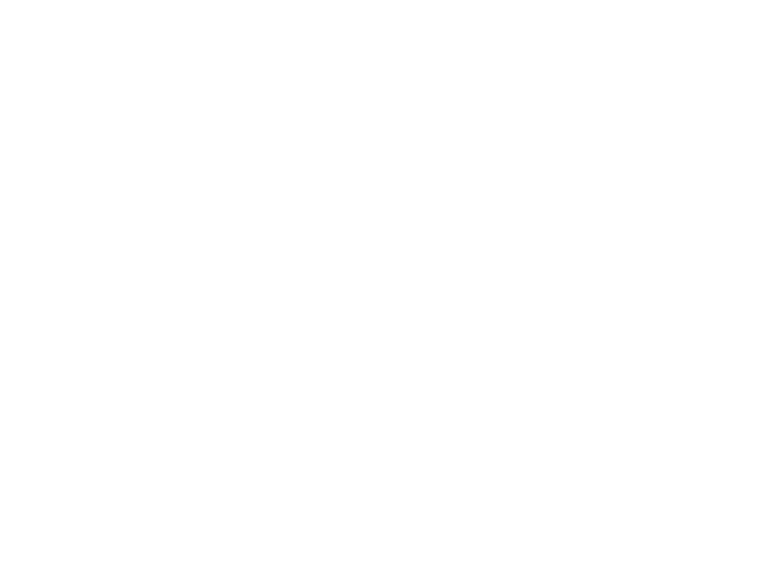

<IPython.core.display.Javascript object>


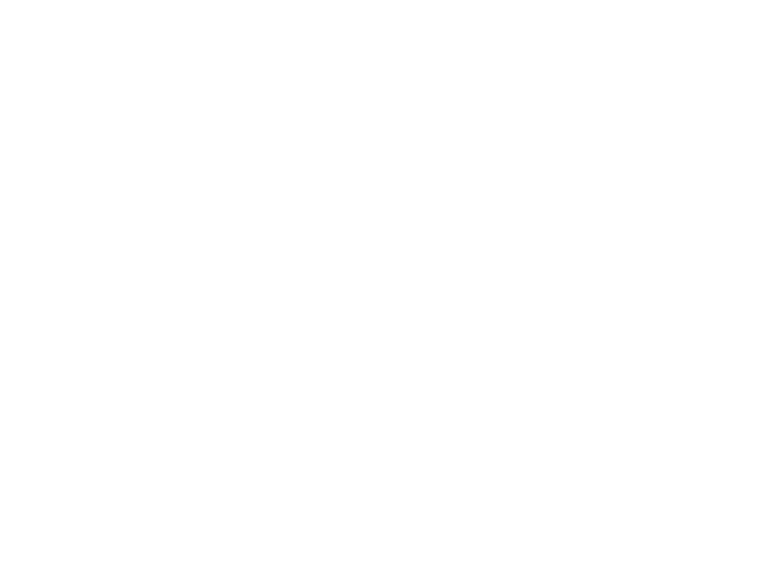

<IPython.core.display.Javascript object>


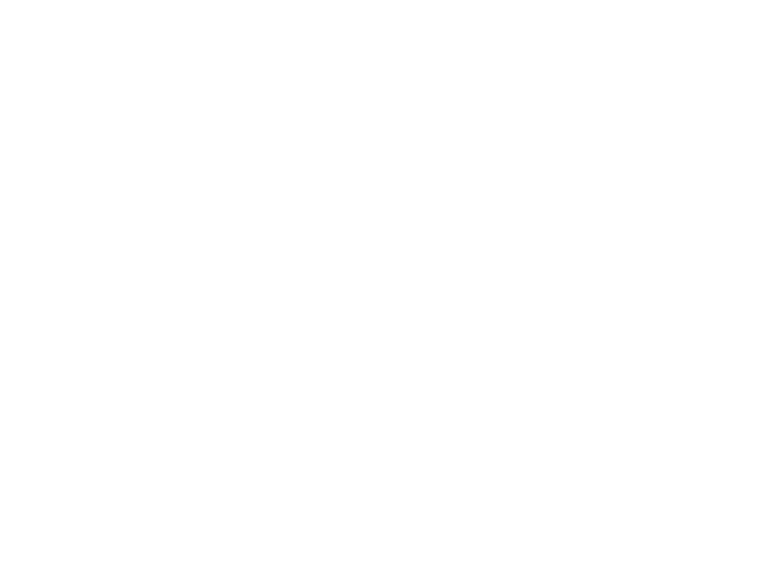

<IPython.core.display.Javascript object>


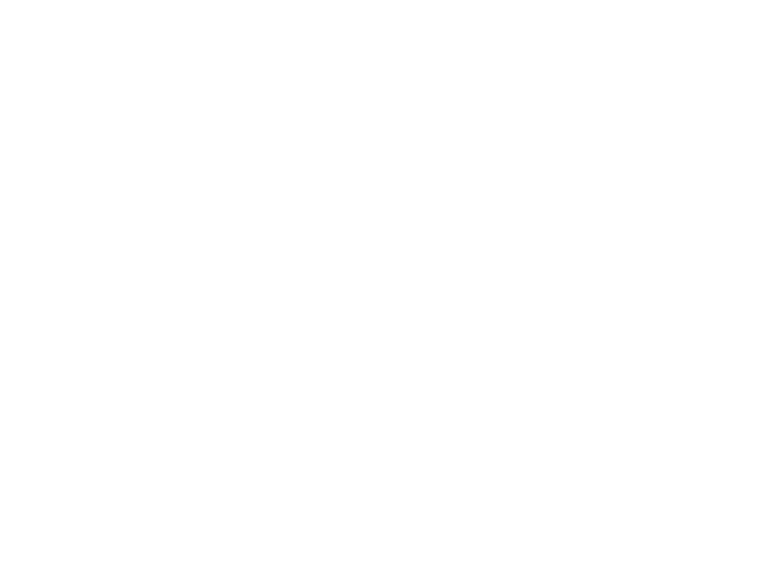

<IPython.core.display.Javascript object>


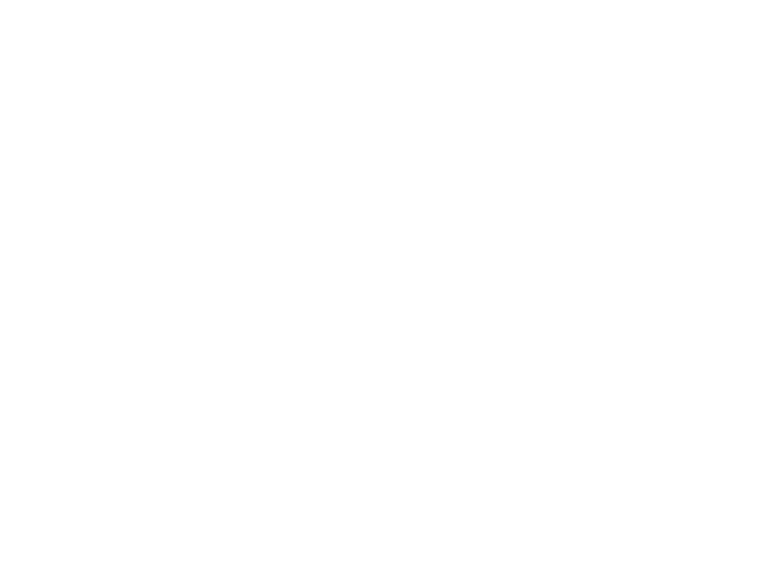

<IPython.core.display.Javascript object>


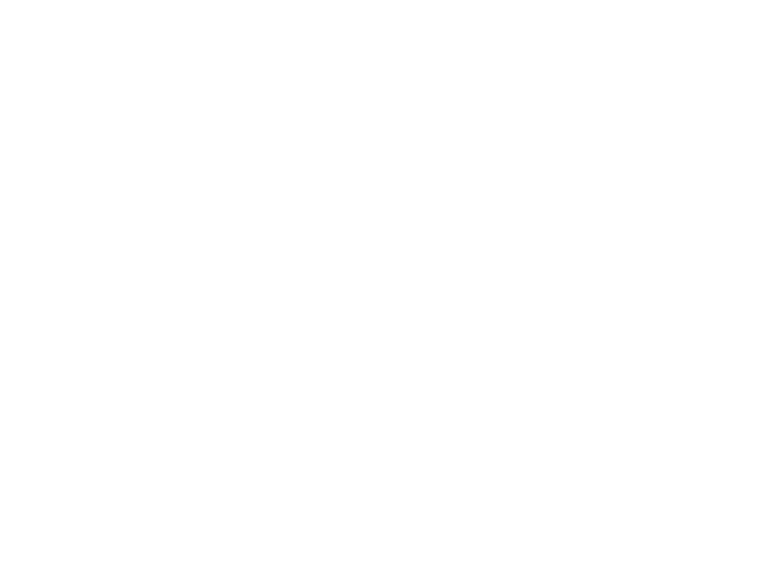

<IPython.core.display.Javascript object>


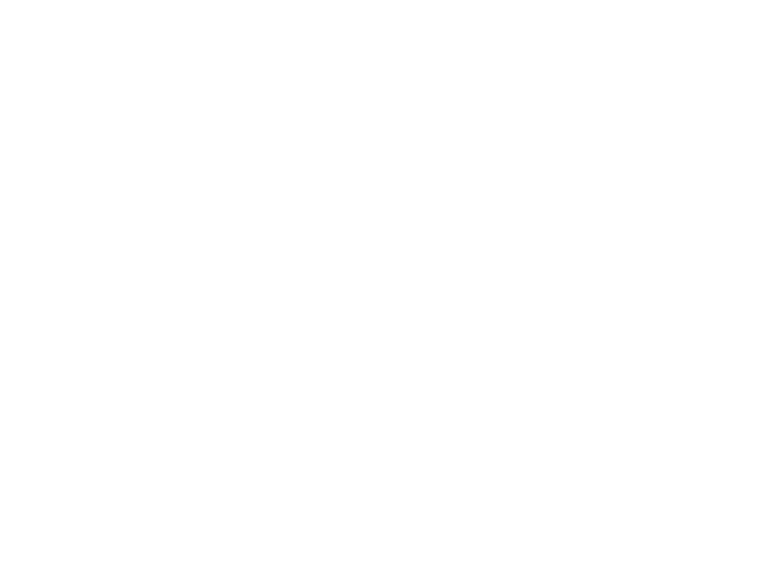

In [43]:
# for image_id, n in enumerate(image_names):
#     intsy_matrix = single_peak_intensities[n]
#     decon_matrix = masserstein_estimation[n]
#     for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):  # remove [:4] when finished
#         # reformat the data for plotting
#         intsy_image = np.zeros(image_shapes[n])
#         decon_image = np.zeros(image_shapes[n])
#         intsy_segm  = np.zeros(image_shapes[n])
#         decon_segm  = np.zeros(image_shapes[n])
#         for i, l in enumerate(intensity_coordinates[n]):
#             intsy_image[l[0], l[1]] = single_peak_intensities[n][i, lipid_id]
#             intsy_segm[l[0], l[1]]  = intensity_segmentation[n][i, lipid_id]
#         for i, l in enumerate(masserstein_coordinates[n]):
#             decon_image[l[0], l[1]] = masserstein_estimation[n][i, lipid_id]
#             decon_segm[l[0], l[1]]  = masserstein_segmentation[n][i, lipid_id]
#         plt.figure()
        
#         plt.subplot(2, 2, 1)
#         plt.title('Peak (profile)\n' + str(round(lipid_sp.confs[0][0], 3)))
#         plt.imshow(intsy_image, interpolation='none', cmap=cm.magma)
#         plt.axis('off')
        
#         plt.subplot(2, 2, 2)
#         plt.title('Masserstein\n' + lipid_sp.formula)
#         plt.imshow(decon_image, interpolation='none', cmap=cm.magma)
#         plt.axis('off')
        
#         plt.subplot(2, 2, 3)
#         plt.title('K-means')
#         plt.imshow(intsy_segm, interpolation='none', cmap=cm.hot)
#         plt.axis('off')
        
#         plt.subplot(2, 2, 4)
#         plt.title('sDGMM')
#         plt.imshow(decon_segm, interpolation='none', cmap=cm.hot)
#         plt.axis('off')
        
#         plt.tight_layout()
#         plt.savefig('Figs/' + n + '_segmentation/%i.png' % lipid_id, dpi=300)
#         plt.close()

## Additional analyses 

Inspect the distribution of non-zero signals on a log-scale (just for the sake of curiosity)

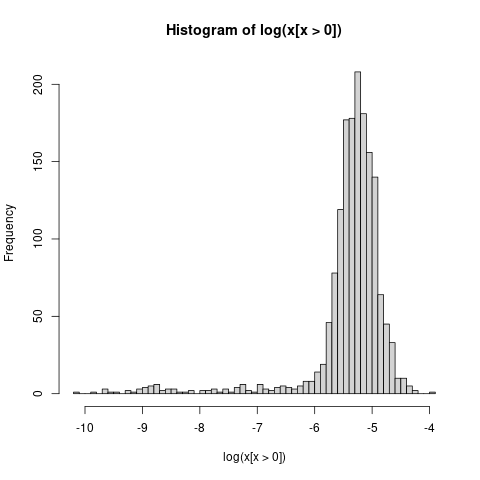

In [44]:
%%R 
hist(log(x[x>0]), breaks=80)


Inspect the distribution of non-zero signals on a log-scale (just for the sake of curiosity)

In addition: Warning message:
In x + 1 + rnorm(nrow(bladder_df), 0, 1e-06) :
  longer object length is not a multiple of shorter object length


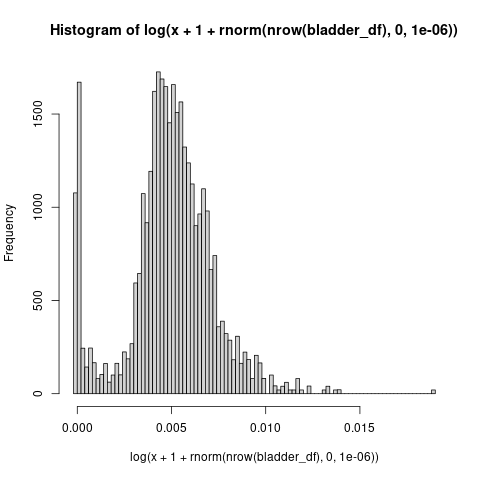

In [45]:
%%R 
hist(log(x + 1 + rnorm(nrow(bladder_df), 0, 0.000001)), breaks=120)

In [ ]:
# masserstein_estimation = {n : [] for n in image_names}
# masserstein_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     frms = lipid_formulas[n]
#     with open(n + '_masserstein_quantification.tsv') as h:
#         header = next(h)
#         header = header.strip().split('\t')
#         header_formulas = header[2:]
#         formula_order = [header_formulas.index(f) for f in frms]
#         for l in h:
#             l = l.strip().split('\t')
#             masserstein_coordinates[n].append((int(l[0]), int(l[1])))
#             vec = list(map(float, l[2:]))
#             vec = [vec[i] for i in formula_order]
#             masserstein_estimation[n].append(vec)
# masserstein_estimation = {n : np.array(masserstein_estimation[n]) for n in image_names}
# masserstein_coordinates = {n : np.array(masserstein_coordinates[n]) for n in image_names}

In [ ]:
# single_peak_intensities = {n : [] for n in image_names}
# intensity_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     frms = lipid_formulas[n]
#     with open(n + '_single_peak_intensities.tsv') as h:
#         header = next(h)
#         header = header.strip().split('\t')
#         header_formulas = header[2:]
#         formula_order = [header_formulas.index(f) for f in frms]
#         for l in h:
#             l = l.strip().split('\t')
#             intensity_coordinates[n].append((int(l[0]), int(l[1])))
#             vec = list(map(float, l[2:]))
#             vec = [vec[i] for i in formula_order]
#             single_peak_intensities[n].append(vec)
# single_peak_intensities = {n : np.array(single_peak_intensities[n]) for n in image_names}
# intensity_coordinates = {n : np.array(intensity_coordinates[n]) for n in image_names}

### Removing background before segmentation

Example segmentation:

Construct the image from all pixels (including zero intensity)

In [45]:
%%R 
# A single image with 3 features
test_coord <- cerebellum_df[,c('x', 'y')] 
test_sdata <- t(unname(as.matrix(cerebellum_df[3:5])))
test_run <- factor(rep("run0", nrow(test_coord)))
test_fdata <- MassDataFrame(mz=as.numeric(1:3), row.names=c('a','b','c'))
test_pdata <- PositionDataFrame(run=test_run, coord=test_coord)
# # Optional normalization
# sdata = apply(sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# sdata = apply(sdata, 2, log)
test_image <- MSImagingExperiment(spectraData=test_sdata,
                                 featureData=test_fdata,
                                 pixelData=test_pdata,
                                 centroided = TRUE)

# Separating features into different images - for performance comparison
onef_images <- list()
for(i in 3:5){
    test_coord <- cerebellum_df[,c('x', 'y')] 
    test_sdata <- t(unname(as.matrix(cerebellum_df[i])))
    test_run <- factor(rep("run0", nrow(test_coord)))
    test_fdata <- MassDataFrame(mz=as.numeric(i))
    test_pdata <- PositionDataFrame(run=test_run, coord=test_coord)
    onef_images[[length(onef_images)+1]] <- MSImagingExperiment(spectraData=test_sdata,
                                         featureData=test_fdata,
                                         pixelData=test_pdata,
                                         centroided = TRUE)
}


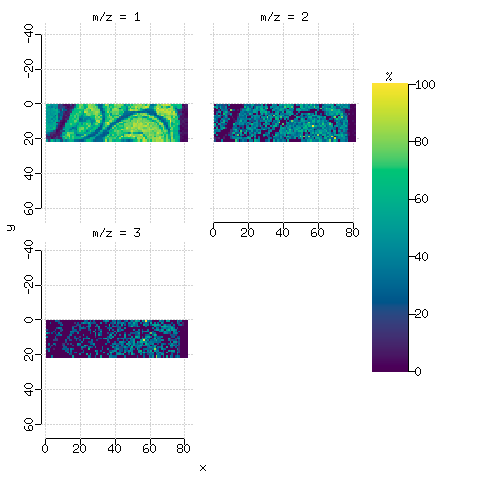

In [161]:
# %%R 
# image(test_image, i=1:3, scale=T)

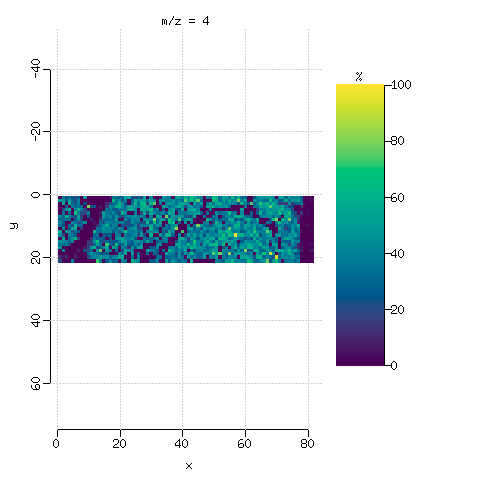

In [162]:
# %%R
# image(onef_images[[2]], scale=T)

Example spatial-DGMM segmentation

In [59]:
%%R
?spatialDGMM

File: /tmp/RtmpQmyxu5/Rtxt166e429efbcd
SpatialDGMM              package:Cardinal              R Documentation



_S_p_a_t_i_a_l_l_y-_a_w_a_r_e _D_i_r_i_c_h_l_e_t _G_a_u_s_s_i_a_n _m_i_x_t_u_r_e _m_o_d_e_l



_D_e_s_c_r_i_p_t_i_o_n:



     Fit a spatially-aware Gaussian mixture models to each feature. The

     model uses Dirichlet prior is used to achieve spatial smoothing.

     The means and standard deviations of the Gaussian components are

     estimated using gradient descent. Simulated annealing is used to

     avoid local optimia and achieve better parameter estimates.



_U_s_a_g_e:



     ## S4 method for signature 'ANY'

     spatialDGMM(x, coord, i, r = 1, k = 2, groups = NULL,

         weights = c("gaussian", "adaptive"),

         neighbors = findNeighbors(coord, r=r, groups=groups),

         annealing = TRUE, compress = TRUE, byrow = FALSE,

         nchunks = getCardinalNChunks(),

         verbose = getCar

In [62]:
%%R 
# test_sdgmm <- spatialDGMM(test_image, r=6, k=3, tol=1e-12, iter.max=2000)
test_sdgmm <- spatialDGMM(test_image, neighbors=findNeighbors(cerebellum_image, metric='euclidean', r=1), 
                          weights='adaptive',nchunks=1,
                          k=3, tol=1e-12, iter.max=2000)

test_sdgmm_onef <- list()
for(i in 1:3){
    test_sdgmm_onef[[i]] <- spatialDGMM(onef_images[[i]], r=1, k=3, tol=1e-12, iter.max=2000)
}

calculating gaussian weights
calculating adaptive weights
fitting spatial Gaussian mixture models for k = 3
fitting spatial segmentations for 3 images
processing chunk 1/1 (3 items)

returning spatial Gaussian mixture models
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 3
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)

returning spatial Gaussian mixture model
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 3
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)

returning spatial Gaussian mixture model
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 3
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)

returning spatial Gaussian mixture model


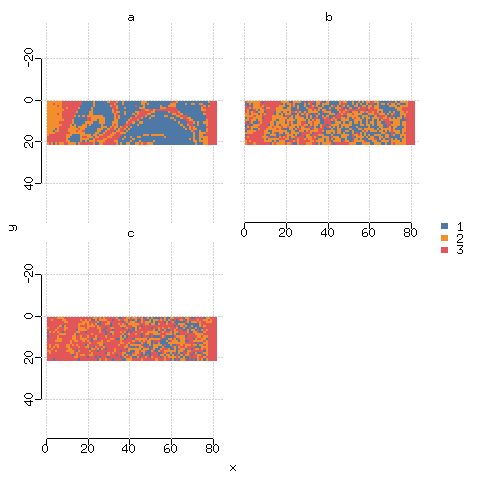

In [63]:
%%R 
image(test_sdgmm, values='class', i=1:3)

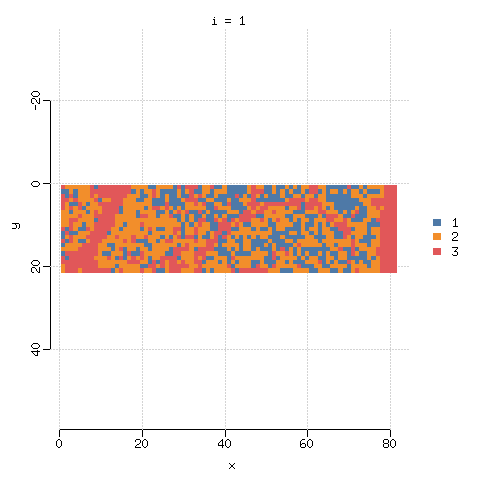

In [169]:
# %%R 
# image(test_sdgmm_onef[[2]], values='class')

Compare the segmentation after removing zero-intensity pixels

In [40]:
%%R
onef_filtered_images <- list()
onef_filtered_sdgmm <- list()
for(i in 3:5){
    test_coord <- cerebellum_df[,c('x', 'y')] 
    test_sdata <- cerebellum_df[[i]]
    nonzero <- test_sdata > 1e-12
    test_sdata <- t(test_sdata[nonzero])
    test_coord <- test_coord[nonzero,]
    test_run <- factor(rep("run0", nrow(test_coord)))
    test_fdata <- MassDataFrame(mz=as.numeric(i))
    test_pdata <- PositionDataFrame(run=test_run, coord=test_coord)
    test_image <- MSImagingExperiment(spectraData=test_sdata,
                                                  featureData=test_fdata,
                                                  pixelData=test_pdata,
                                                  centroided = TRUE)
    onef_filtered_images[[length(onef_filtered_images)+1]] <- test_image
    onef_filtered_sdgmm[[length(onef_filtered_sdgmm)+1]] <- spatialDGMM(test_image, 
                                                                        r=1, k=2, weights='gaussian', 
                                                                        tol=1e-12, iter.max=2000)
}


calculating gaussian weights
fitting spatial Gaussian mixture model for k = 2
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)
returning spatial Gaussian mixture model
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 2
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)
returning spatial Gaussian mixture model
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 2
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)
returning spatial Gaussian mixture model


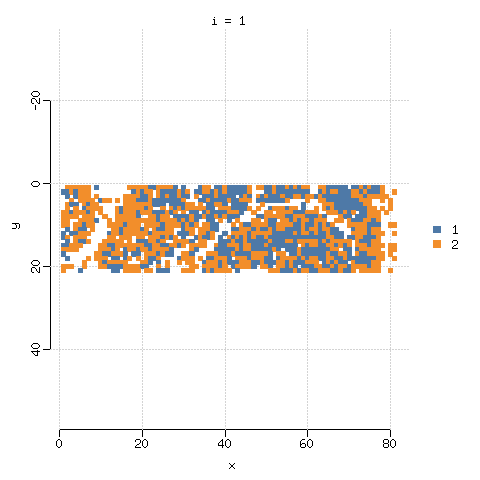

In [42]:
%%R 
image(onef_filtered_sdgmm[[2]], values='class')

Check the impact of log-transformation

In [43]:
%%R
onef_filtered_images <- list()
onef_filtered_sdgmm <- list()
for(i in 3:5){
    test_coord <- cerebellum_df[,c('x', 'y')] 
    test_sdata <- cerebellum_df[[i]]
    nonzero <- test_sdata > 1e-12
    test_sdata <- log(t(test_sdata[nonzero]))
    test_coord <- test_coord[nonzero,]
    test_run <- factor(rep("run0", nrow(test_coord)))
    test_fdata <- MassDataFrame(mz=as.numeric(i))
    test_pdata <- PositionDataFrame(run=test_run, coord=test_coord)
    test_image <- MSImagingExperiment(spectraData=test_sdata,
                                                  featureData=test_fdata,
                                                  pixelData=test_pdata,
                                                  centroided = TRUE)
    onef_filtered_images[[length(onef_filtered_images)+1]] <- test_image
    onef_filtered_sdgmm[[length(onef_filtered_sdgmm)+1]] <- spatialDGMM(test_image, 
                                                                        r=1, k=2, 
                                                                        tol=1e-12, iter.max=2000)
}


calculating gaussian weights
fitting spatial Gaussian mixture model for k = 2
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)
returning spatial Gaussian mixture model
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 2
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)
returning spatial Gaussian mixture model
calculating gaussian weights
fitting spatial Gaussian mixture model for k = 2
fitting spatial segmentations for 1 images
processing chunk 1/1 (1 items)
returning spatial Gaussian mixture model


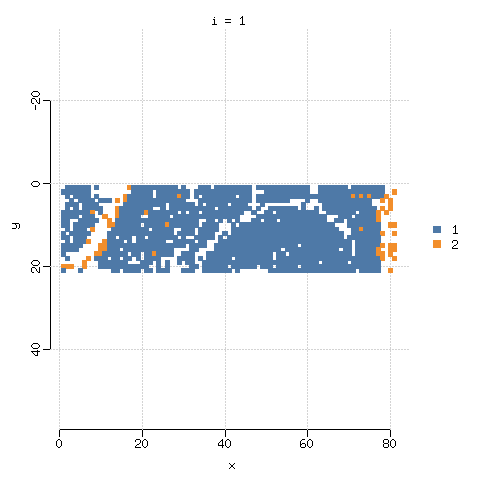

In [44]:
%%R 
image(onef_filtered_sdgmm[[2]], values='class')

Segment all the lipids in the cerebellum image.  
For each lipid, the pixels with zero estimated intensity are assigned to the background segment before the segmentation.   
This is necessary when using models based on Gaussian distribution - a large number of pixels with zero intensity causes models to fail to converge. It is especially important when using intensity values estimated with masserstein, as it will remove background noise and return zero when a lipid is absent.

In [33]:
# %%R

# cerebellum_segments = data.frame(matrix(0, nrow=nrow(cerebellum_df), ncol=ncol(cerebellum_df)))
# colnames(cerebellum_segments) = colnames(cerebellum_df)
# for(column_id in 1:ncol(cerebellum_df)){
#     intsy_vec = cerebellum_df[[column_id]]
#     nonzero = intsy_vec > 1e-12
#     nonzero_intsy_vec = intsy_vec[nonzero]
#     nonzero_coords = cerebellum_coords[, nonzero]  # substitute dataset

#     fdata <- MassDataFrame(mz=1, row.names='1')
#     run <- factor(rep("run0", sum(nonzero)))
#     pdata <- PositionDataFrame(run=run, coord=t(nonzero_coords[c(2,1), ]))
    
#     image <- MSImagingExperiment(imageData=t(nonzero_intsy_vec),
#                                  featureData=fdata,
#                                  pixelData=pdata)
    
#     sdgmm <- spatialDGMM(image, r=9, k=3, # method="adaptive", tol=1e-12, 
#                          init = 'gmm', iter.max=2000)
    
#     segments <- as.numeric(resultData(sdgmm)[[1]]$class)
    
#     cerebellum_segments[nonzero, column_id] <- segments
# }

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 9, k = 3, feature = 1 . 

calculatin

Segment all the lipids in the bladder image.

In [34]:
# %%R

# bladder_segments = data.frame(matrix(0, nrow=nrow(bladder_df), ncol=ncol(bladder_df)))
# colnames(bladder_segments) = colnames(bladder_df)
# for(column_id in 1:ncol(bladder_df)){
#     intsy_vec = bladder_df[[column_id]]
#     nonzero = intsy_vec > 1e-12
#     nonzero_intsy_vec = intsy_vec[nonzero]
#     nonzero_coords = bladder_coords[, nonzero]  

#     fdata <- MassDataFrame(mz=1, row.names='1')
#     run <- factor(rep("run0", sum(nonzero)))
#     pdata <- PositionDataFrame(run=run, coord=t(nonzero_coords[c(2,1), ]))
    
#     image <- MSImagingExperiment(imageData=t(nonzero_intsy_vec),
#                                  featureData=fdata,
#                                  pixelData=pdata)
    
#     sdgmm <- spatialDGMM(image, r=15, k=3,# tol=1e-12,
#                          init = 'gmm', iter.max=2000)
    
#     segments <- as.numeric(resultData(sdgmm)[[1]]$class)
    
#     bladder_segments[nonzero, column_id] <- segments
# }

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 

calculating spatial weights...
segmenting feature images...
r = 15, k = 3, feature = 1 . 


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In plot.window(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 2: 
R[write to console]: In plot.xy(xy, type, ...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 5: 
R[write to console]: In box(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 6: 
R[write to console]: In title(...) :
R[write to console]:  "useS4" is not a graphical parameter



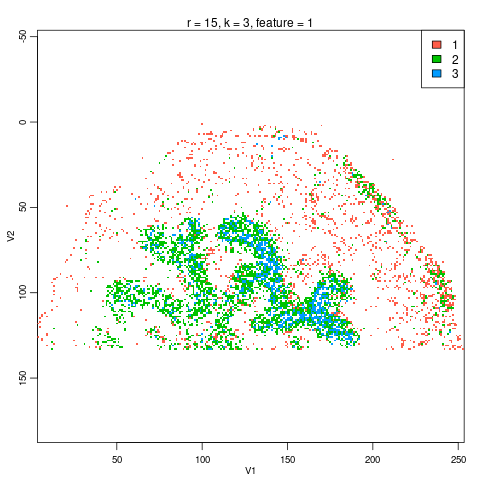

In [35]:
# %%R 

# image(sdgmm, values='class')

Alternative version of clustering all lipids, without filtering the zero-intensity signals (breaks down for many features because of the zero-inflated distribution):   

In [36]:
# %%R 

# # Construct an image with all lipids  
# cerebellum_fdata <- MassDataFrame(mz=1:ncol(cerebellum_df), row.names=as.character(1:ncol(cerebellum_df)))
# cerebellum_run <- factor(rep("run0", nrow(cerebellum_df)))
# cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=t(cerebellum_coords[c(2,1), ]))
# cerebellum_image <- MSImagingExperiment(imageData=t(cerebellum_df),
#                                         featureData=cerebellum_fdata,
#                                         pixelData=cerebellum_pdata)
# # Univariate segmentation of all features
# cerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=6, k=3, method="adaptive", dist='chebyshev',
#                                 init = 'gmm', tol=1e-12, iter.max=2000)

# # Convert Cardinal objects to segmentation arrays
# cerebellum_segments <- sapply(1:ncol(cerebellum_df), function(i) as.numeric(resultData(cerebellum_sdgmm)[[i]]$class))
# # Visualize feature number 8                             
# image(cerebellum_sdgmm, values='class', model=8)                           